# Movie Night Movie Data Analysis

Last Movie Added:  3/12/2021

### Import Libraries & Load Files

In [1]:
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup

import requests
import csv
import re
import time
from tqdm import tqdm

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import imdb

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

In [2]:
# import foreign currency exchange rates - downloaded 3/4/2021
# https://www.bis.org/statistics/xrusd.htm
exchange_rates = pd.read_csv('data/foreign_exchange_rates.csv', low_memory=False)

# import inflation factors - 2016 was the most recent I could find easily.
# conversions will go from movie year to 2016, then 2016 to 2021. 
inflation_factors = pd.read_csv('data/inflation_factors_2016.csv')

In [3]:
movie_night_list = [
    'Cats (2019)',
    'Emo the Musical',
    'Sunday School Musical',
    'Paul Blart Mall Cop 2',
    'Waterworld',
    'Battlefield Earth',
    'Striking Distance',
    'Twilight',
    'Twilight: New Moon',
    'The Lizzie McGuire Movie',
    'Gigli',
    'Anon',
    'Step Sisters',
    'Rip Tide',
    'Starship Troopers',
    'The Clique',
    'The Last Airbender',
    'Sleepover',
    'The Adventures of Sharkboy and Lavagirl 3-D (2005)',
    'The Roommate',
    'Mortal Kombat (1995)',
    'Ghost Rider',
    'Sex and The City 2',
    'The Adventures of Pluto Nash',
    'Scooby-Doo',
    'Silent Hill',
    'Resident Evil (2002)',
    'Yinz',
    'The Anomaly',
    'Birdemic: Shock and Terror',
    'Super Mario Bros.',
    'Trolls World Tour',
    'Rocky Horror',
    'Street Fighter',
    'A Very Country Christmas',
    'Santa Girl',
    'We Can Be Heroes',
    'Spice World',
    'Star Trek IV',
    'I Know Who Killed Me',
    'Jungle 2 Jungle',
    'Howard the Duck',
    'She’s All That',
    'Hackers',
    'Batman and Robin',
    'My Brother the Pig',
    'Catwoman (2004)'
]

test_movie_list = ['Emo the Musical']

### Scrape IMDB

#### Scrape Data for Movie Night Movies

In [4]:
movie_attributes = [ 
  'plot',
  'original title',
  'cast',
  'genres',
  'runtimes',
  'countries',
  'country codes',
  'language codes',
  'color info',
  'aspect ratio',
  'sound mix',
  'certificates',
  'original air date',
  'rating',
  'votes',
  'cover url',
  'imdbID',
  'languages',
  'title',
  'year',
  'kind',
  'directors',
  'writers',
  'producers',
  'composers',
  'cinematographers',
  'editors',
  'editorial department',
  'casting directors',
  'production designers',
  'art directors',
  'set decorators',
  'costume designers',
  'make up department',
  'production managers',
  'assistant directors',
  'art department',
  'sound department',
  'special effects',
  'visual effects',
  'stunts',
  'camera department',
  'animation department',
  'casting department',
  'costume departmen',
  'location management',
  'music department',
  'script department',
  'transportation department',
  'miscellaneous',
  'akas',
  'writer',
  'director',
  'bottom 100 rank',
  'production companies',
  'distributors',
  'special effects companies',
  'other companies'
]

# attributes characterized by a list of one or more names 
name_flags = [
  'cast',
  'directors',
  'writers',
  'producers',
  'composers',
  'cinematographers',
  'editors',
  'editorial department',
  'casting directors',
  'production designers',
  'art directors',
  'set decorators',
  'costume designers',
  'make up department',
  'production managers',
  'assistant directors',
  'art department',
  'sound department',
  'special effects',
  'visual effects',
  'stunts',
  'camera department',
  'animation department',
  'casting department',
  'costume departmen',
  'location management',
  'music department',
  'script department',
  'transportation department',
  'miscellaneous',
  'miscellaneous',
  'writer',
  'director',
  'production companies',
  'distributors',
  'special effects companies',
  'other companies'
]

In [5]:
# scraping functions

def movie_search(movie_title, base_url):
    search_query = base_url + movie_title
    response = requests.get(search_query)
    return response

def scrape_movie_data(movie_list):

    movie_attribute_list = []
    money_attribute_list = []

    imdb_base_url = 'https://www.imdb.com/title/tt'
    money_search_terms = ['Budget:', 'Opening Weekend USA:', 'Gross USA:', 'Cumulative Worldwide Gross:']

    ia = imdb.IMDb()
    for movie_title in tqdm(movie_list):
        movie_row = []
        attempt_counter = 0
        while attempt_counter < 3:
            try: 
                movie_search_results = ia.search_movie(movie_title)
                attempt_counter = 3
            except:
                print('Internal Server Error; Attempt:', attempt_counter+1)
                print('Retrying...')
                attempt_counter += 1
        
        if len(movie_search_results) > 0:
            movie_id = movie_search_results[0].movieID
            movie = ia.get_movie(movie_id)

            for att in movie_attributes:
                try:
                    if att in name_flags:
                        movie_row.append([x['name'] for x in movie[att]])
                    else:
                        movie_row.append(movie[att])
                except:
                    movie_row.append('') 

            movie_attribute_list.append(movie_row)


            response = movie_search(movie_id, imdb_base_url)
            soup = BeautifulSoup(response.content, 'html.parser')

            h4_elements = soup.find_all('h4', {'class':'inline'})


            money_attributes = []

            for term in money_search_terms: 
                not_scraped = True
                for elem in h4_elements:    
                    if elem.text == term:
                        money_attributes.append(elem.find_parent('div').text)
                        not_scraped = False
                if not_scraped:
                    money_attributes.append('')

            money_attribute_list.append(money_attributes)
            
        else:
            print('FURK. Movie not found:', movie_title)
           
            for att in movie_attributes:
                movie_row.append('Not Found')
            movie_attribute_list.append(movie_row)
                
            money_attributes = []
            for term in money_search_terms: 
                money_attributes.append('Not Found')
            money_attribute_list.append(money_attributes)
            
        
    # Clean each set of data

    clean_movie_attribute_list = []

    for movie_row in movie_attribute_list:
        new_row = []
        for movie_att in movie_row:
            if isinstance(movie_att, list):
                new_row.append('; '.join(movie_att))
            else: 
                new_row.append(movie_att)

        clean_movie_attribute_list.append(new_row)   

    clean_money_attribute_list = []

    for movie_row in money_attribute_list:
        new_row = []
        country_code = 'USD'
        for money_attribute in movie_row:
            if money_attribute == '' or money_attribute == 'Not Found':
                new_row.append('')
                
            else:
                split_money_attribute = money_attribute.split('\n')[1]
                budget_val = int(re.sub('[^0-9]', '', split_money_attribute))
               
                # convert foreign currency values to US dollars
                pattern_search = re.findall('[A-Z][A-Z][A-Z][0-9]+', money_attribute)
                if len(pattern_search) > 0:
                    exchange_rate = 1.0
                    country_code = re.findall('[A-Z][A-Z][A-Z][0-9]+', money_attribute)[0][:-1]
                    country_code = re.sub('[0-9]', '', country_code)
                    rate_df = exchange_rates.loc[exchange_rates['CURRENCY'] == country_code]
                    
                    if rate_df.shape[0] > 0:
                        last_ten_rates = [rate_df[col].values[0] if ~np.isnan(rate_df[col].values[0]) else 0 for col in rate_df.columns[-10:]]
                        last_ten_rates = list(filter((0).__ne__, last_ten_rates))

                        if len(last_ten_rates) > 0:
                            exchange_rate = float(last_ten_rates[-1])
                        else: 
                            'no rates in last ten measurement dates. expand range.'
                        budget_val /= exchange_rate
                    else: 
                        print('currency code not found.')
                        print(country_code)
                    
                new_row.append(budget_val)
        new_row.append(country_code)        
                
        clean_money_attribute_list.append(new_row)   

    # Create dataframe

    movie_df = pd.DataFrame(movie_list, columns=['movie_title'])

    money_attribute_cols = [re.sub(':', '', x).lower() for x in money_search_terms]
    money_attribute_cols = [re.sub(' ', '_', x) + '_imdb' for x in money_attribute_cols]
    money_attribute_cols.append('original_currency_code')
    money_attribute_df = pd.DataFrame(clean_money_attribute_list, columns=money_attribute_cols)

    imdb_attribute_df = pd.DataFrame(clean_movie_attribute_list, columns=[re.sub(' ', '_', x) for x in movie_attributes]) 

    movie_df = pd.concat([movie_df, imdb_attribute_df, money_attribute_df], axis=1)

    return movie_df

In [6]:
movie_df = scrape_movie_data(movie_night_list)

100%|██████████| 47/47 [01:57<00:00,  2.50s/it]


In [7]:
movie_df.tail()

,movie_title,plot,original_title,cast,genres,runtimes,countries,country_codes,language_codes,color_info,aspect_ratio,sound_mix,certificates,original_air_date,rating,votes,cover_url,imdbID,languages,title,year,kind,directors,writers,producers,composers,cinematographers,editors,editorial_department,casting_directors,production_designers,art_directors,set_decorators,costume_designers,make_up_department,production_managers,assistant_directors,art_department,sound_department,special_effects,visual_effects,stunts,camera_department,animation_department,casting_department,costume_departmen,location_management,music_department,script_department,transportation_department,miscellaneous,akas,writer,director,bottom_100_rank,production_companies,distributors,special_effects_companies,other_companies,budget_imdb,opening_weekend_usa_imdb,gross_usa_imdb,cumulative_worldwide_gross_imdb,original_currency_code
42,She’s All That,A high school jock makes a bet that he can tur...,She's All That (1999),Freddie Prinze Jr.; Rachael Leigh Cook; Matthe...,Comedy; Romance,95,United States,us,en,Color::(Technicolor),1.85 : 1,DTS; Dolby Digital; SDDS,Argentina:Atp; Australia:M; Belgium:KT/EA; Bra...,29 Jan 1999 (USA),5.9,85138,https://m.media-amazon.com/images/M/MV5BY2Y0N2...,0160862,English,She's All That,1999,movie,Robert Iscove,R. Lee Fleming Jr.,Peter Abrams; Jennifer Gibgot; Richard N. Glad...,Stewart Copeland,Francis Kenny,Casey O. Rohrs,James Andrykowski; Gary Burritt; Lance Chapman...,Ed Mitchell; Robyn Ray,Charles William Breen,Gary Diamond,Jeffrey Kushon,Denise Wingate,Felicity Bowring; Raqueli Dahan; Jane Galli; L...,Maggie Cone; Tracy McGrath; Shaheed Qaasim; Lo...,Randall Badger; W. Alexander Ellis; Tony Eng; ...,Sarah Bullion; George Capetanos; Ryan Effner; ...,Ruth Adelman; Stephen Barden; Steve Bartkowicz...,Shane Daniel Wood,,Gilbert B. Combs; Don Ruffin; Matt Byrne,Russell Ayer; Claudette Barius; James Barrett;...,,Kevin Beard; Matthew Jon Beck,Donna Barrish; Beth Beasley; Sandra Collier; L...,John Steven Agoglia; Evan Peller; Scott A. Lopez,Jennifer Barak; Ryan Beveridge; Stewart Copela...,Scott Peterson,J. Armin Garza II; Michael Merrick; Leo Stefanos,Sophie Addie; Herbert W. Ankrom; Elizabeth A. ...,Elle est trop bien (France); Eine wie keine (G...,R. Lee Fleming Jr.,Robert Iscove,,Miramax; Tapestry Films; FilmColony; All That ...,Miramax; New Films International; 9Go!; Bac Fi...,,Central Casting; Chapman/Leonard Studio Equipm...,10000000,16065430,63366989,103166989,USD
43,Hackers,Hackers are blamed for making a virus that wil...,Hackers (1995),Jonny Lee Miller; Angelina Jolie; Jesse Bradfo...,Comedy; Crime; Drama; Thriller,105,United States,us,en; it; ja; ru,Color,2.35 : 1,DTS-Stereo; DTS,Argentina:13; Australia:M; Canada:PG; Denmark:...,15 Sep 1995 (USA),6.3,65619,https://m.media-amazon.com/images/M/MV5BNmExMT...,0113243,English; Italian; Japanese; Russian,Hackers,1995,movie,Iain Softley,Rafael Moreu,Janet Graham; Jacob Peratrovich; Michael Peyse...,Simon Boswell; Guy Pratt,Andrzej Sekula,Chris Blunden; Martin Walsh,Tom Gibson; Jo Human; Steve Maguire; Jonathan ...,Dianne Crittenden; Michelle Guish,John Beard,John Frankish,Alyssa Winter; Joanne Woollard,Roger Burton,Christine Blundell; Liz Daxauer; Judith Goodma...,Selwyn Roberts; Joel Tuber,Jerry Daly; Dean Garvin; Cordelia Hardy; Pippa...,Jacqueline Arnot; JoAnn Atwood; Crocus Bever; ...,Polly Aitken; Philip Alton; David Anderson; Pe...,Tim Baxter; Paul Dunn; Rick Jotle; Steven Kirs...,Matthew Alexander; Helen Ball; Craig Barron; P...,Bill Anagnos; Jennifer Badger; Peter Bucossi; ...,Andrew Banwell; Jim Bridges; Joe Collins; Zora...,Paul J. Franklin,Barbara Collins; Judie Fixler,Kate Forbes; Anne Gorman; Abigail Hicks; Marci...,Nicholas Bernstein; Piers Dunn; Becky Jones; I...,Bob Last; Paul Rabjohns; Sven Taits,Diana Dill,Jimmy Nugent; Micky Webb,Roderick Alleyne; Wendy Altman-Cohen; Laura Ba...,"Cybernet (Japan, English title); Pirates (Fran...",Rafael Moreu,Iain Softley,,United A

#### Scrape Data for Top 100 and Bottom 100 Movies
(For comparison)

In [8]:
ia = imdb.IMDb()
top_100_movie_list = ia.get_top250_movies()[:100]
bottom_100_movie_list = ia.get_bottom100_movies()

In [9]:
top_100_movie_list = [movie['title'] for movie in top_100_movie_list]
bottom_100_movie_list = [movie['title'] for movie in bottom_100_movie_list]

# fix this issue where one of the worst movies (D&D 2000) is being remade in 2022 so the search query needs to include the year.
bottom_100_movie_list = [title if title != 'Dungeons & Dragons' else 'Dungeons & Dragons (2000)' for title in bottom_100_movie_list]

In [10]:
top100_df = scrape_movie_data(top_100_movie_list)
bottom100_df = scrape_movie_data(bottom_100_movie_list)

  0%|          | 0/100 [00:00<?, ?it/s]

currency code not found.
FRF
currency code not found.
DEM


100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


#  Data Analysis

In [11]:
# list of columns wiht integer values
int_cols = ['runtimes', 'votes', 'year', 'budget_imdb', 'opening_weekend_usa_imdb', 
            'gross_usa_imdb', 'cumulative_worldwide_gross_imdb']

# calculate lengths for each list of names, store as count variables
for col in [re.sub(' ', '_', x) for x in name_flags]:
    movie_df[col + '_count'] = movie_df[col].apply(lambda x: len(x.split(';')))
    top100_df[col + '_count'] = top100_df[col].apply(lambda x: len(x.split(';')))
    bottom100_df[col + '_count'] = bottom100_df[col].apply(lambda x: len(x.split(';')))
    
for col in int_cols:
    top100_df[col] = [0 if val == '' else val for val in top100_df[col].values]
    movie_df[col] = [0 if val == '' else val for val in movie_df[col].values]
    bottom100_df[col] = [0 if val == '' else val for val in bottom100_df[col].values]
    
    top100_df[col] = top100_df[col].apply(int)
    movie_df[col] = movie_df[col].apply(int)
    bottom100_df[col] = bottom100_df[col].apply(int)

In [12]:
# adjust monetary variables for inflation. 
# first, each value is adjusted to 2016 dollars
# second, values are brought from 2016 to 2021 dollars

def get_2016_inflation(year):
    return inflation_factors[inflation_factors['year'] == year]['conversion_factor'].values[0]

    
convert_2016_to_2021_factor = inflation_factors[inflation_factors['year'] == 2021]['conversion_factor'].values[0]

top100_df['inflation_factor_2016'] = top100_df['year'].apply(lambda x: get_2016_inflation(x))
movie_df['inflation_factor_2016'] = movie_df['year'].apply(lambda x: get_2016_inflation(x))
bottom100_df['inflation_factor_2016'] = bottom100_df['year'].apply(lambda x: get_2016_inflation(x))

money_cols = ['budget_imdb', 'opening_weekend_usa_imdb', 'gross_usa_imdb', 'cumulative_worldwide_gross_imdb']

for col in money_cols:
    new_col = col + '_adj_2021'
    top100_df[new_col] = top100_df[col] / top100_df['inflation_factor_2016'] * convert_2016_to_2021_factor
    movie_df[new_col] = movie_df[col] / movie_df['inflation_factor_2016'] * convert_2016_to_2021_factor
    bottom100_df[new_col] = bottom100_df[col] / bottom100_df['inflation_factor_2016'] * convert_2016_to_2021_factor

#### Helper Functions

In [13]:
def clean_col_lists(col, df):
    full_list = '; '.join(df[col].values)
    full_list = full_list.split(';')
    return [x.strip() for x in full_list]

In [14]:
def get_most_common(col, df):
    full_list = clean_col_lists(col, movie_df)
    counter = Counter(full_list)
    return counter.most_common()

In [15]:
def comparative_boxplot(feature_name, df1, df2, df3, plot_range, title=False, figure_name=False):
    fig, axes = plt.subplots(3, 1, figsize=(12,9))

    sns.boxplot(ax=axes[0], x=df1[feature_name].values)
    sns.swarmplot(ax=axes[0], x=df1[feature_name].values, color='r')
    axes[0].set_xlim(plot_range)
    axes[0].set_xlabel('')
    axes[0].set_title('IMBD Top 100 Movies')
    
    sns.boxplot(ax=axes[1], x=df2[feature_name].values)
    sns.swarmplot(ax=axes[1], x=df2[feature_name], color='r')
    axes[1].set_xlim(plot_range)
    axes[1].set_xlabel('')
    axes[1].set_title('Movie Night Movies')

    sns.boxplot(ax=axes[2], x=df3[feature_name].values)
    sns.swarmplot(ax=axes[2], x=df3[feature_name], color='r')
    axes[2].set_xlim(plot_range)
    axes[2].set_title('IMDB Bottom 100 Movies')

    if title:
        fig.suptitle(title, fontsize=16)

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)

    if figure_name:
        plt.savefig(figure_name + '.png')

In [16]:
def single_boxplot(feature_name, df, plot_range, title=False, figure_name=False):
    fig, ax = plt.subplots(figsize=(16,4))

    sns.boxplot(ax=ax, x=df[feature_name].values)
    sns.swarmplot(ax=ax, x=df[feature_name].values, color='r')
    ax.set_xlim(plot_range)

    if title:
        plt.title(title, fontsize=14)
        
    if figure_name:
        plt.savefig(figure_name + '.png')


In [17]:
def comparative_histogram(feature_name, df1, df2, df3, plot_range, title=False, figure_name=False):
    fig, axes = plt.subplots(3, 1, figsize=(12,9))

    sns.histplot(ax=axes[0], x=df1[feature_name].values)
    axes[0].set_xlim(plot_range)
    axes[0].set_xlabel('')
    axes[0].set_title('IMBD Top 100 Movies')
    
    sns.histplot(ax=axes[1], x=df2[feature_name].values)
    axes[1].set_xlim(plot_range)
    axes[1].set_xlabel('')
    axes[1].set_title('Movie Night Movies')
    
    sns.histplot(ax=axes[2], x=df3[feature_name].values)
    axes[2].set_xlim(plot_range)
    axes[2].set_title('IMBD Bottom 100 Movies')

    if title:
        fig.suptitle(title, fontsize=16)

    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    
    if figure_name:
        plt.savefig(figure_name + '.png')

In [18]:
def single_histogram(feature_name, df, plot_range, title=False, figure_name=False):
    fig, ax = plt.subplots(figsize=(16,4))

    sns.histplot(ax=ax, x=df[feature_name].values)
    ax.set_xlim(plot_range)

    if title:
        plt.title(title, fontsize=14)
    
    if figure_name:
        plt.savefig(figure_name + '.png')

In [19]:
def comparative_countplot(feature_name, df1, df2, df3, title=False, figure_name=False):
    df = pd.DataFrame(columns=[feature_name, 'category'])
    
    df1['category'] = 'top100'
    df2['category'] = 'movie_night'
    df3['category'] = 'bottom_100'
    
    df = pd.concat([df, df1[[feature_name, 'category']]])
    df = pd.concat([df, df2[[feature_name, 'category']]])
    df = pd.concat([df, df3[[feature_name, 'category']]])
    
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(data=df, x=feature_name, hue='category')
    
    if title:
        plt.title(title)
        
    if figure_name:
        plt.savefig(figure_name + '.png')

In [20]:
def aggregate_countplot(feature_name, df, num_items, plot_range=False, title=False, figure_name=False, horizontal=False):
    aggregate_df = pd.DataFrame(get_most_common(feature_name, df), columns=[feature_name, 'count'])
    aggregate_df = aggregate_df[aggregate_df[feature_name] != ''][:num_items]
    
    fig, ax = plt.subplots(figsize=(16,6))
    if horizontal:
        sns.barplot(x=aggregate_df[feature_name], y=aggregate_df['count'])
        if plot_range:
            plt.ylim(plot_range)
        plt.xticks(rotation=45, ha='right')
    else:
        sns.barplot(x=aggregate_df['count'], y=aggregate_df[feature_name])
        if plot_range:
            plt.xlim(plot_range)
        
    if title:
        plt.title(title)
        
    if figure_name:
        plt.savefig(figure_name + '.png')

In [21]:
def sorted_countplot(feature_name, df, plot_range=False, num_items=False, title=False, figure_name=False, ascending=False, horizontal=False):
    sorted_df = df.sort_values(by=feature_name, ascending=ascending).reset_index(drop=True)
    
    sorted_df = sorted_df[(sorted_df[feature_name] != 0) & (sorted_df[feature_name] != 0.0)]
    if not num_items:
        num_items = len(sorted_df)
    
    if horizontal:
        fig, ax = plt.subplots(figsize=(16,8))
        sns.barplot(x=sorted_df['movie_title'][:num_items], y=sorted_df[feature_name][:num_items])
        if plot_range:
            plt.ylim(plot_range)
        plt.xticks(rotation=45, ha='right')
    else:
        fig, ax = plt.subplots(figsize=(16,num_items/2.5))
        sns.barplot(x=sorted_df[feature_name][:num_items], y=sorted_df['movie_title'][:num_items])
        if plot_range:
            plt.xlim(plot_range)
    
    if title:
        plt.title(title)
        
    if figure_name:
        plt.savefig(figure_name + '.png')

## General Movie Info

* Rating
* Bottom 100 Ranking Movies
* Runtime
* Countries
* Genre
* Year
* AKAs - TO DO
* Plot - TO DO 


### Rating

/Users/scottduda/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


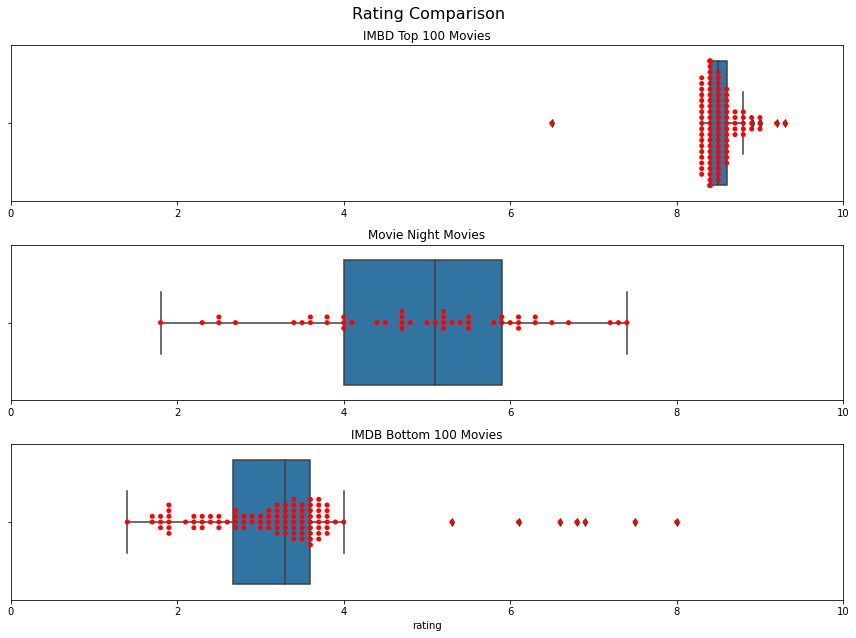

In [22]:
comparative_boxplot('rating', 
                    top100_df, 
                    movie_df, 
                    bottom100_df, 
                    plot_range=[0,10], 
                    title='Rating Comparison', 
                    figure_name=False)

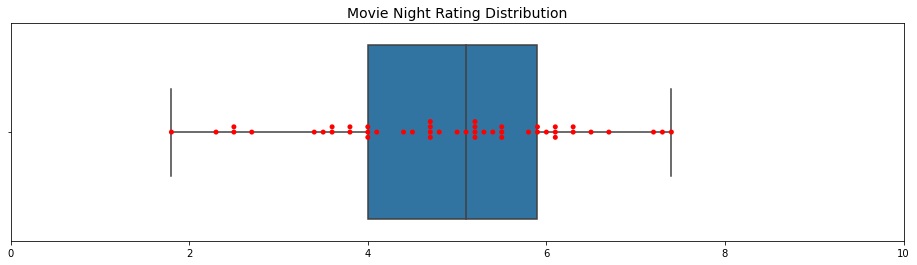

In [23]:
single_boxplot('rating', 
               movie_df, 
               plot_range=[0,10], 
               title='Movie Night Rating Distribution', 
               figure_name=False)

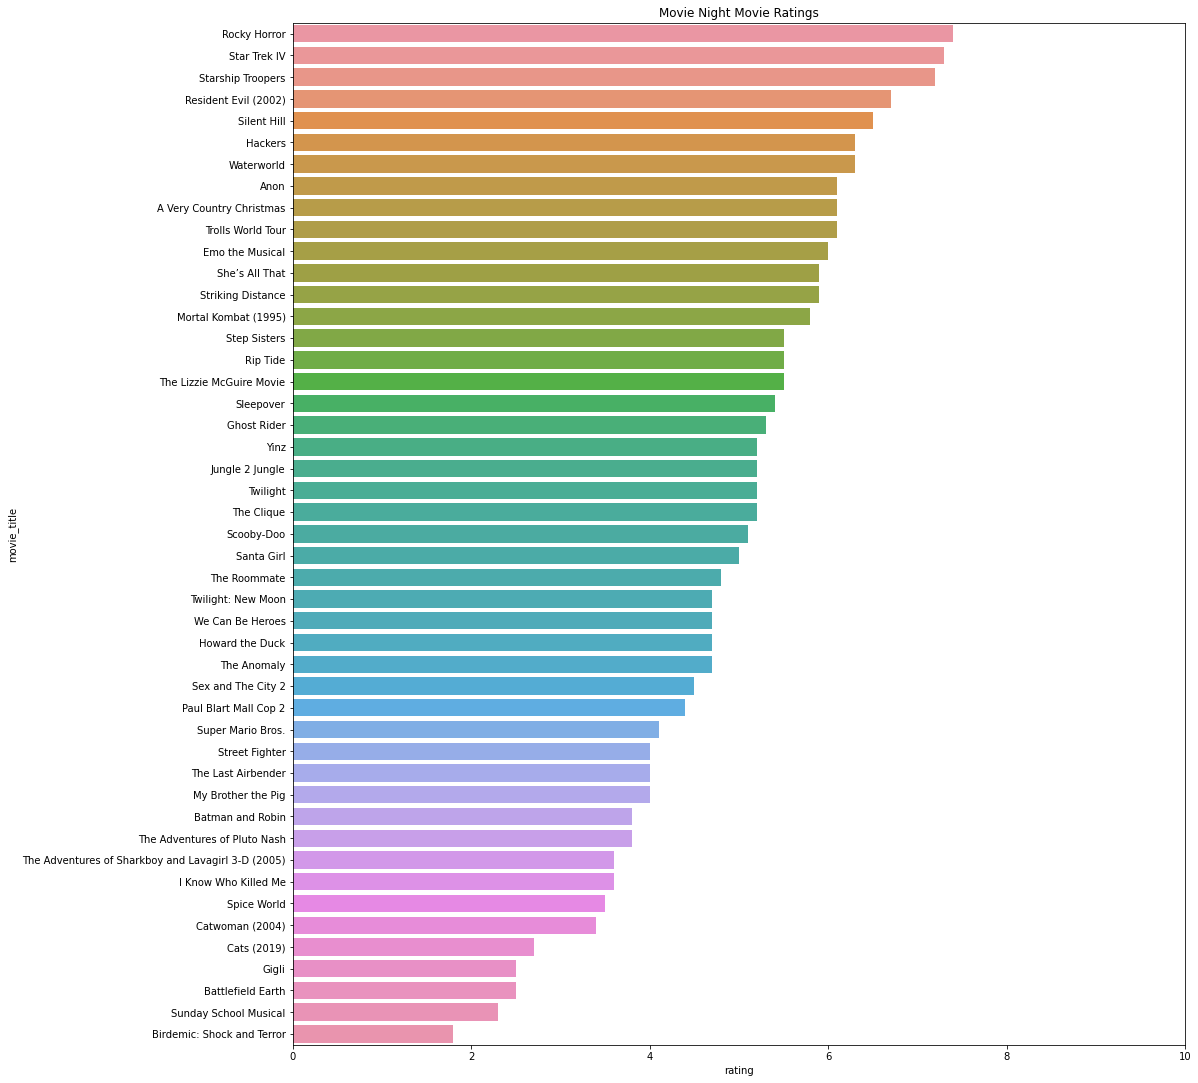

In [24]:
sorted_countplot('rating', 
                 movie_df, 
                 plot_range=[0,10], 
                 num_items=False, 
                 title='Movie Night Movie Ratings', 
                 figure_name=False, 
                 ascending=False)

In [25]:
print('Highest Rating:')
print(movie_df[movie_df['rating'] == max(movie_df['rating'])]['original_title'].values[0])
print(movie_df[movie_df['rating'] == max(movie_df['rating'])]['rating'].values[0])
print('\n')
print('Lowest Rating:')
print(movie_df[movie_df['rating'] == min(movie_df['rating'])]['original_title'].values[0])
print(movie_df[movie_df['rating'] == min(movie_df['rating'])]['rating'].values[0])
print('\n')
print('Average Rating:')
print(round(np.mean(movie_df['rating'].values), 1))

Highest Rating:
The Rocky Horror Picture Show (1975)
7.4


Lowest Rating:
Birdemic: Shock and Terror (2010)
1.8


Average Rating:
4.9


### Bottom 100 Ranking Movies

In [26]:
movie_df['bottom_100_rank'] = movie_df['bottom_100_rank'].apply(lambda x: 0 if x == '' else x)

In [27]:
print('Percentage of Movie Night Movies in the IMDB Bottom 100:')
print(str(round(len(movie_df[movie_df['bottom_100_rank'] > 0])/len(movie_df),2)*100) + '%')

Percentage of Movie Night Movies in the IMDB Bottom 100:
21.0%


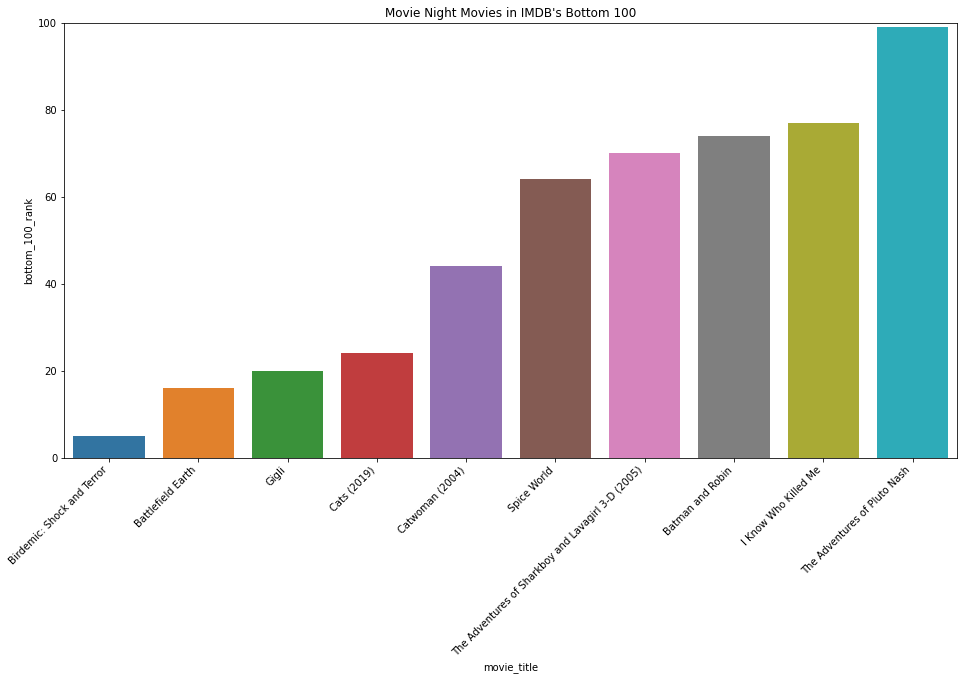

In [28]:
sorted_countplot('bottom_100_rank', 
                 movie_df[movie_df['bottom_100_rank'] > 0], 
                 plot_range=[0,100], 
                 num_items=False, 
                 title="Movie Night Movies in IMDB's Bottom 100", 
                 figure_name=False, 
                 ascending=True, 
                 horizontal=True)

### Runtime

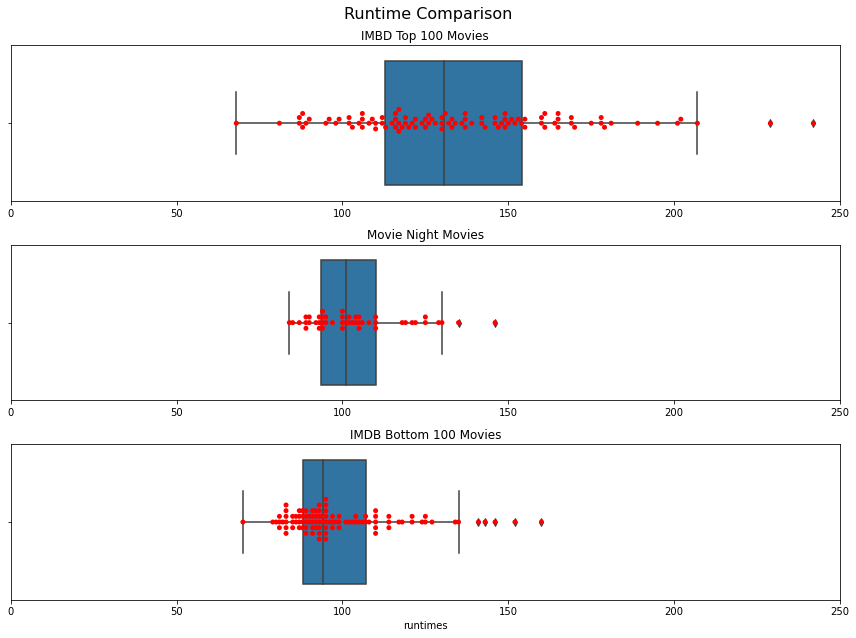

In [29]:
comparative_boxplot('runtimes', 
                    top100_df, 
                    movie_df, 
                    bottom100_df, 
                    plot_range=[0,250], 
                    title='Runtime Comparison', 
                    figure_name=False)

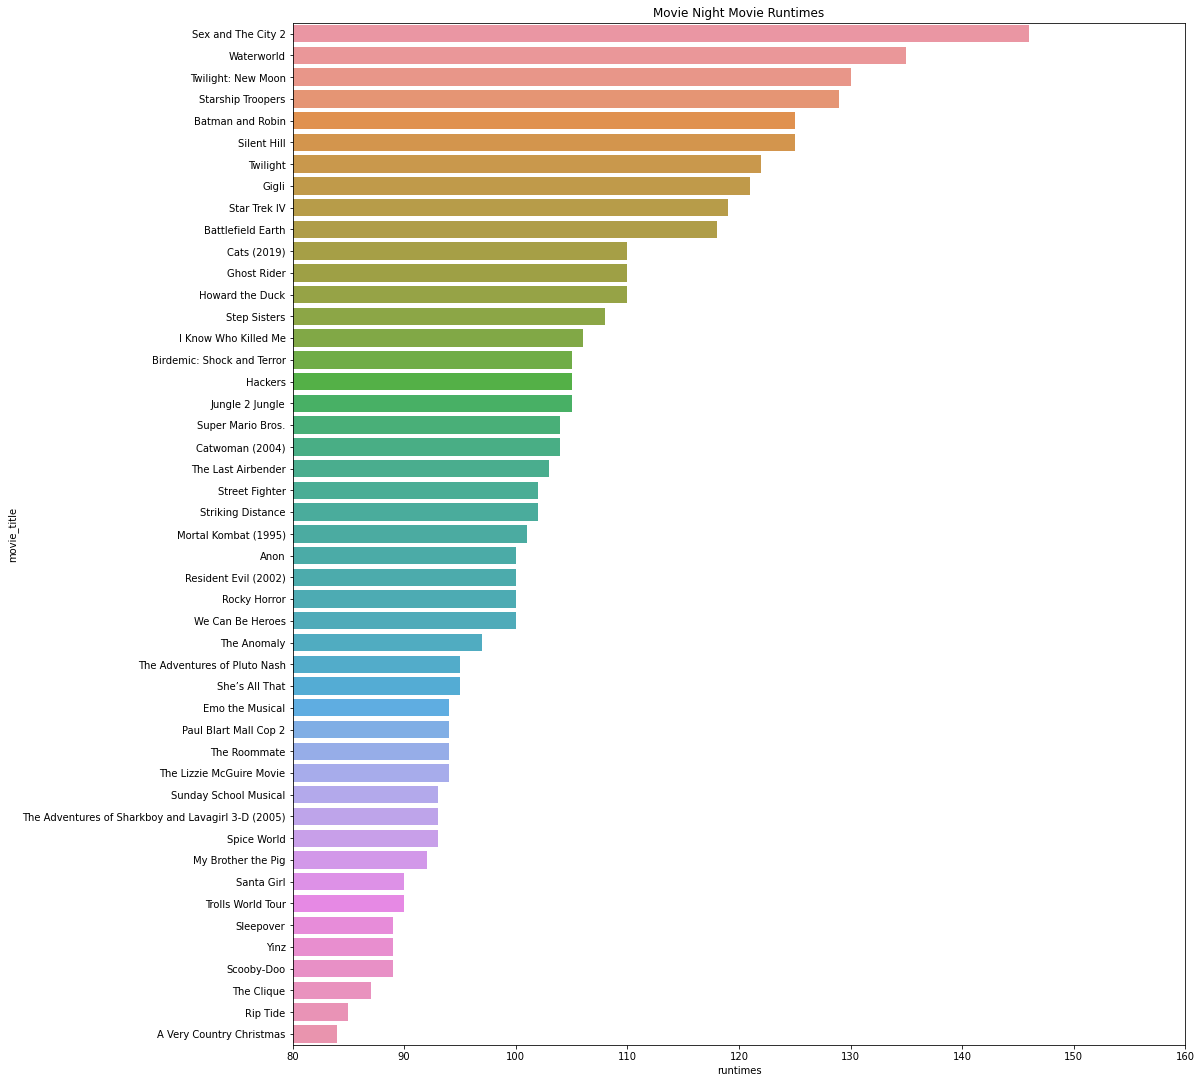

In [30]:
sorted_countplot('runtimes', 
                 movie_df, 
                 plot_range=[80,160], 
                 num_items=False, 
                 title='Movie Night Movie Runtimes', 
                 figure_name=False, 
                 ascending=False)

In [31]:
print('Longest Movie:')
print(movie_df[movie_df['runtimes'] == max(movie_df['runtimes'])]['movie_title'].values[0])
print(movie_df[movie_df['runtimes'] == max(movie_df['runtimes'])]['runtimes'].values[0], 'min')
print('\n')
print('Shortest Movie:')
print(movie_df[movie_df['runtimes'] == min(movie_df['runtimes'])]['movie_title'].values[0])
print(movie_df[movie_df['runtimes'] == min(movie_df['runtimes'])]['runtimes'].values[0], 'min')
print('\n')
print('Total Watching Time:')
print(round(sum(movie_df['runtimes'].values)/60/24, 2), 'days')

Longest Movie:
Sex and The City 2
146 min


Shortest Movie:
A Very Country Christmas
84 min


Total Watching Time:
3.39 days


### Countries

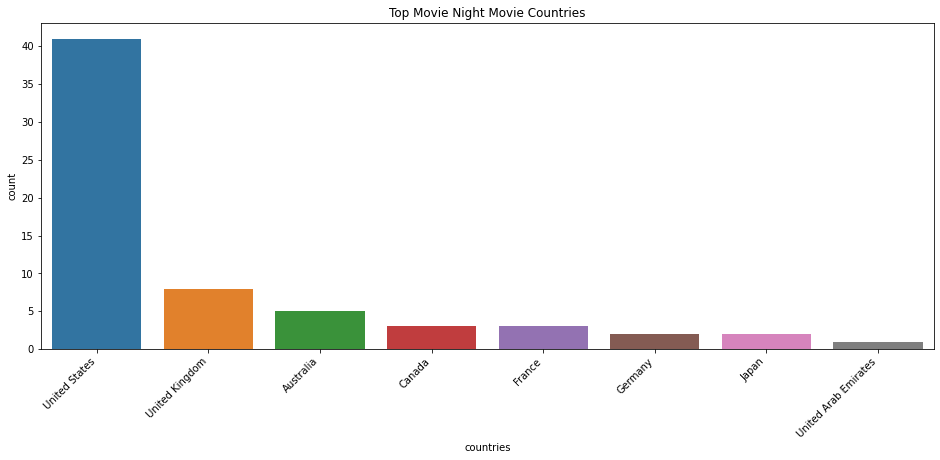

In [32]:
aggregate_countplot('countries',
                    movie_df, 
                    num_items=10, 
                    horizontal = True,
                    title='Top Movie Night Movie Countries', 
                    figure_name=False)

### Genres

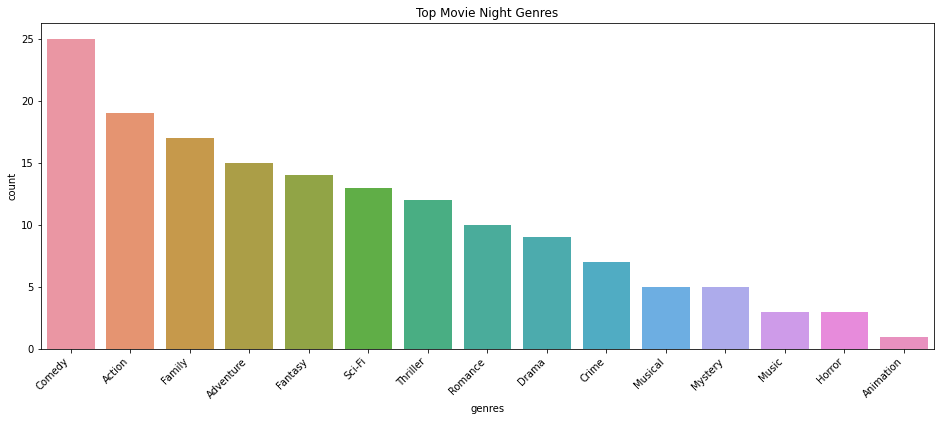

In [33]:
aggregate_countplot('genres',
                    movie_df, 
                    num_items=15, 
                    horizontal=True,
                    title='Top Movie Night Genres', 
                    figure_name=False)

### Year

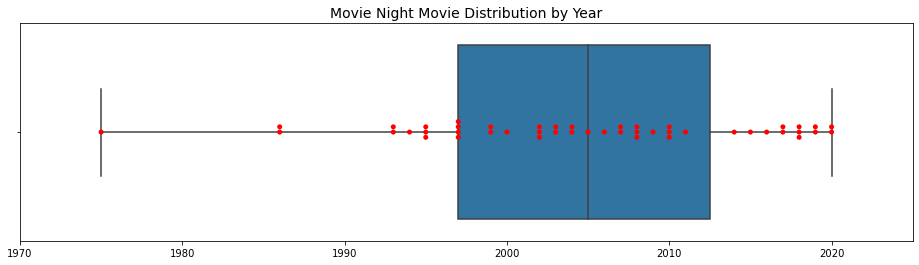

In [34]:
single_boxplot('year',
               movie_df, 
               plot_range=[1970, 2025],
               title='Movie Night Movie Distribution by Year')

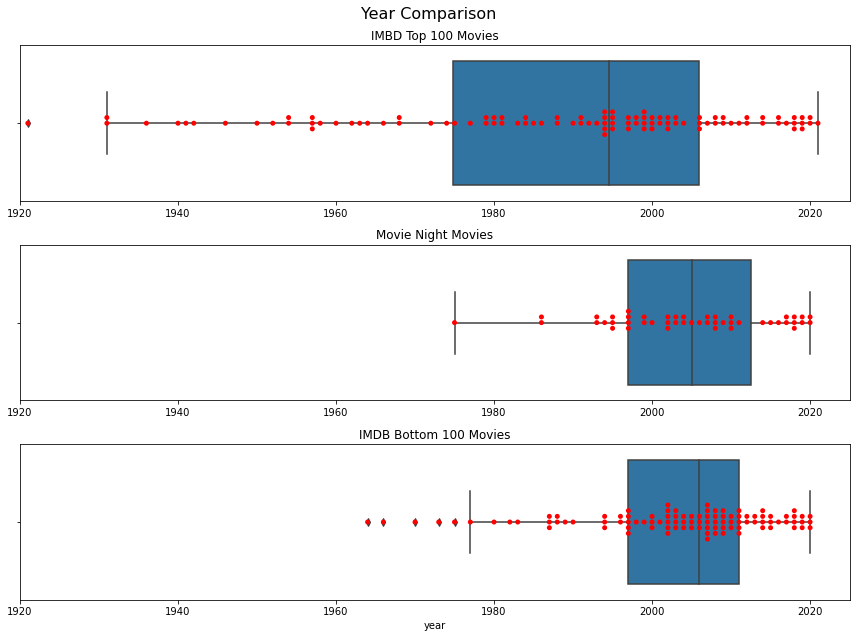

In [35]:
comparative_boxplot('year', 
                    top100_df, 
                    movie_df, 
                    bottom100_df, 
                    plot_range=[1920,2025], 
                    title='Year Comparison', 
                    figure_name=False)

### AKAs

In [36]:
aka_list = [x.split(';') for x in movie_df['akas'].values]
aka_num = [len(x) for x in aka_list]
movie_title_list = movie_df['movie_title'].values.tolist()
expand_movie_title_list = []

for i in range(len(aka_num)):
    expand_movie_title_list.append(((movie_title_list[i] + '; ') * aka_num[i])[:-2])

expand_movie_title_list = [x.split(';') for x in expand_movie_title_list]

aka_list = [x for y in aka_list for x in y]
expand_movie_title_list = [x for y in expand_movie_title_list for x in y]
aka_list = [re.sub(r'\([^)]*\)', '', x) for x in aka_list]
aka_list = [x.strip() for x in aka_list]

In [37]:
import goslate
gs = goslate.Goslate()

In [38]:
aka_list_translated = [gs.translate(x, 'en') for x in aka_list]

In [39]:
translated_df = pd.DataFrame(list(zip(expand_movie_title_list, aka_list, aka_list_translated)), columns=['movie_title', 'aka', 'english_translation'])

In [40]:
translated_df

,movie_title,aka,english_translation
0,Cats (2019),猫,Cat
1,Cats (2019),キャッツ,Cat
2,Cats (2019),Кошки,Cats
3,Cats (2019),Mushuklar,Cats
4,Cats (2019),Mačky,Cats
5,Emo the Musical,"Эмо, мюзикл","Emo, Music"
6,Emo the Musical,エモ・ザ・ミュージカル,Emo The Musical
7,Emo the Musical,"Emo, o Musical","Emo, or musical"
8,Sunday School Musical,Внеклассный мюзикл,Extracurricular musical
9,Paul Blart Mall Cop 2,Der Kaufhaus Cop 2,The department store Cop 2


### Plot

# Movie People

* Cast
* Directors
* Writers
* Producers
* Composers
* Cinematographers
* Editors
* Editorial Department
* Casting Drectors
* Production Designers
* Art Drectors
* Set Decorators
* Costume Designers
* Make up Department
* Production Managers
* Assistant Directors
* Art Department
* Sound Department
* Special Efects
* Visual Efects
* Stunts
* Camera Department
* Animation Department
* Casting Department
* Costume Department
* Location Management
* Music Department
* Script Department
* Transportation Department
* Miscellaneous

### Cast

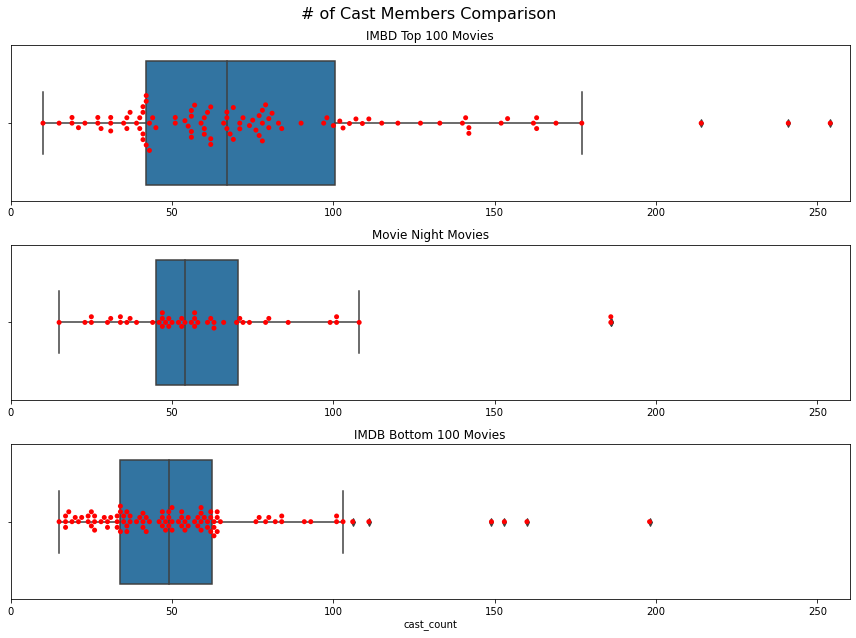

In [41]:
comparative_boxplot('cast_count', 
                    top100_df, 
                    movie_df, 
                    bottom100_df, 
                    plot_range=[0,260], 
                    title='# of Cast Members Comparison', 
                    figure_name=False)

In [42]:
print('Largest Cast Size:')
print(movie_df[movie_df['cast_count'] == max(movie_df['cast_count'])]['movie_title'].values)
print(movie_df[movie_df['cast_count'] == max(movie_df['cast_count'])]['cast_count'].values)
print('\n')
print('Smallest Cast Size:')
print(movie_df[movie_df['cast_count'] == min(movie_df['cast_count'])]['movie_title'].values[0])
print(movie_df[movie_df['cast_count'] == min(movie_df['cast_count'])]['cast_count'].values[0])
print('\n')
print('Average Cast Size:')
print(int(np.mean(movie_df['cast_count'].values)))

Largest Cast Size:
['Paul Blart Mall Cop 2' 'Sex and The City 2']
[186 186]


Smallest Cast Size:
Yinz
15


Average Cast Size:
61


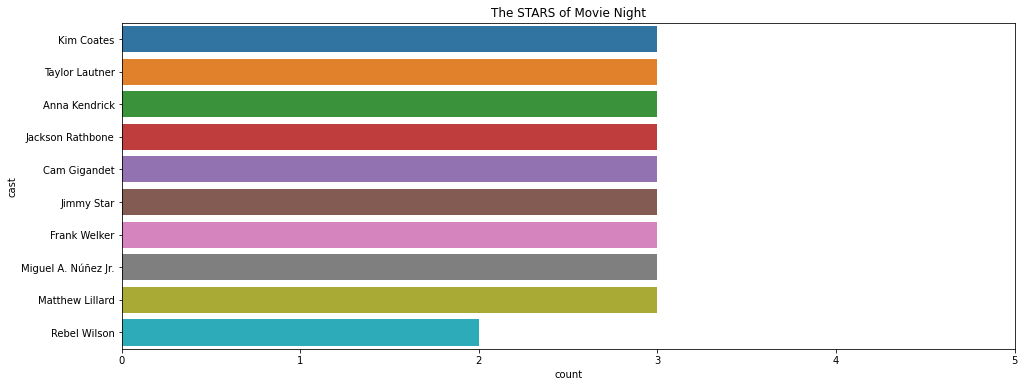

In [43]:
aggregate_countplot('cast', 
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5], 
                    title='The STARS of Movie Night', 
                    figure_name=False,
                    horizontal=False)

### Writers

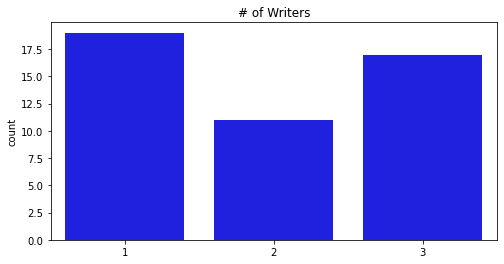

In [44]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['writer_count'].values, color='blue')
plt.title('# of Writers')
plt.show()

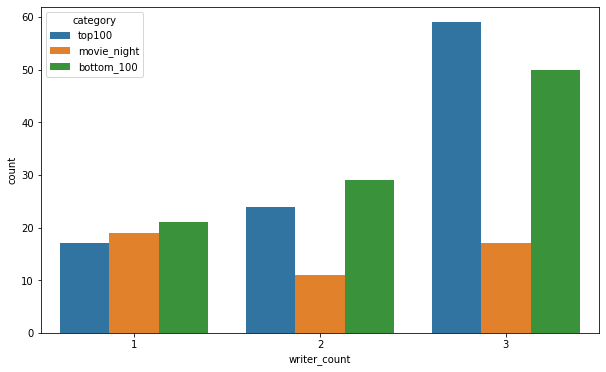

In [45]:
comparative_countplot('writer_count', top100_df, movie_df, bottom100_df)

### Directors

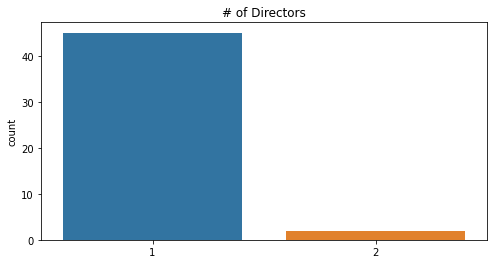

In [46]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['director_count'].values)
plt.title('# of Directors')
plt.show()

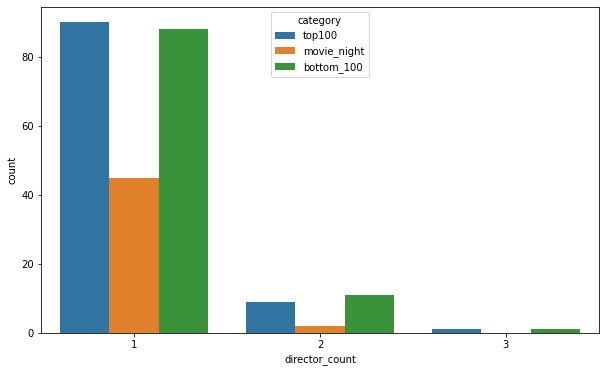

In [47]:
comparative_countplot('director_count', top100_df, movie_df, bottom100_df)

In [48]:
print('Movies With Multiple Directors:')
print(movie_df[movie_df['director_count'] > 1]['movie_title'].values)

Movies With Multiple Directors:
['Super Mario Bros.' 'Trolls World Tour']


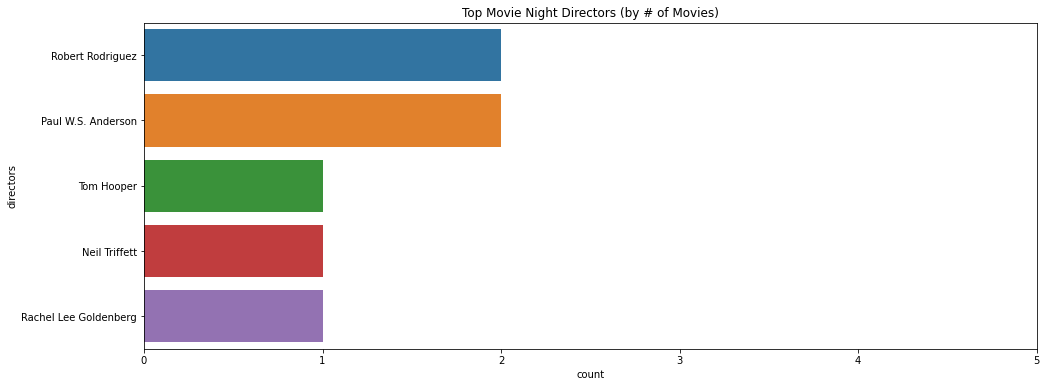

In [49]:
aggregate_countplot('directors', 
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5], 
                    title='Top Movie Night Directors (by # of Movies)', 
                    figure_name=False,
                    horizontal=False)

### Producers

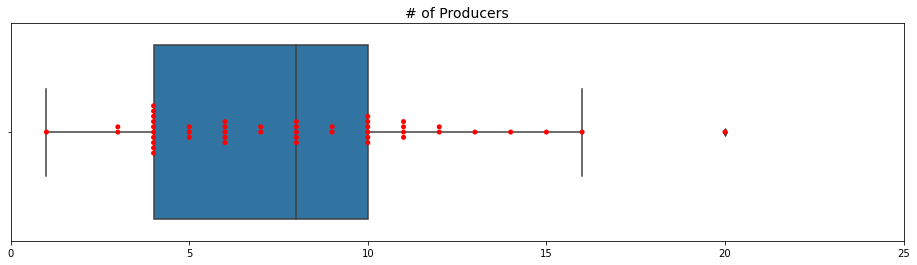

In [50]:
single_boxplot('producers_count',
               movie_df,
               plot_range=[0,25],
               title='# of Producers')

# fig, ax = plt.subplots(figsize=(8,4))
# ax = sns.boxplot(x=movie_df['producers_count'].values)
# ax = sns.swarmplot(x=movie_df['producers_count'].values, color='r')
# plt.title('# of Producers')
# plt.show()

In [51]:
print('Most Producers:')
print(movie_df[movie_df['producers_count'] == max(movie_df['producers_count'])]['movie_title'].values[0])
print(movie_df[movie_df['producers_count'] == max(movie_df['producers_count'])]['producers_count'].values[0])
print('\n')
print('Fewest Producers:')
print(movie_df[movie_df['producers_count'] == min(movie_df['producers_count'])]['movie_title'].values[0])
print(movie_df[movie_df['producers_count'] == min(movie_df['producers_count'])]['producers_count'].values[0])
print('\n')
print('Average # of Producers:')
print(int(np.mean(movie_df['producers_count'].values)))

Most Producers:
The Anomaly
20


Fewest Producers:
Birdemic: Shock and Terror
1


Average # of Producers:
7


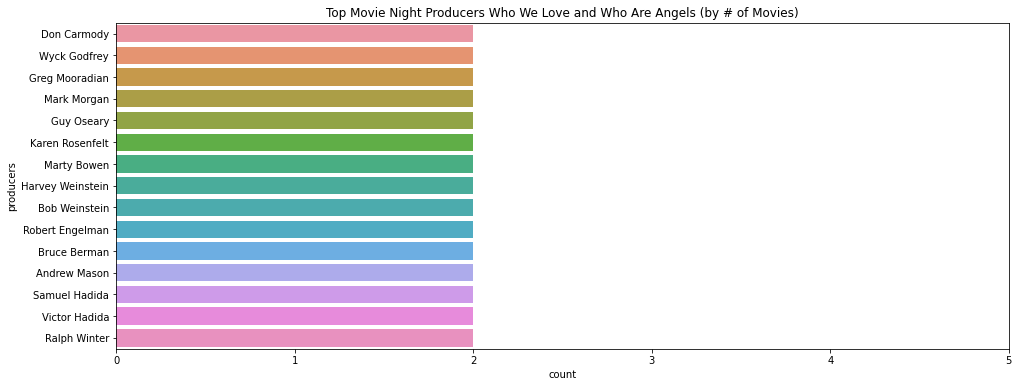

In [52]:
aggregate_countplot('producers', 
                    movie_df, 
                    num_items=15, 
                    plot_range=[0,5], 
                    title='Top Movie Night Producers Who We Love and Who Are Angels (by # of Movies)', 
                    figure_name=False,
                    horizontal=False)

### Composers

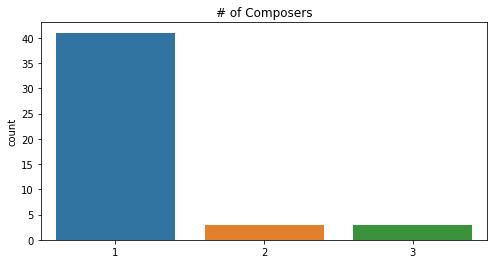

In [53]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['composers_count'].values)
plt.title('# of Composers')
plt.show()

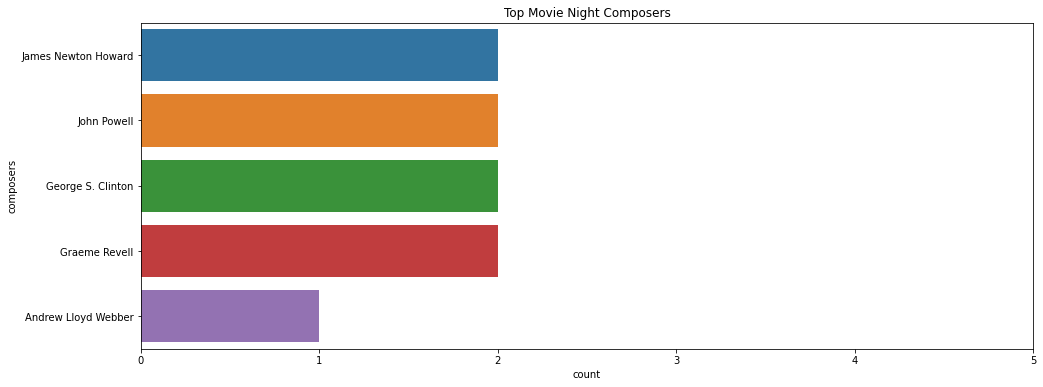

In [54]:
aggregate_countplot('composers',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Composers', 
                    figure_name=False)

### Cinematographers

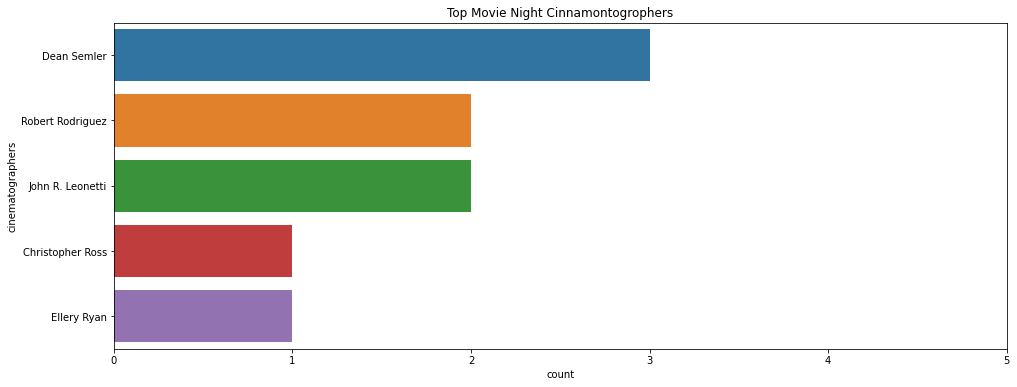

In [55]:
aggregate_countplot('cinematographers',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Cinnamontogrophers', 
                    figure_name=False)

### Editors

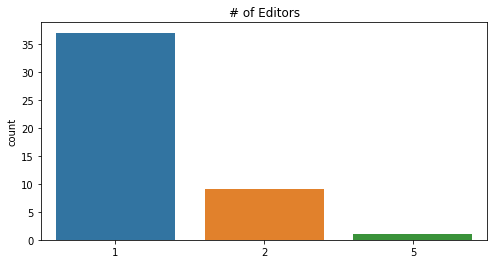

In [56]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['editors_count'].values)
plt.title('# of Editors')
plt.show()

In [57]:
# Over the past two decades, 77% of films released in the United States only had one film editor. 
# In the decade and a half between 1997 and 2011, between 81% and 75% of films credited one editor only. 
# However, by 2016, the number of single editor films had dropped to 68%!  

# https://www.quickclass.net/2017/03/21/many-editors-make-movie/#:~:text=In%202016%2C%20roughly%209%25%20of,directors%2C%20often%20also%20shifting%20narrative.

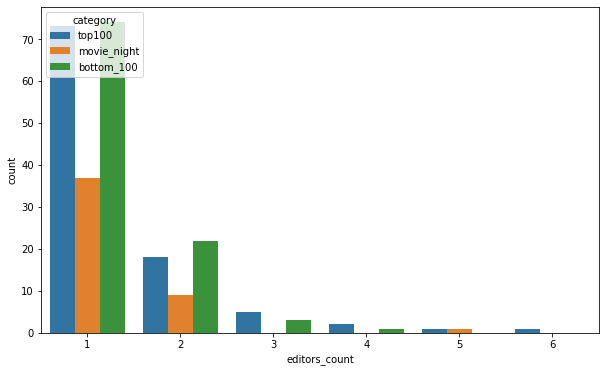

In [58]:
comparative_countplot('editors_count', top100_df, movie_df, bottom100_df)

In [59]:
print('Two-Editor Movies:')
for movie in movie_df[movie_df['editors_count'] == 2]['movie_title'].values:
    print('\t' + movie)

Two-Editor Movies:
	Sunday School Musical
	Striking Distance
	Gigli
	Starship Troopers
	The Adventures of Pluto Nash
	The Anomaly
	Howard the Duck
	Hackers
	Batman and Robin


In [60]:
print('Five-Editor Movies:')
print('\t' + movie_df[movie_df['editors_count'] == 5]['movie_title'].values[0])

Five-Editor Movies:
	Street Fighter


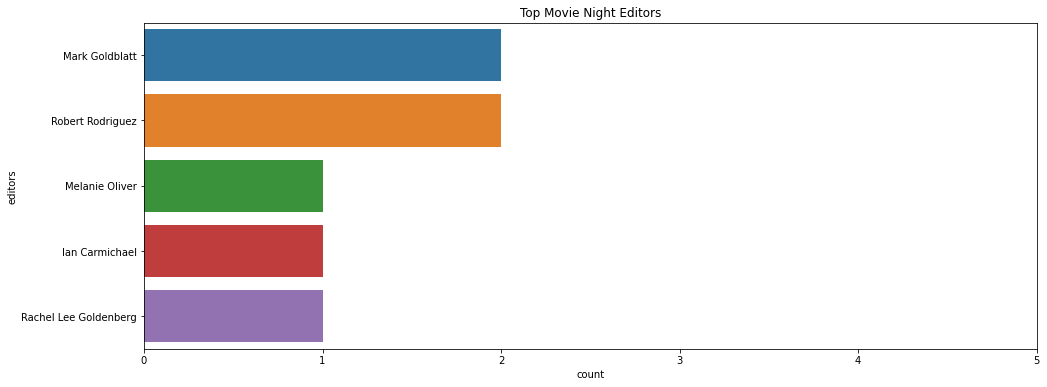

In [61]:
aggregate_countplot('editors',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Editors', 
                    figure_name=False)

### Editorial Department

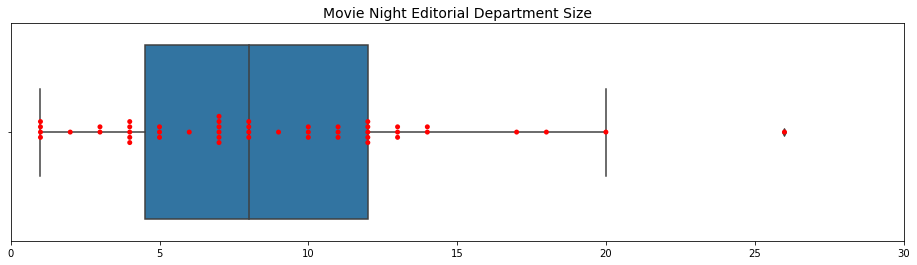

In [62]:
single_boxplot('editorial_department_count',
              movie_df,
              plot_range=[0,30], 
              title='Movie Night Editorial Department Size')


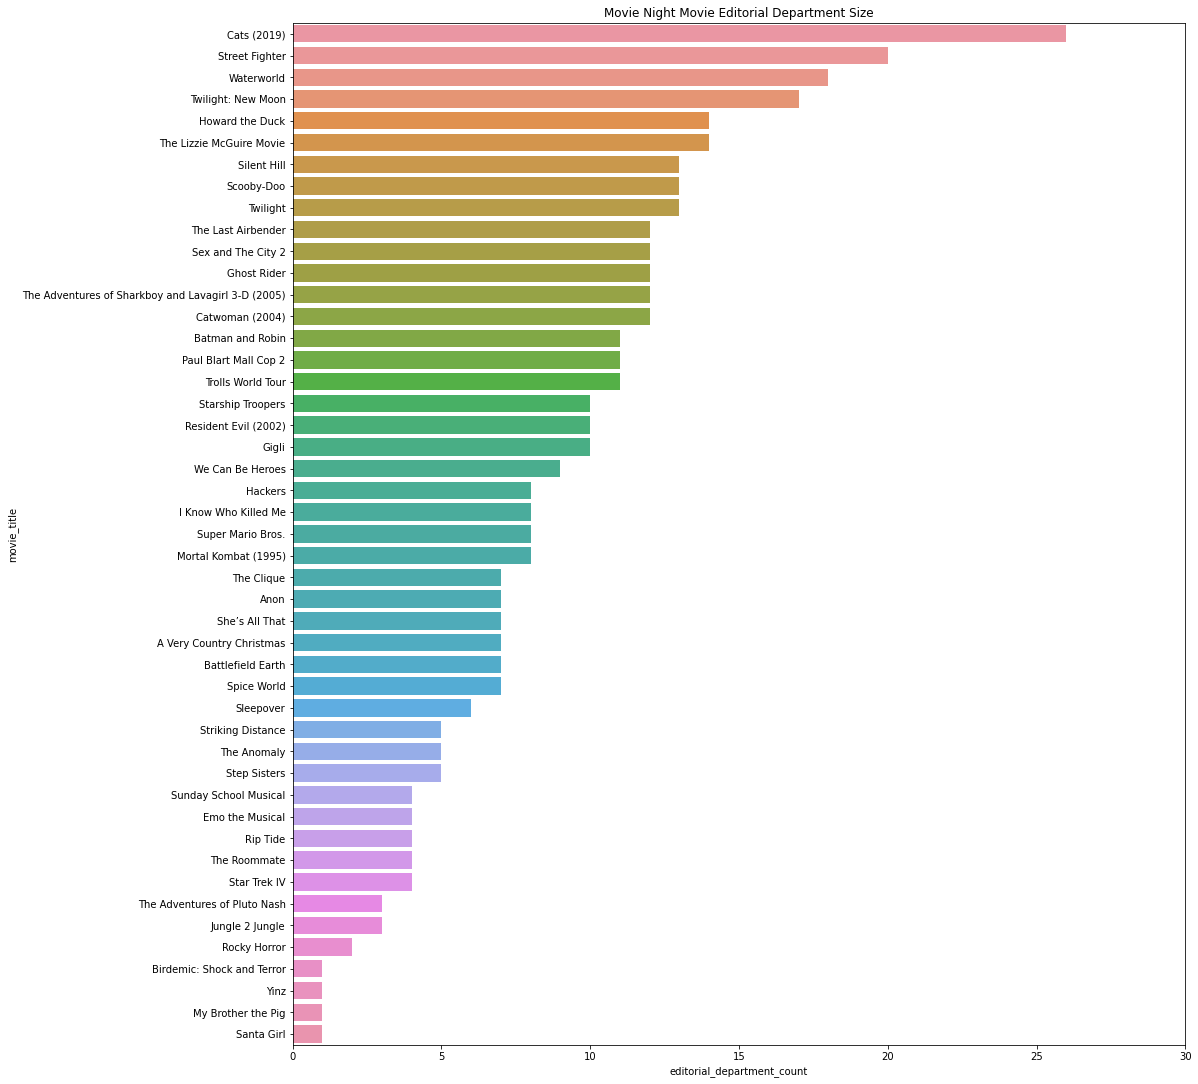

In [63]:
sorted_countplot('editorial_department_count', 
                 movie_df, 
                 plot_range=[0,30], 
                 num_items=False, 
                 title='Movie Night Movie Editorial Department Size', 
                 figure_name=False, 
                 ascending=False)

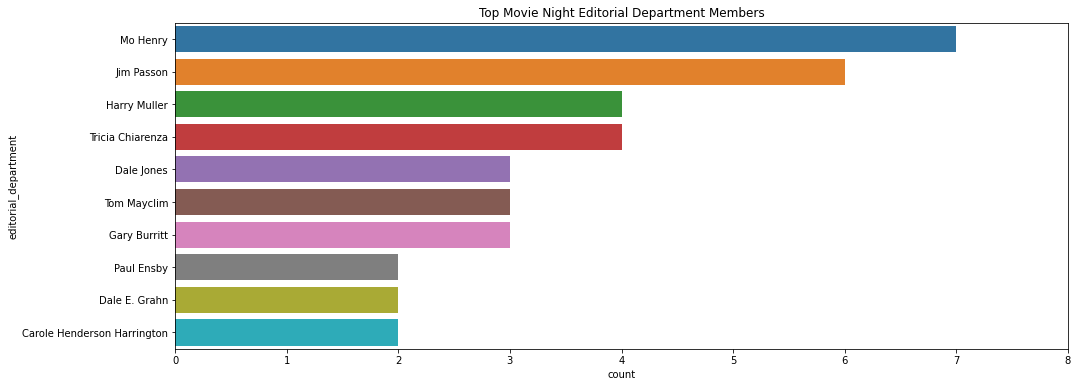

In [64]:
aggregate_countplot('editorial_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,8],
                    title='Top Movie Night Editorial Department Members', 
                    figure_name=False)

### Casting Directors

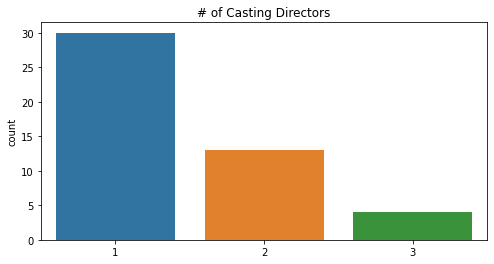

In [65]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['casting_directors_count'].values)
plt.title('# of Casting Directors')
plt.show()

In [66]:
print('Movies with Three Casting Directors:')
for item in movie_df[movie_df['casting_directors_count'] == 3]['movie_title'].values:
    print('\t' + item)

Movies with Three Casting Directors:
	Twilight: New Moon
	Anon
	Mortal Kombat (1995)
	Ghost Rider


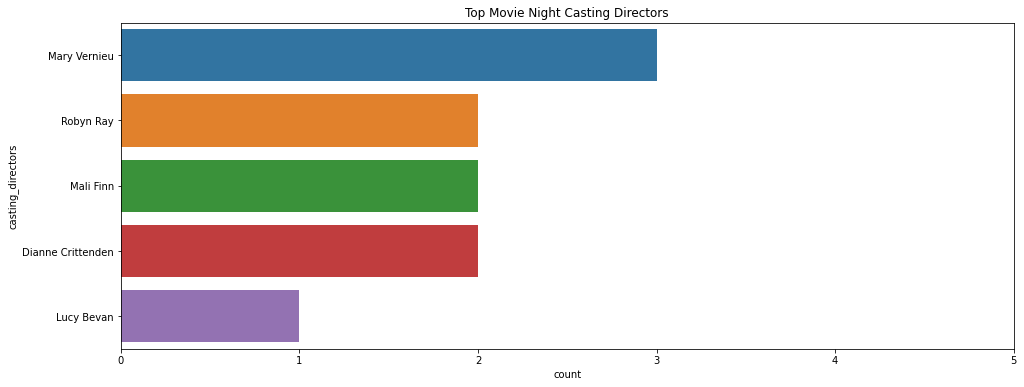

In [67]:
aggregate_countplot('casting_directors',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Casting Directors', 
                    figure_name=False)

### Production Designers

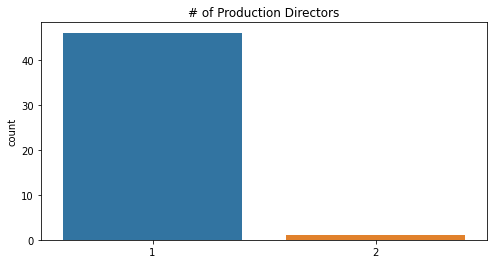

In [68]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['production_designers_count'].values)
plt.title('# of Production Directors')
plt.show()

In [69]:
print('Movies with more than one production designer:')
print('\t' + movie_df[movie_df['production_designers_count'] > 1]['movie_title'].values[0])

Movies with more than one production designer:
	Step Sisters


### Art Directors

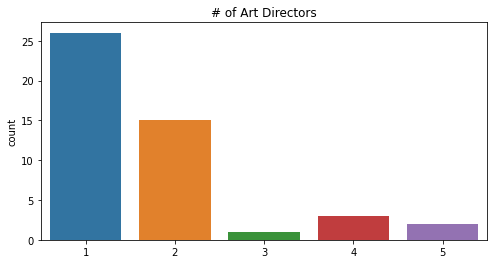

In [70]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['art_directors_count'].values)
plt.title('# of Art Directors')
plt.show()

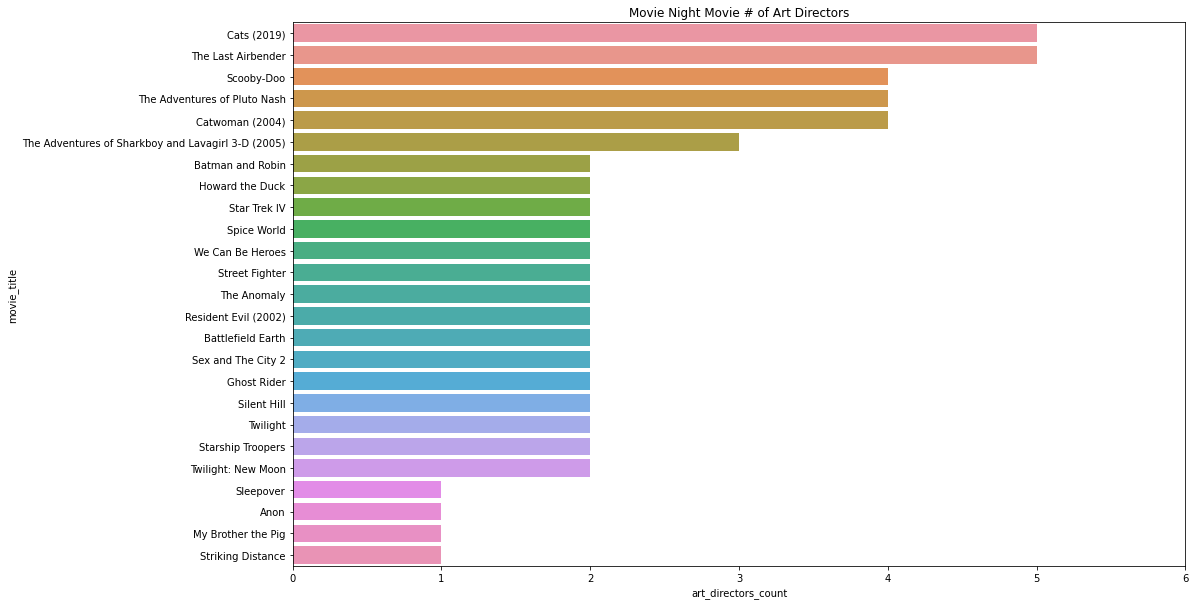

In [71]:
sorted_countplot('art_directors_count', 
                 movie_df, 
                 plot_range=[0,6], 
                 num_items=25, 
                 title='Movie Night Movie # of Art Directors', 
                 figure_name=False, 
                 ascending=False)

### Set Decorators

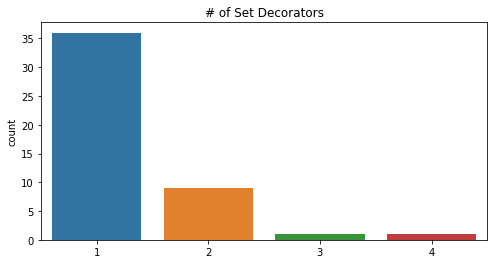

In [72]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['set_decorators_count'].values)
plt.title('# of Set Decorators')
plt.show()

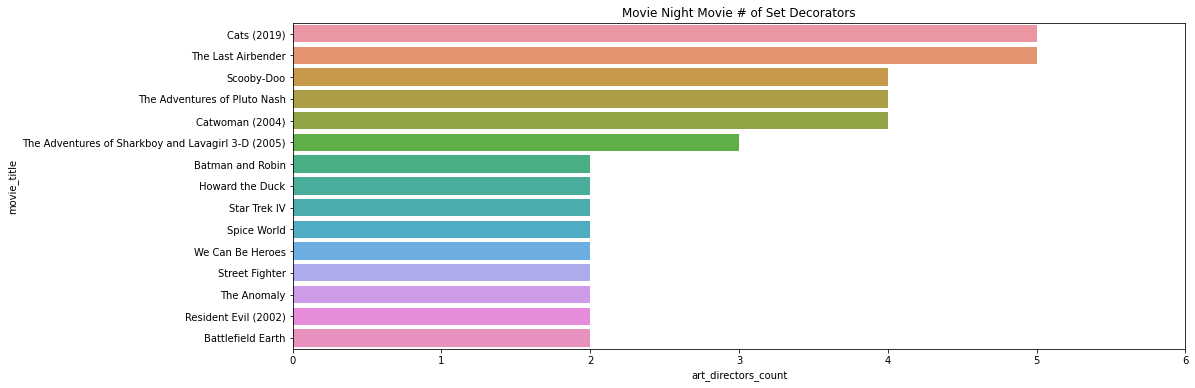

In [73]:
sorted_countplot('art_directors_count', 
                 movie_df, 
                 plot_range=[0,6], 
                 num_items=15, 
                 title='Movie Night Movie # of Set Decorators', 
                 figure_name=False, 
                 ascending=False)

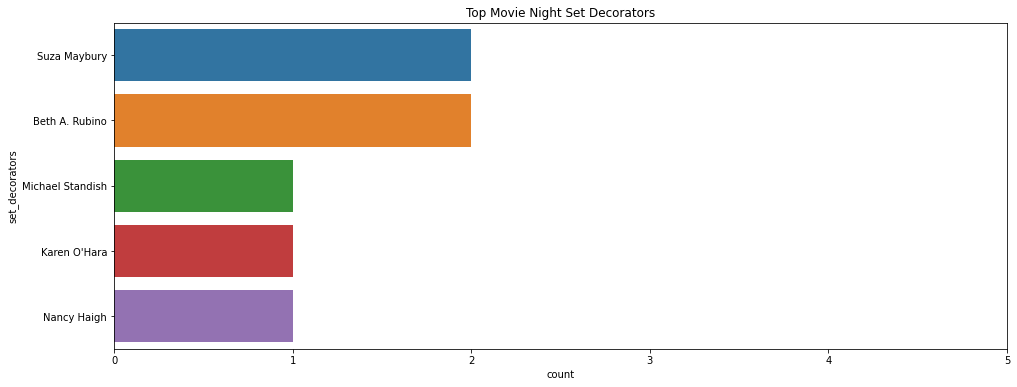

In [74]:
aggregate_countplot('set_decorators',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Set Decorators', 
                    figure_name=False)

### Costumer Designers

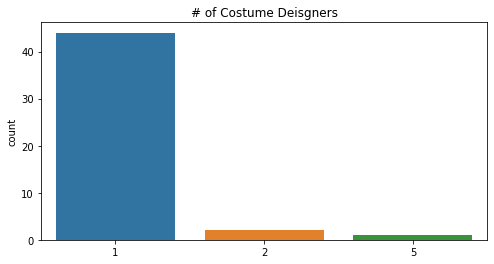

In [75]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['costume_designers_count'].values)
plt.title('# of Costume Deisgners')
plt.show()

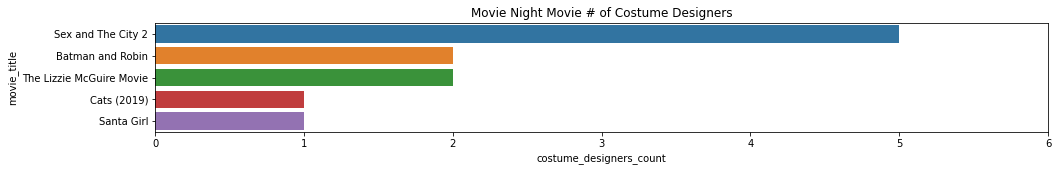

In [76]:
sorted_countplot('costume_designers_count', 
                 movie_df, 
                 plot_range=[0,6], 
                 num_items=5, 
                 title='Movie Night Movie # of Costume Designers', 
                 figure_name=False, 
                 ascending=False)

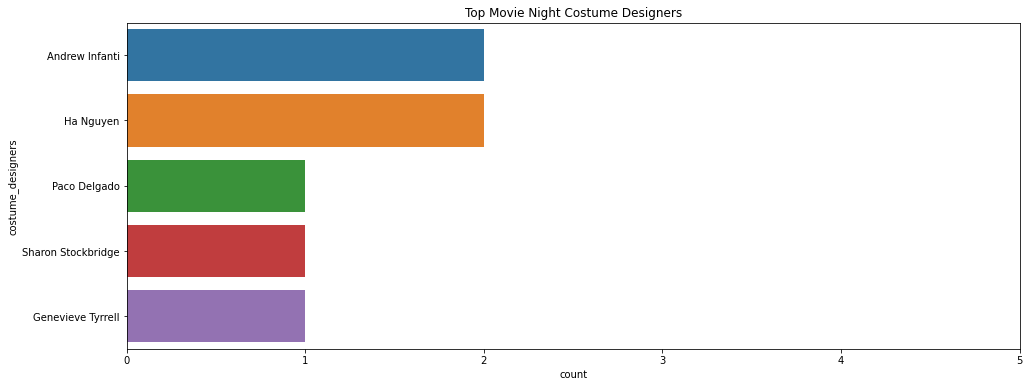

In [77]:
aggregate_countplot('costume_designers',
                    movie_df, 
                    num_items=5, 
                    plot_range=[0,5],
                    title='Top Movie Night Costume Designers', 
                    figure_name=False)

### Make-Up Department

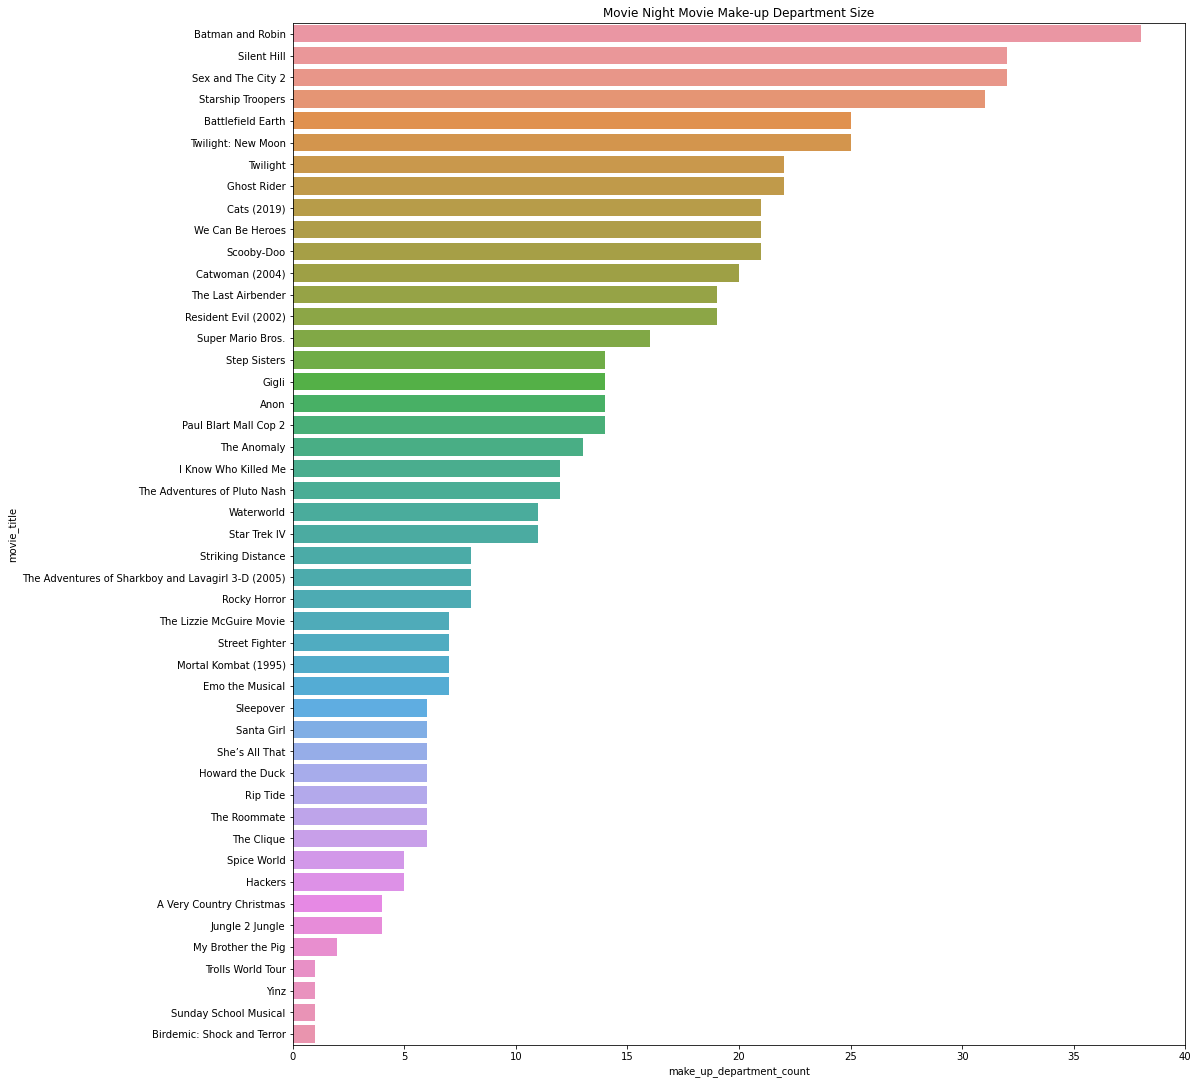

In [78]:
sorted_countplot('make_up_department_count', 
                 movie_df, 
                 plot_range=[0,40], 
                 num_items=False, 
                 title='Movie Night Movie Make-up Department Size', 
                 figure_name=False, 
                 ascending=False)

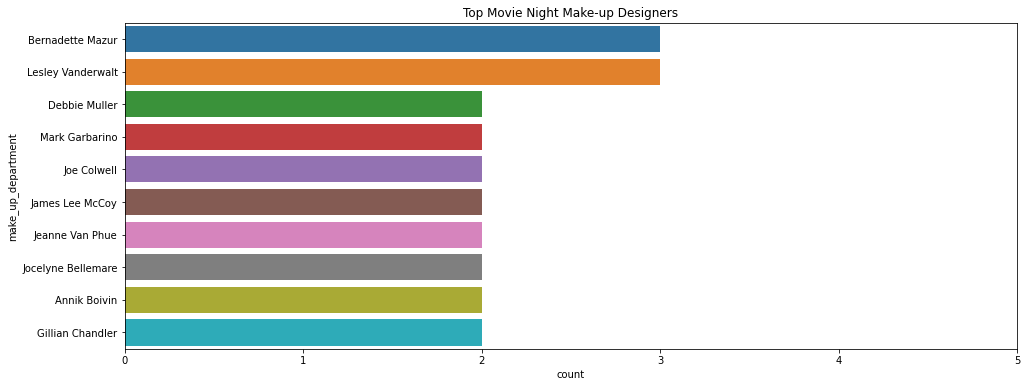

In [79]:
aggregate_countplot('make_up_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Make-up Designers', 
                    figure_name=False)

### Production Managers

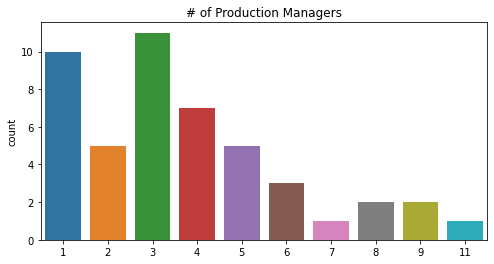

In [80]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['production_managers_count'].values)
plt.title('# of Production Managers')
plt.show()

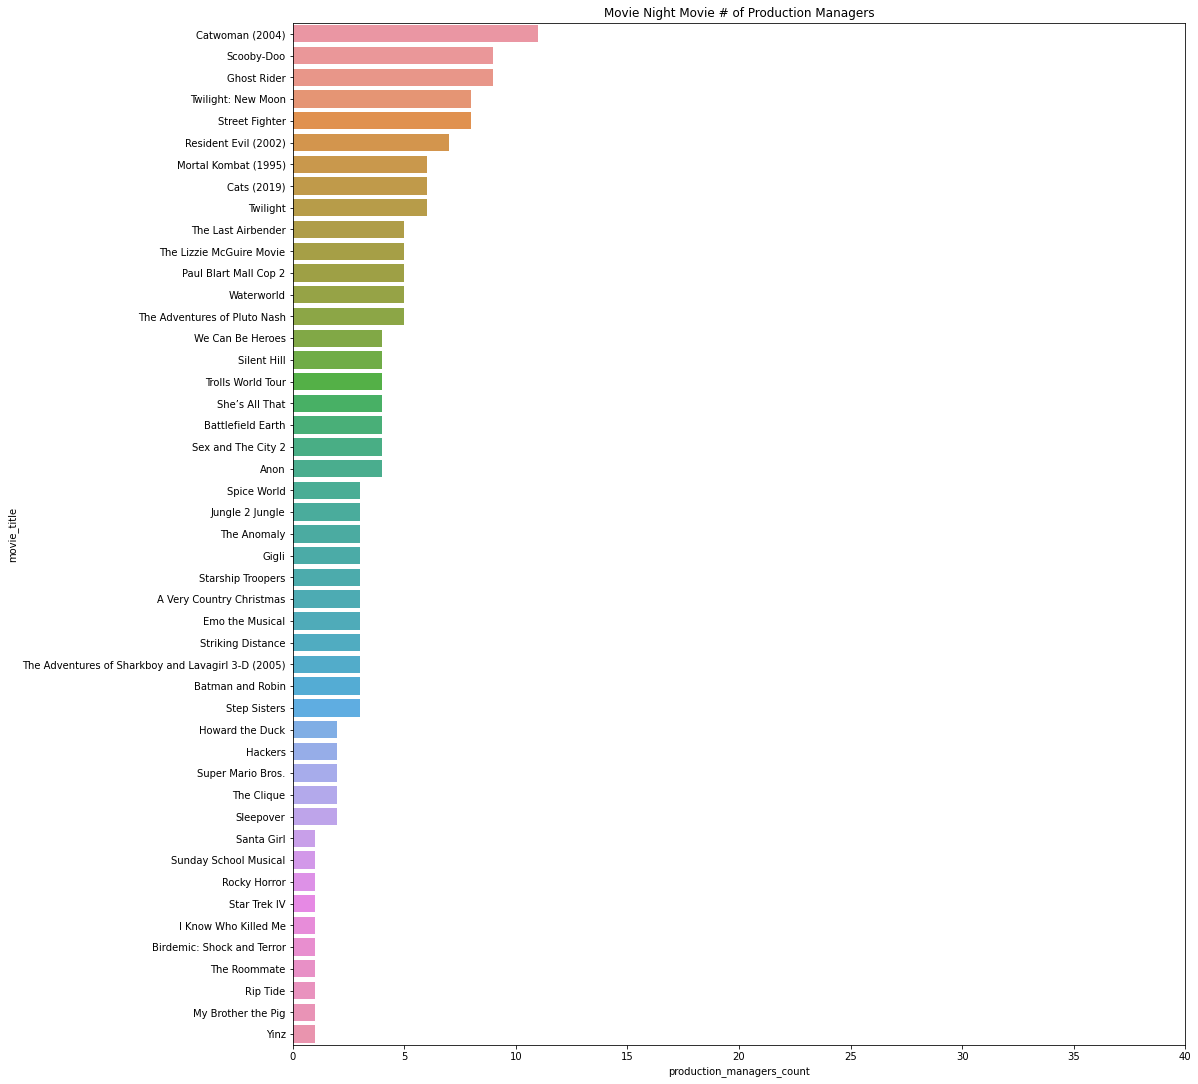

In [81]:
sorted_countplot('production_managers_count', 
                 movie_df, 
                 plot_range=[0,40], 
                 num_items=False, 
                 title='Movie Night Movie # of Production Managers', 
                 figure_name=False, 
                 ascending=False)

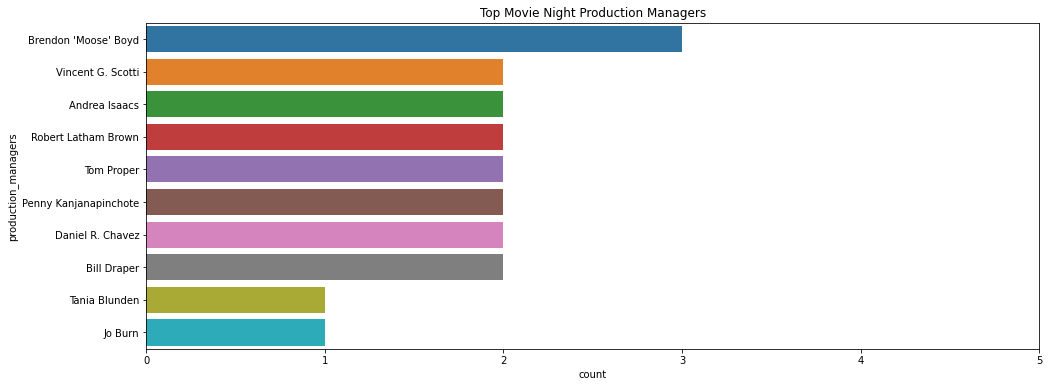

In [82]:
aggregate_countplot('production_managers',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Production Managers', 
                    figure_name=False)

### Assistant Directors

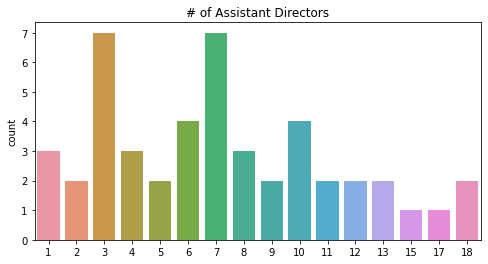

In [83]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['assistant_directors_count'].values)
plt.title('# of Assistant Directors')
plt.show()

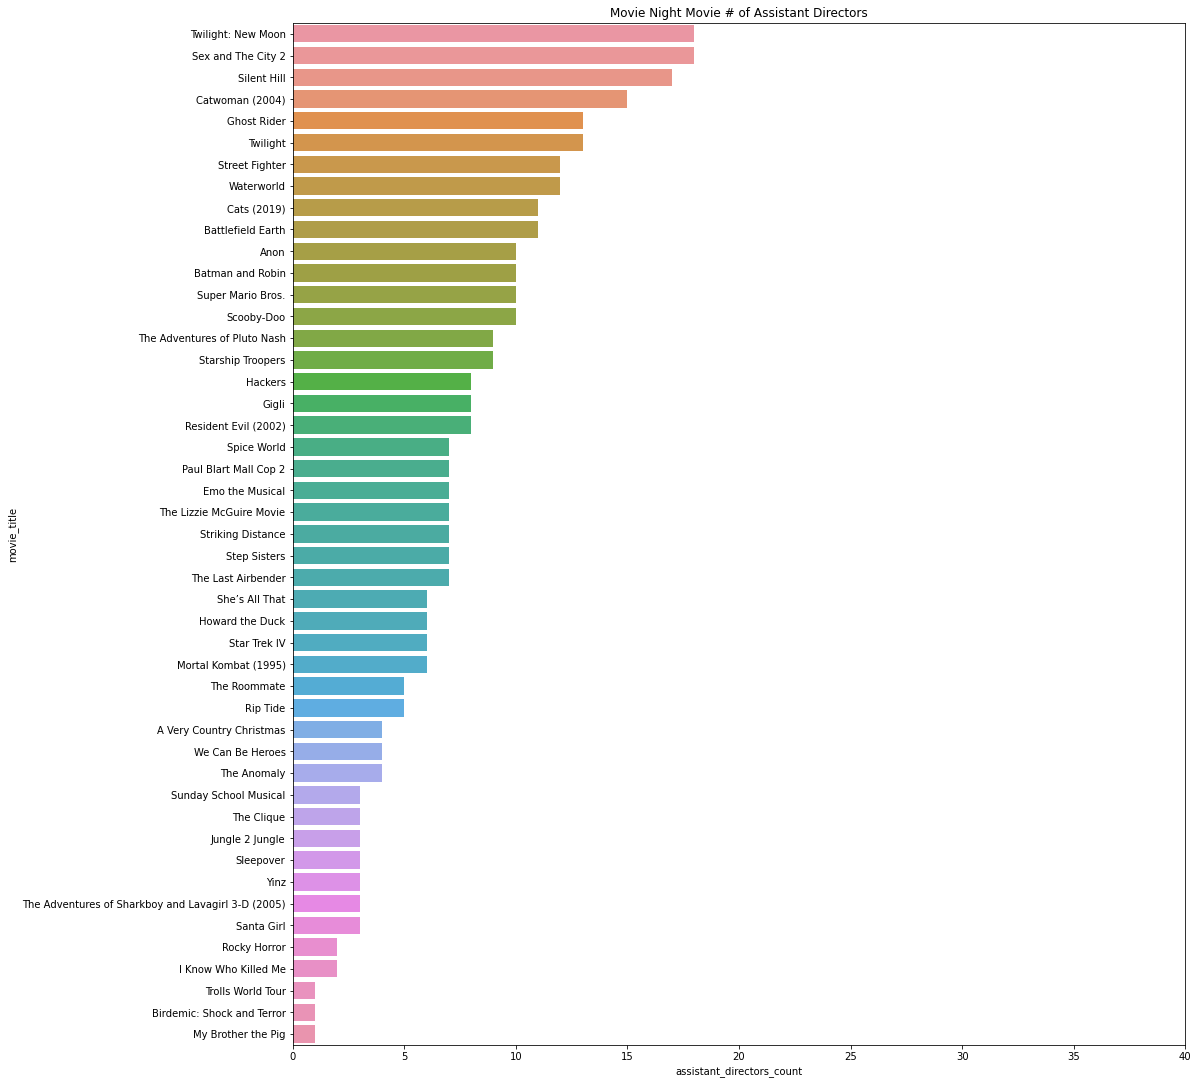

In [84]:
sorted_countplot('assistant_directors_count', 
                 movie_df, 
                 plot_range=[0,40], 
                 num_items=False, 
                 title='Movie Night Movie # of Assistant Directors', 
                 figure_name=False, 
                 ascending=False)

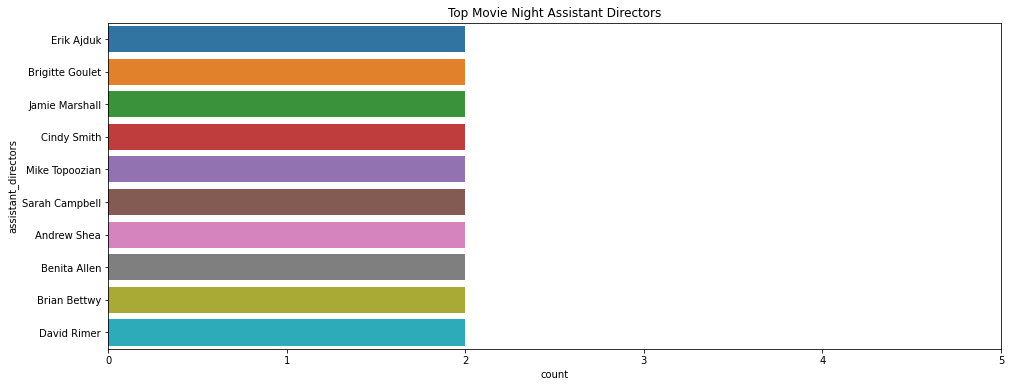

In [85]:
aggregate_countplot('assistant_directors',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Assistant Directors', 
                    figure_name=False)

### Art Department

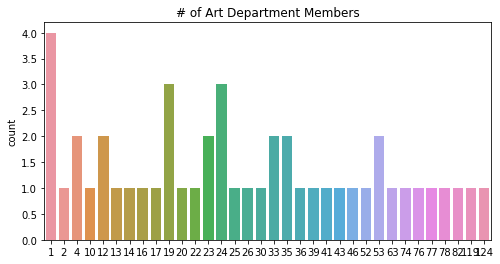

In [86]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['art_department_count'].values)
plt.title('# of Art Department Members')
plt.show()

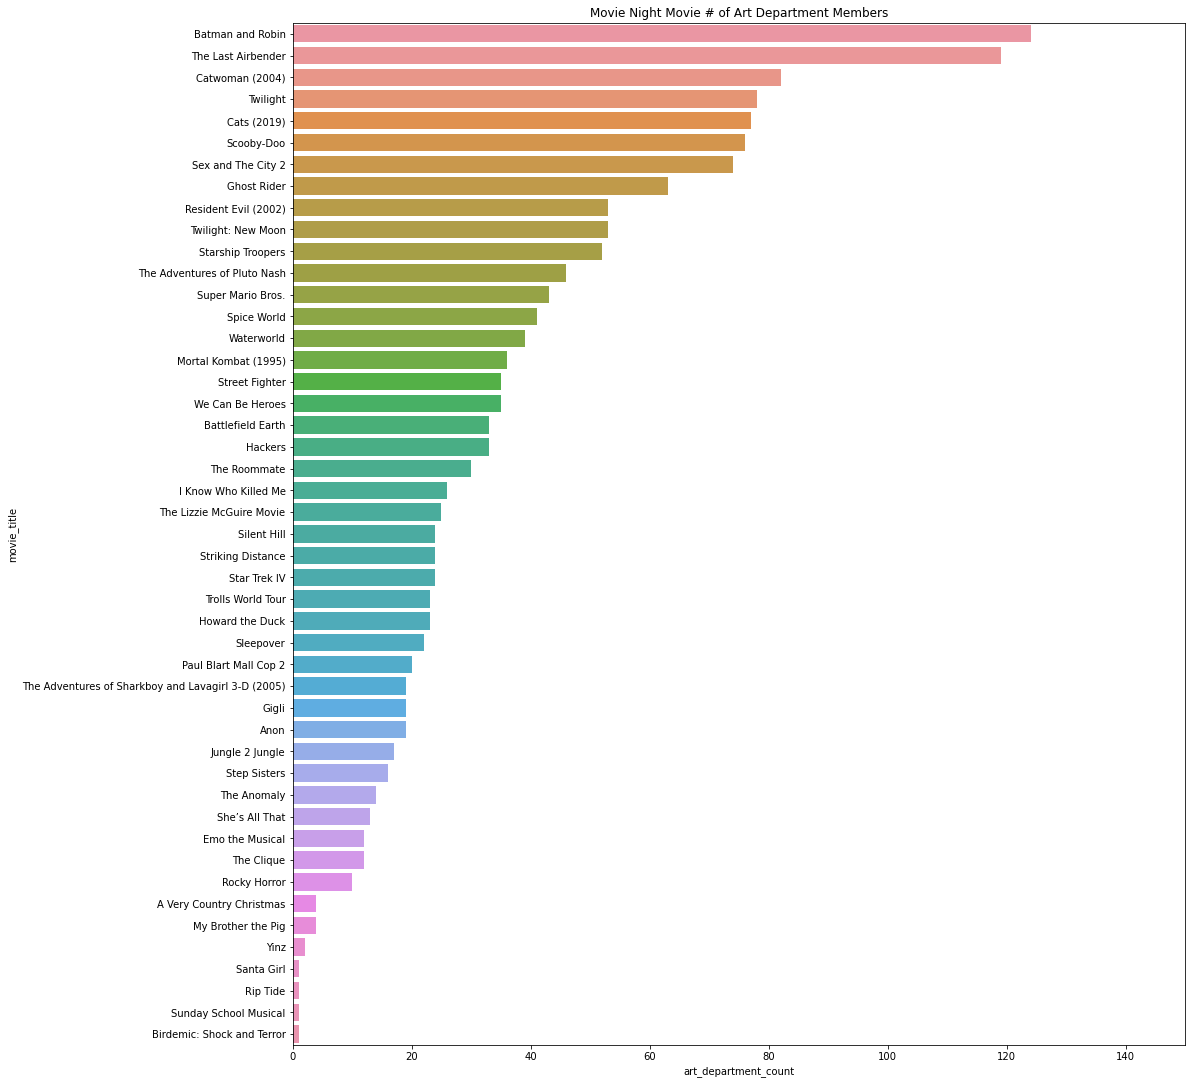

In [87]:
sorted_countplot('art_department_count', 
                 movie_df, 
                 plot_range=[0,150], 
                 num_items=False, 
                 title='Movie Night Movie # of Art Department Members', 
                 figure_name=False, 
                 ascending=False)

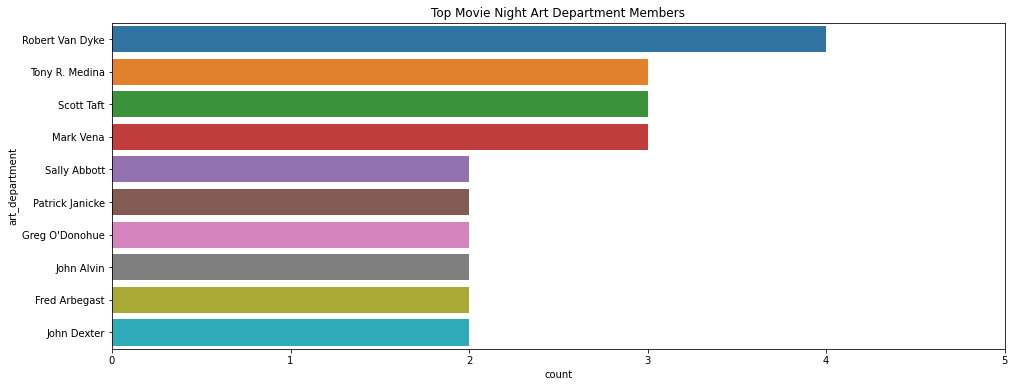

In [88]:
aggregate_countplot('art_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Art Department Members', 
                    figure_name=False)

### Sound Department

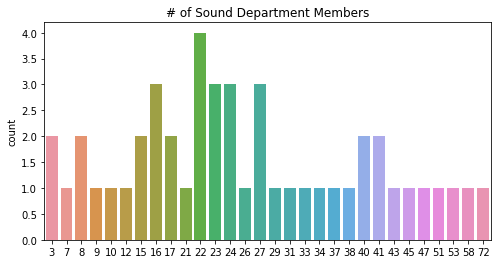

In [89]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['sound_department_count'].values)
plt.title('# of Sound Department Members')
plt.show()

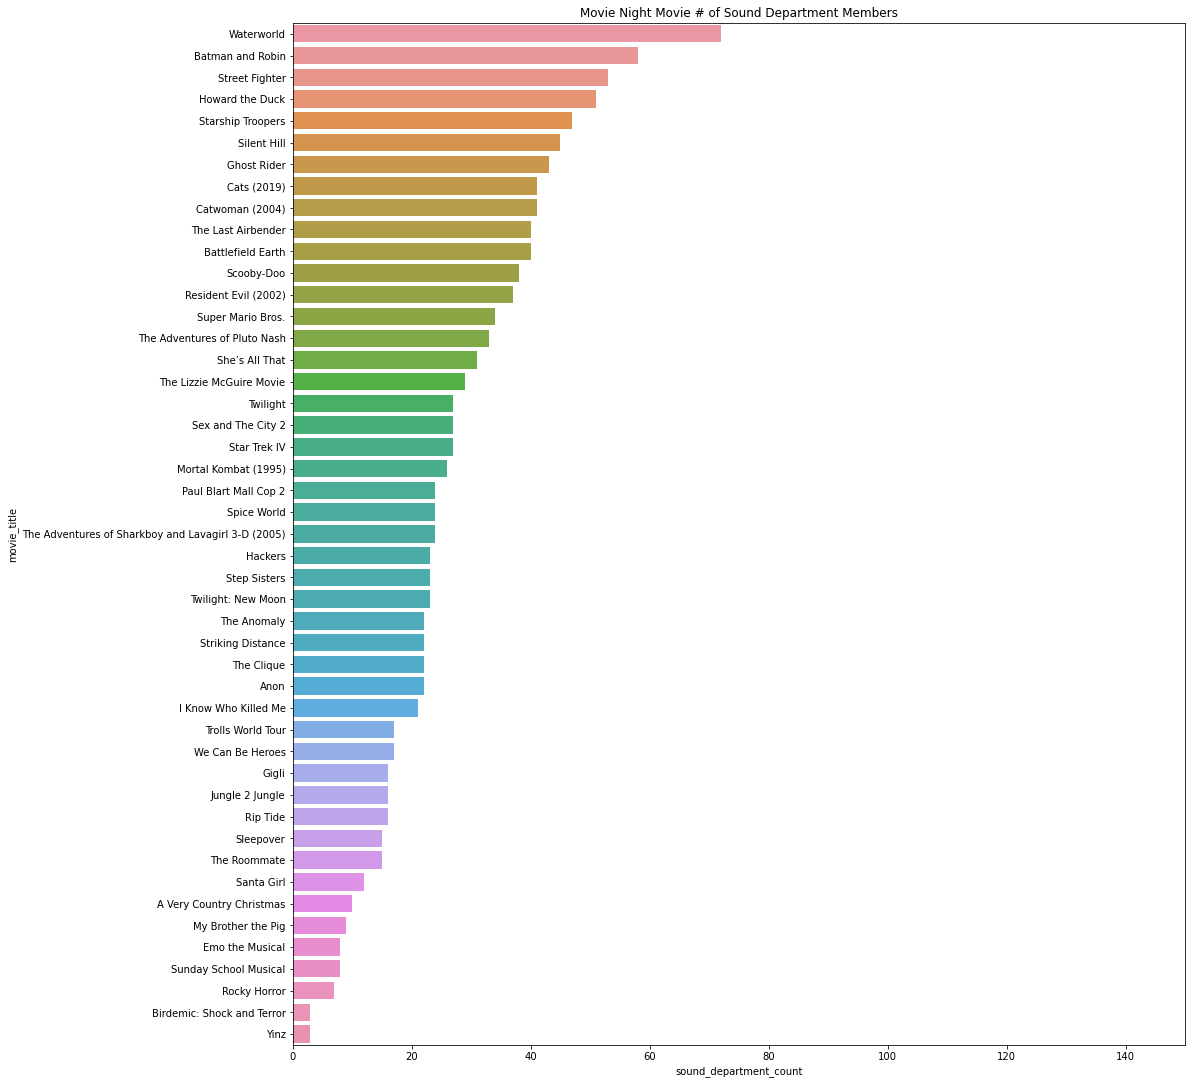

In [90]:
sorted_countplot('sound_department_count', 
                 movie_df, 
                 plot_range=[0,150], 
                 num_items=False, 
                 title='Movie Night Movie # of Sound Department Members', 
                 figure_name=False, 
                 ascending=False)

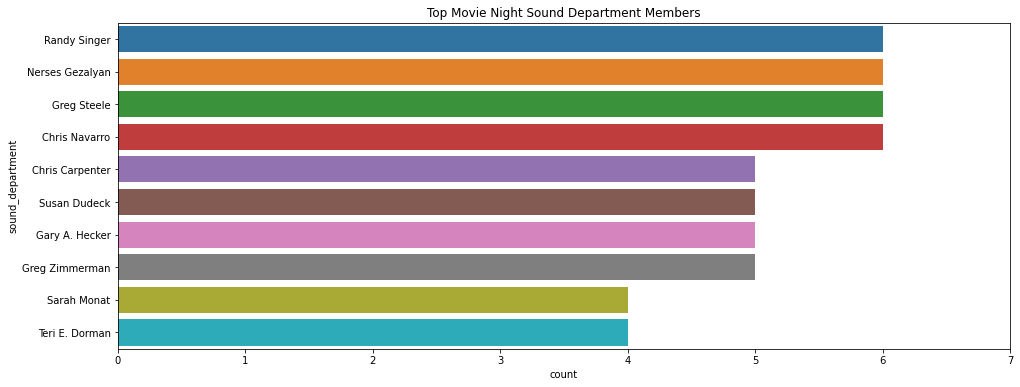

In [91]:
aggregate_countplot('sound_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,7],
                    title='Top Movie Night Sound Department Members', 
                    figure_name=False)

### Special Effects

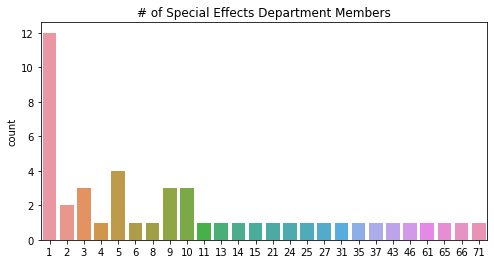

In [92]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['special_effects_count'].values)
plt.title('# of Special Effects Department Members')
plt.show()

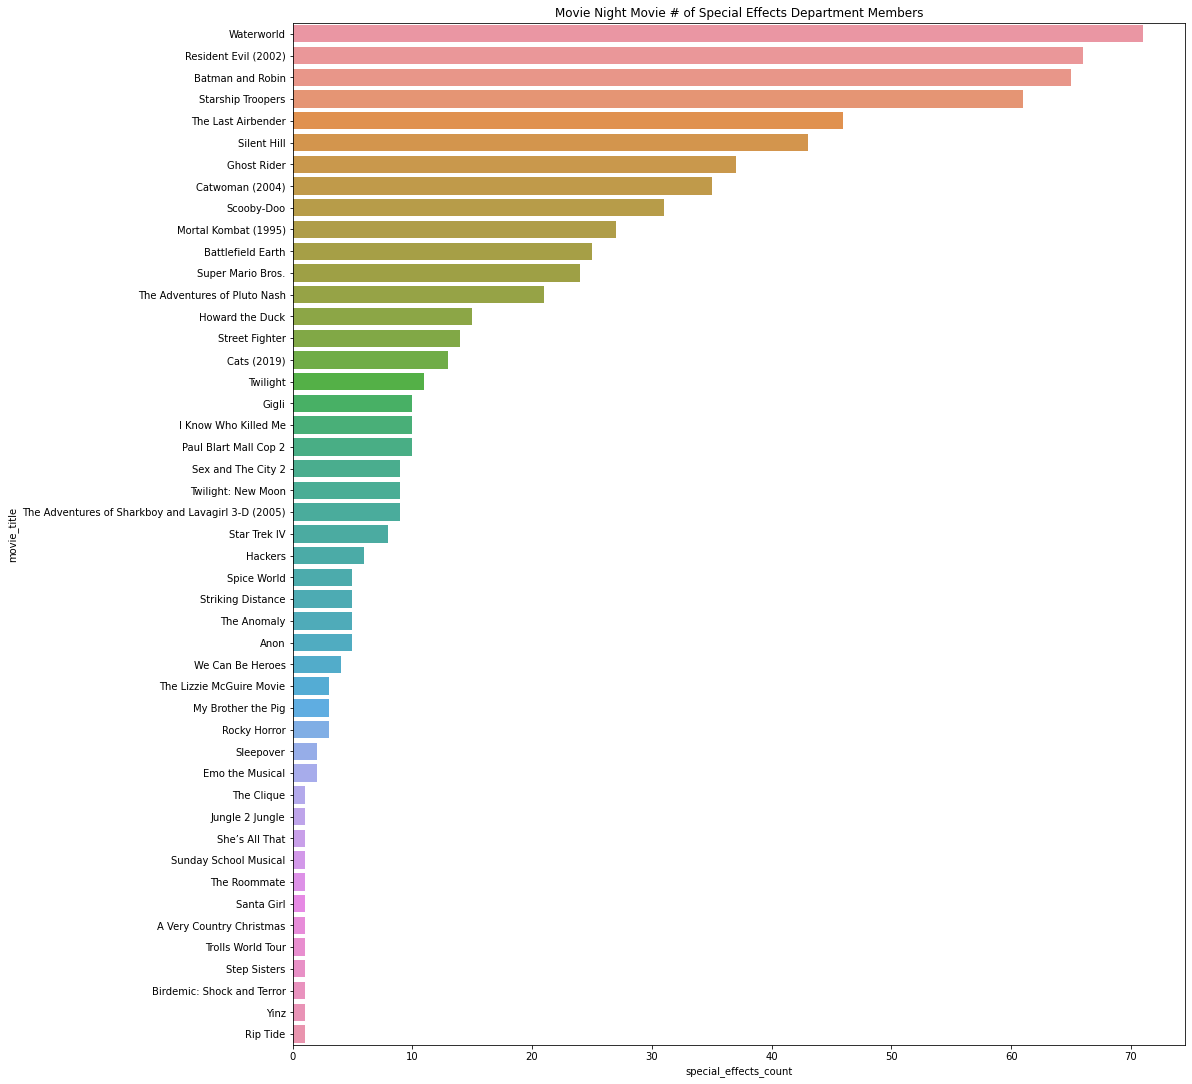

In [93]:
sorted_countplot('special_effects_count', 
                 movie_df,  
                 num_items=False, 
                 title='Movie Night Movie # of Special Effects Department Members', 
                 figure_name=False, 
                 ascending=False)

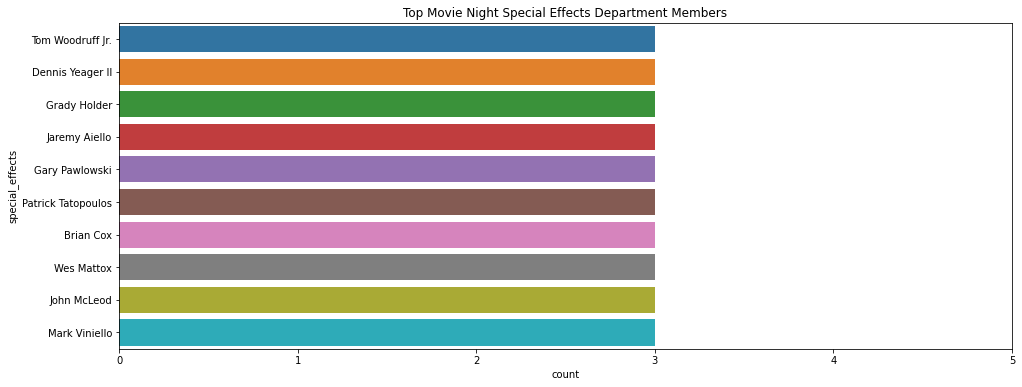

In [94]:
aggregate_countplot('special_effects',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Special Effects Department Members', 
                    figure_name=False)

### Visual Effects

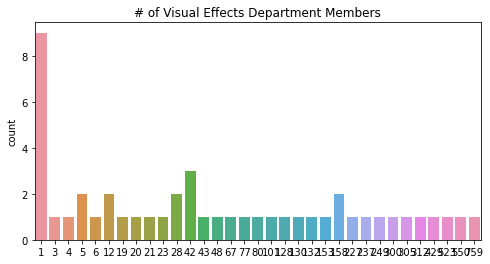

In [95]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['visual_effects_count'].values)
plt.title('# of Visual Effects Department Members')
plt.show()

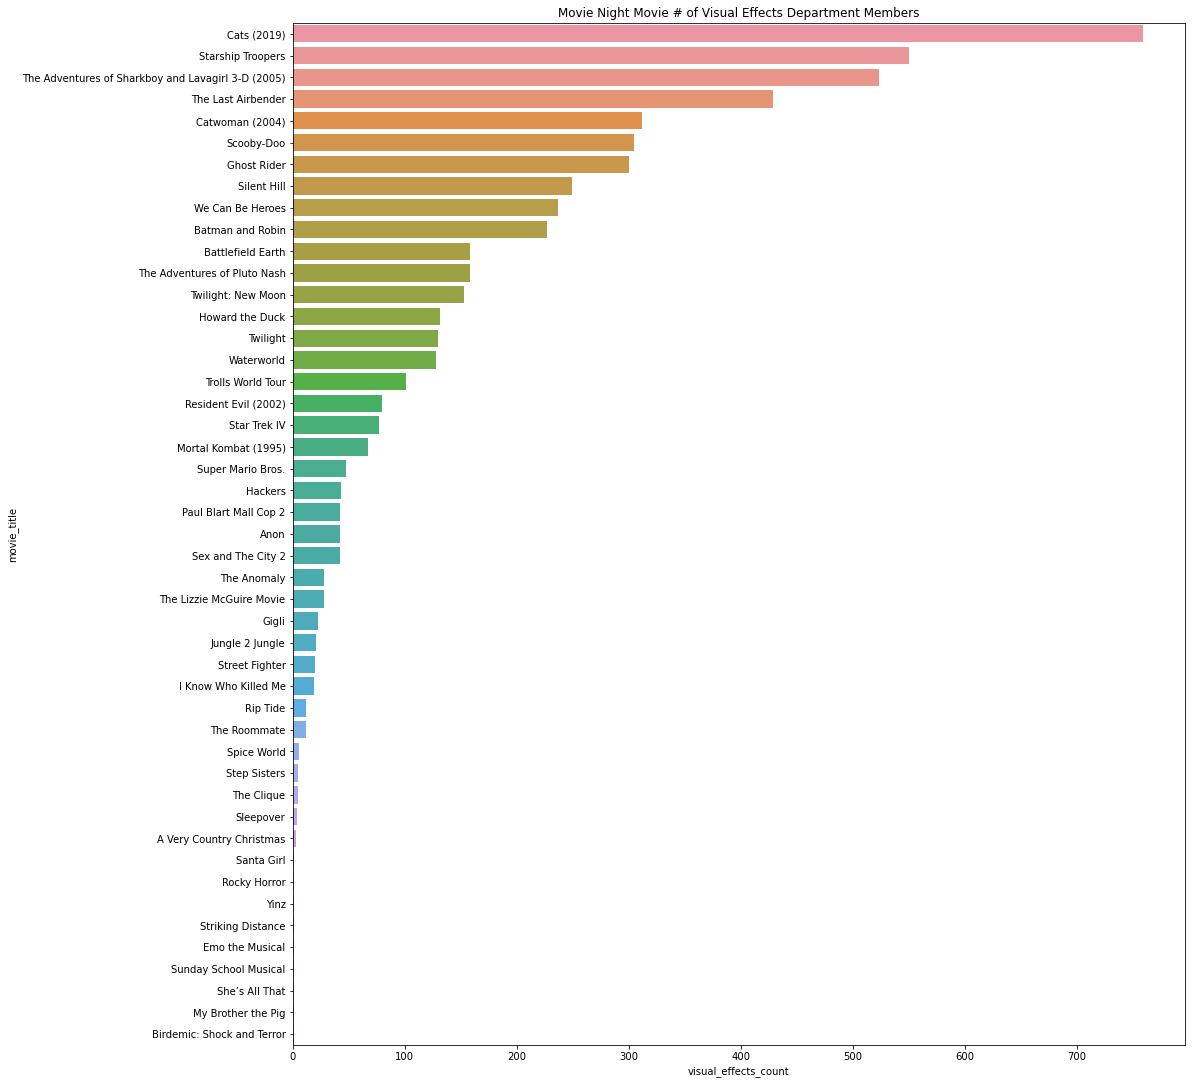

In [96]:
sorted_countplot('visual_effects_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Visual Effects Department Members', 
                 figure_name=False, 
                 ascending=False)

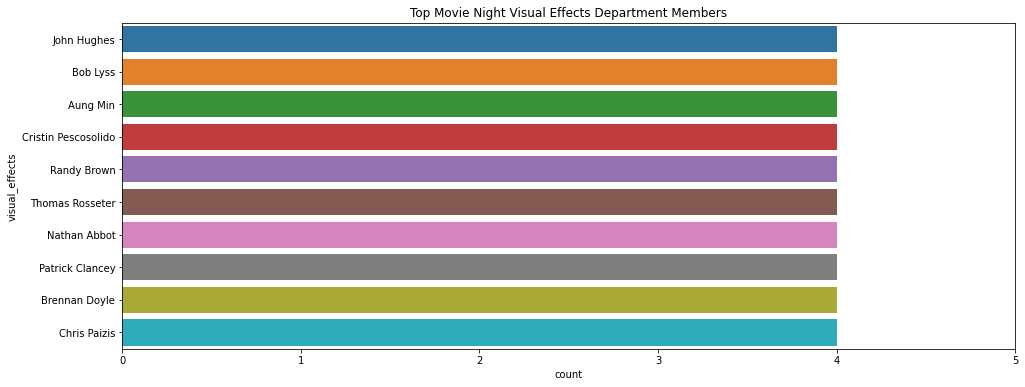

In [97]:
aggregate_countplot('visual_effects',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Visual Effects Department Members', 
                    figure_name=False)

### Stunts

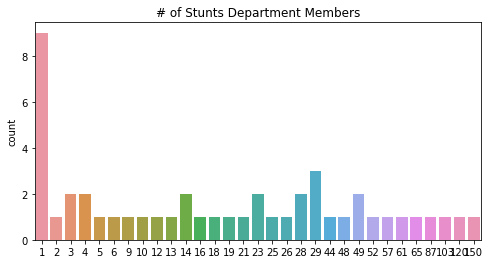

In [98]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['stunts_count'].values)
plt.title('# of Stunts Department Members')
plt.show()

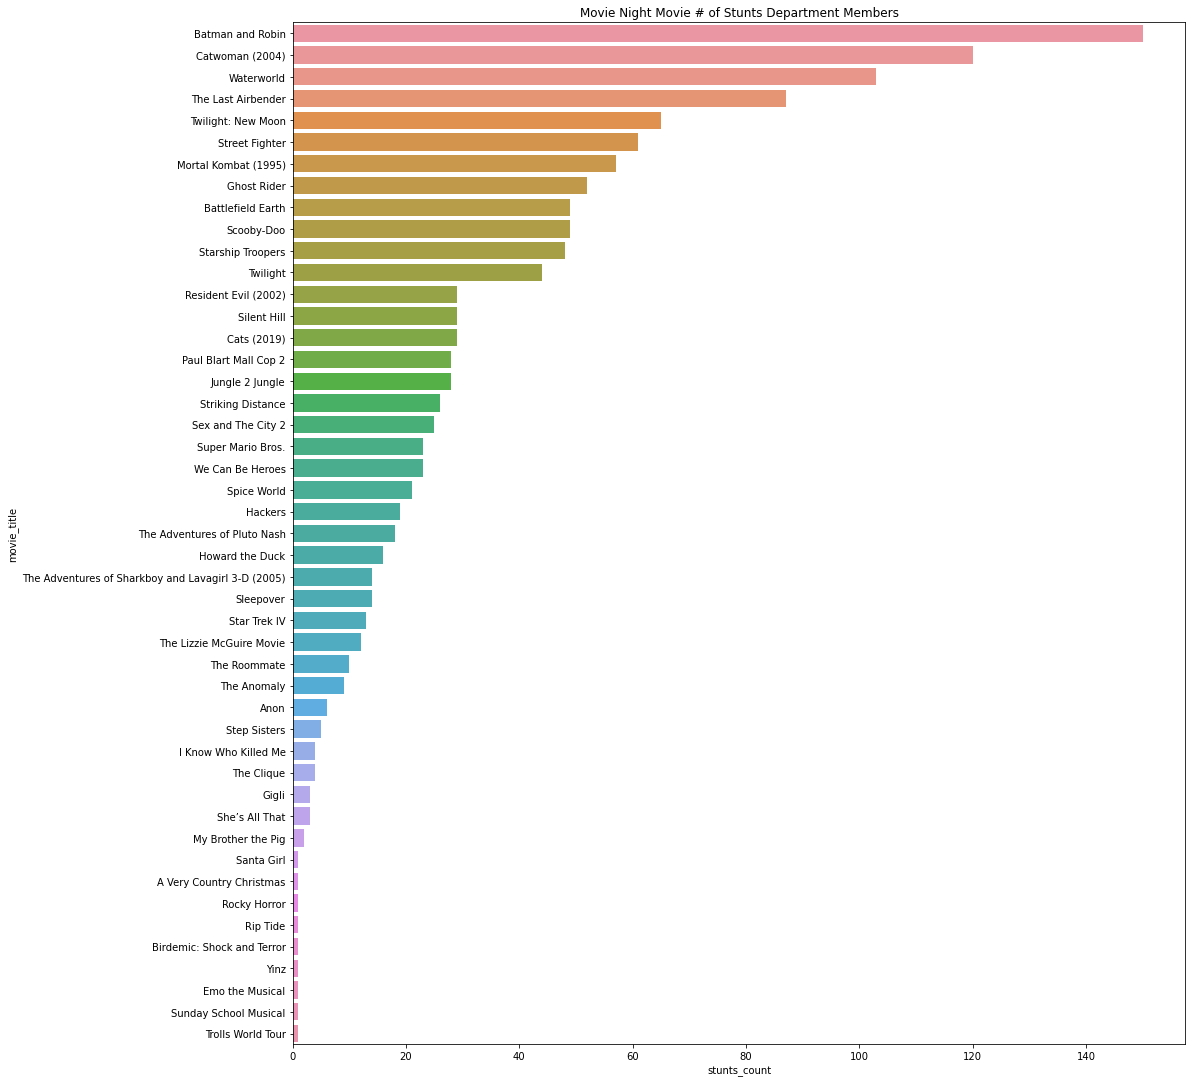

In [99]:
sorted_countplot('stunts_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Stunts Department Members', 
                 figure_name=False, 
                 ascending=False)

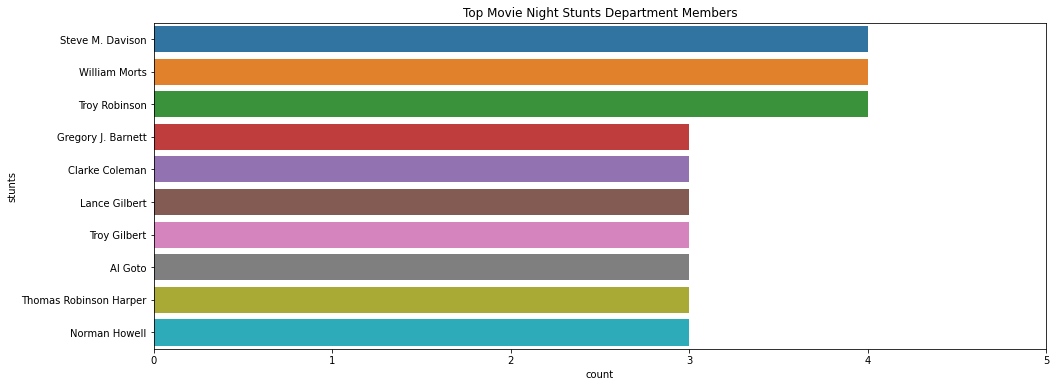

In [100]:
aggregate_countplot('stunts',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Stunts Department Members', 
                    figure_name=False)

### Camera Department

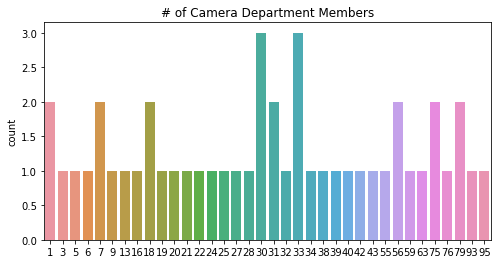

In [101]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['camera_department_count'].values)
plt.title('# of Camera Department Members')
plt.show()

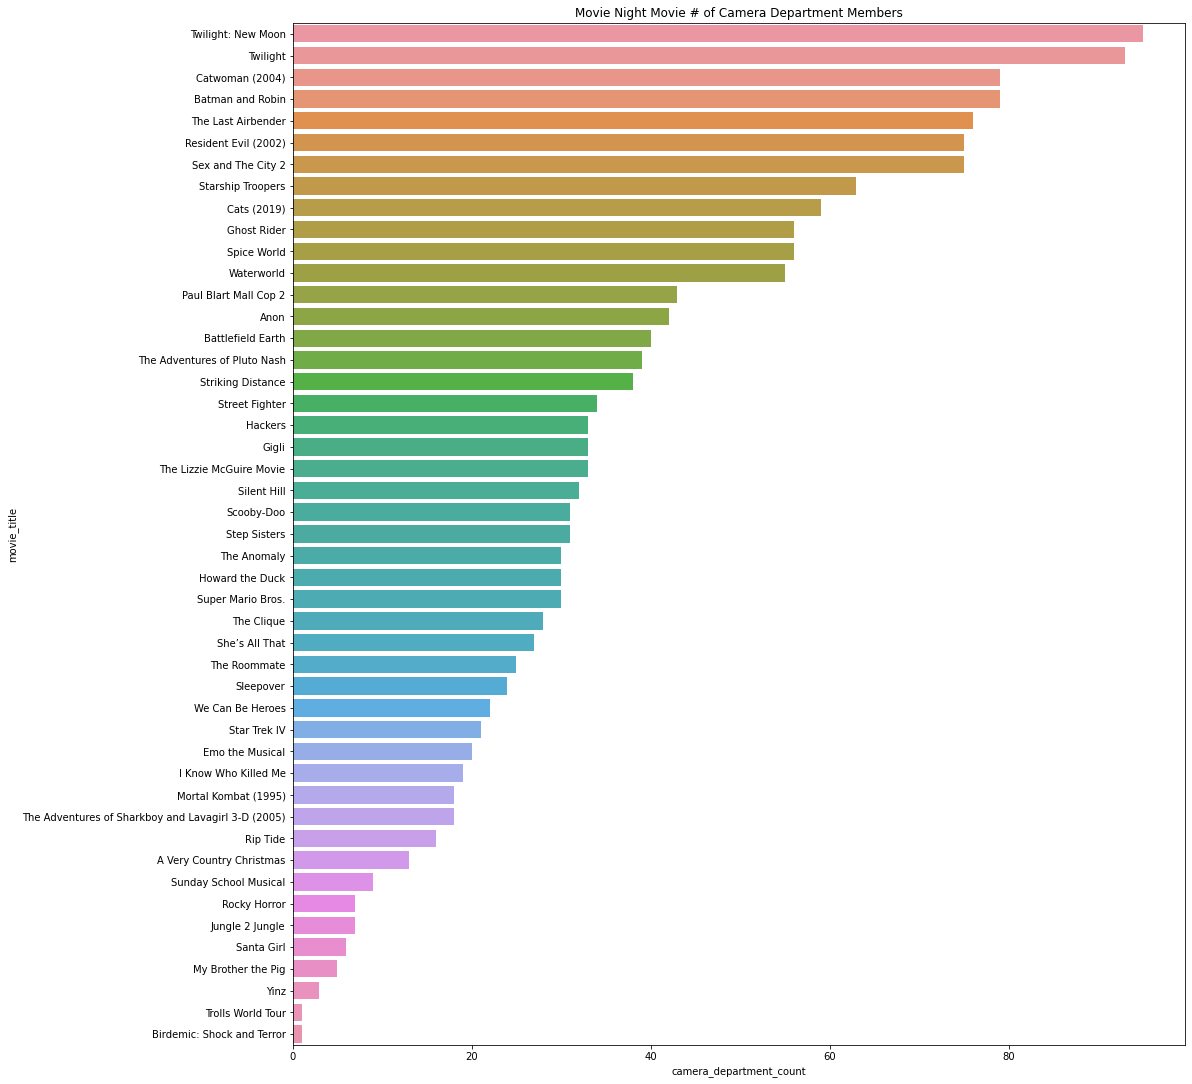

In [102]:
sorted_countplot('camera_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Camera Department Members', 
                 figure_name=False, 
                 ascending=False)

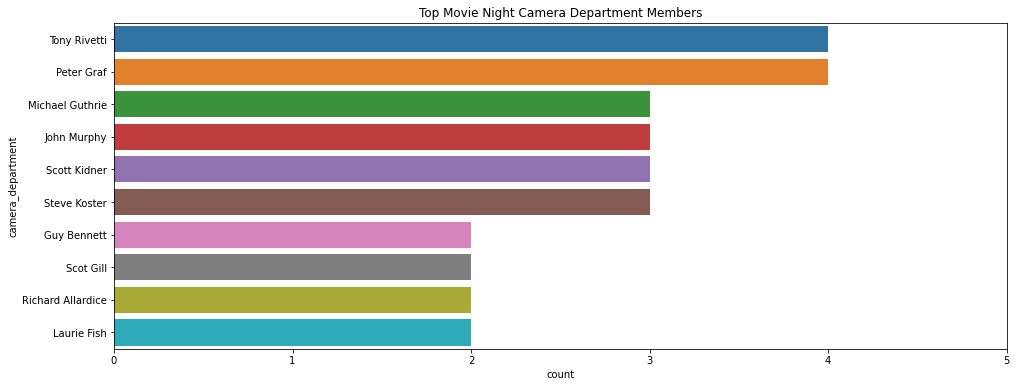

In [103]:
aggregate_countplot('camera_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Camera Department Members', 
                    figure_name=False)

### Animation Department 

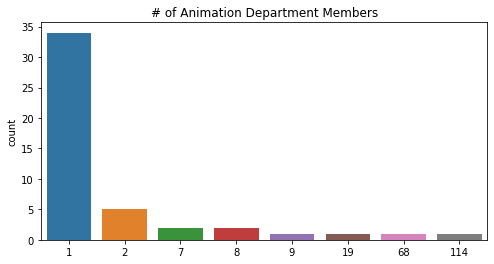

In [104]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['animation_department_count'].values)
plt.title('# of Animation Department Members')
plt.show()

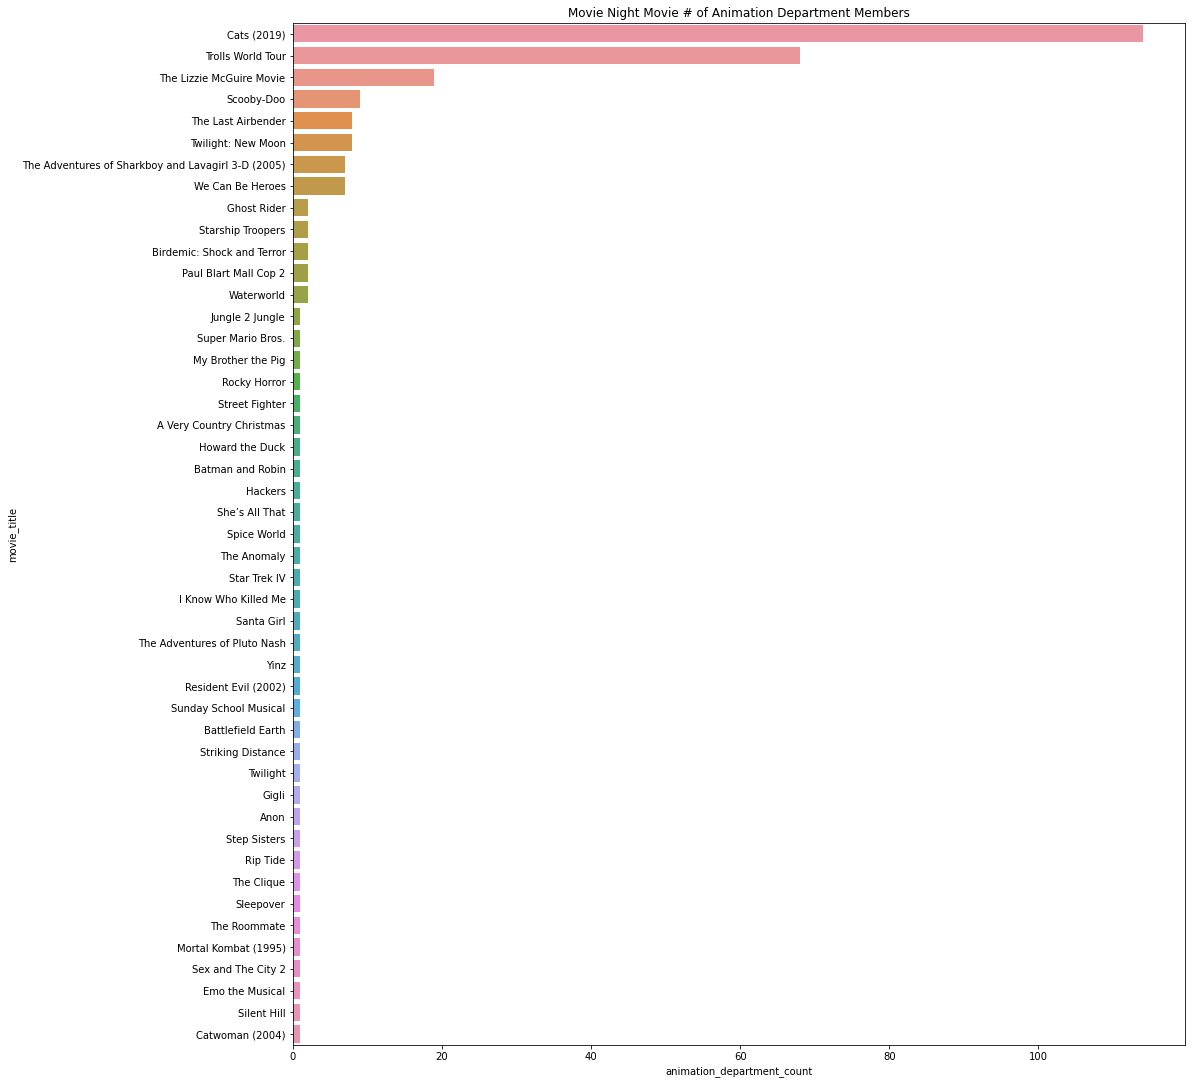

In [105]:
sorted_countplot('animation_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Animation Department Members', 
                 figure_name=False, 
                 ascending=False)

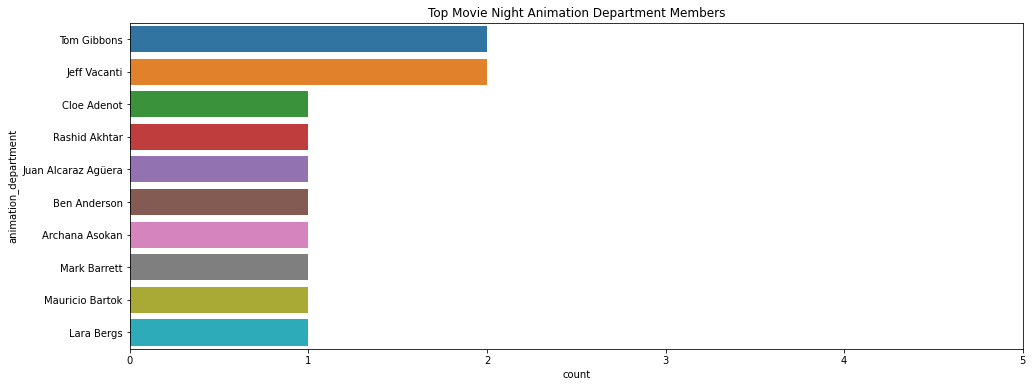

In [106]:
aggregate_countplot('animation_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Animation Department Members', 
                    figure_name=False)

### Casting Department

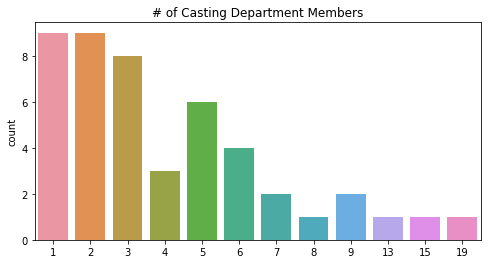

In [107]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['casting_department_count'].values)
plt.title('# of Casting Department Members')
plt.show()

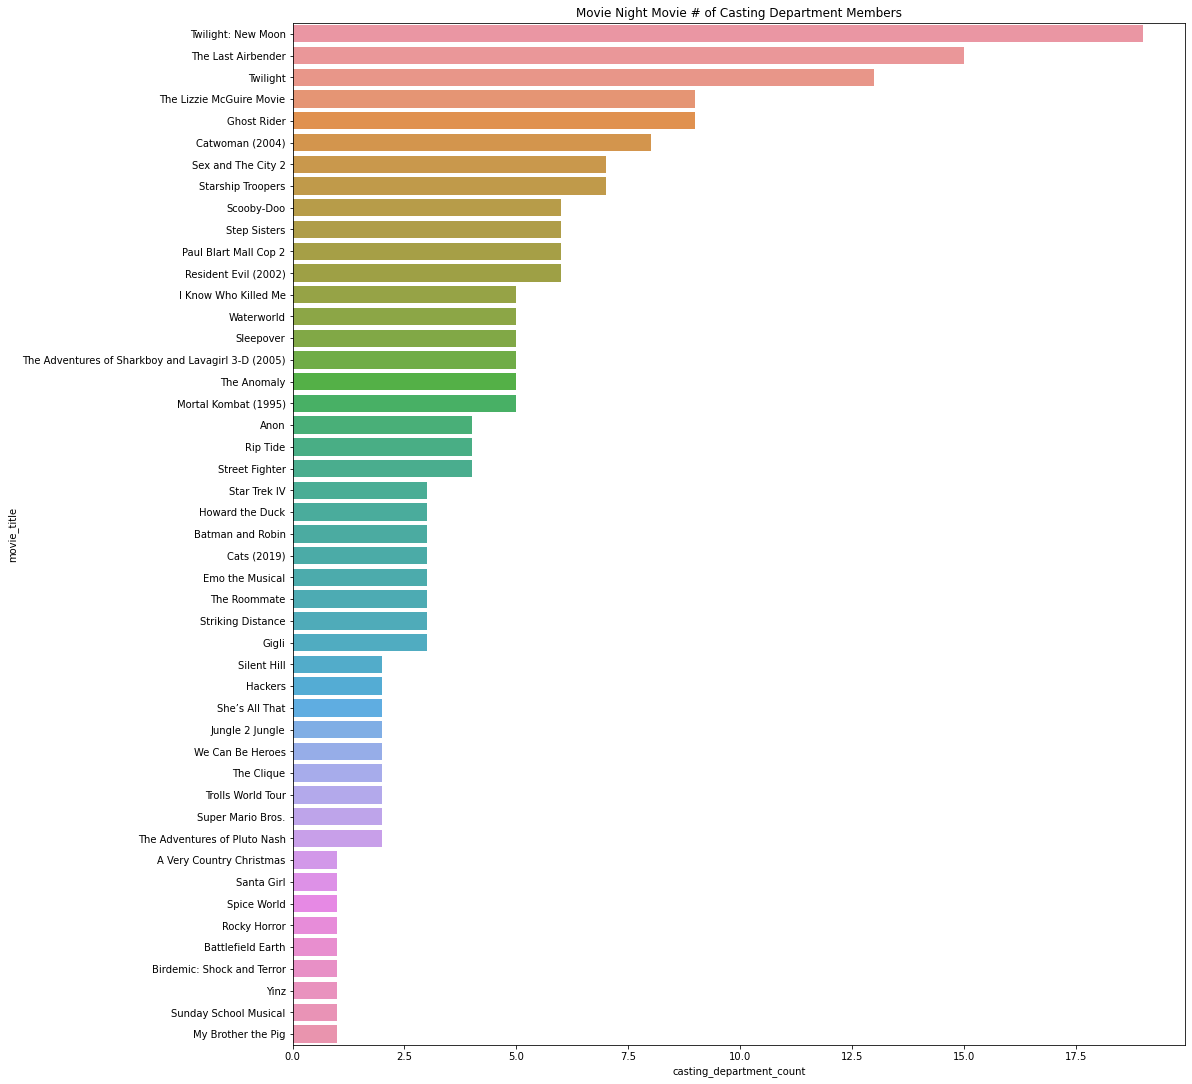

In [108]:
sorted_countplot('casting_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Casting Department Members', 
                 figure_name=False, 
                 ascending=False)

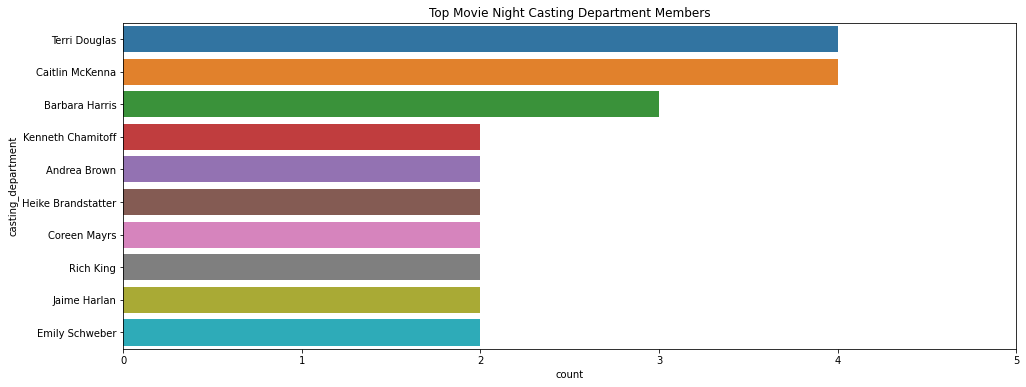

In [109]:
aggregate_countplot('casting_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Casting Department Members', 
                    figure_name=False)

### Costume Department

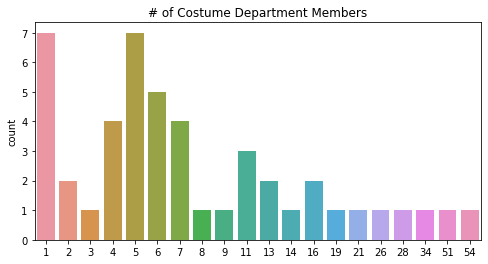

In [110]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['costume_departmen_count'].values)
plt.title('# of Costume Department Members')
plt.show()

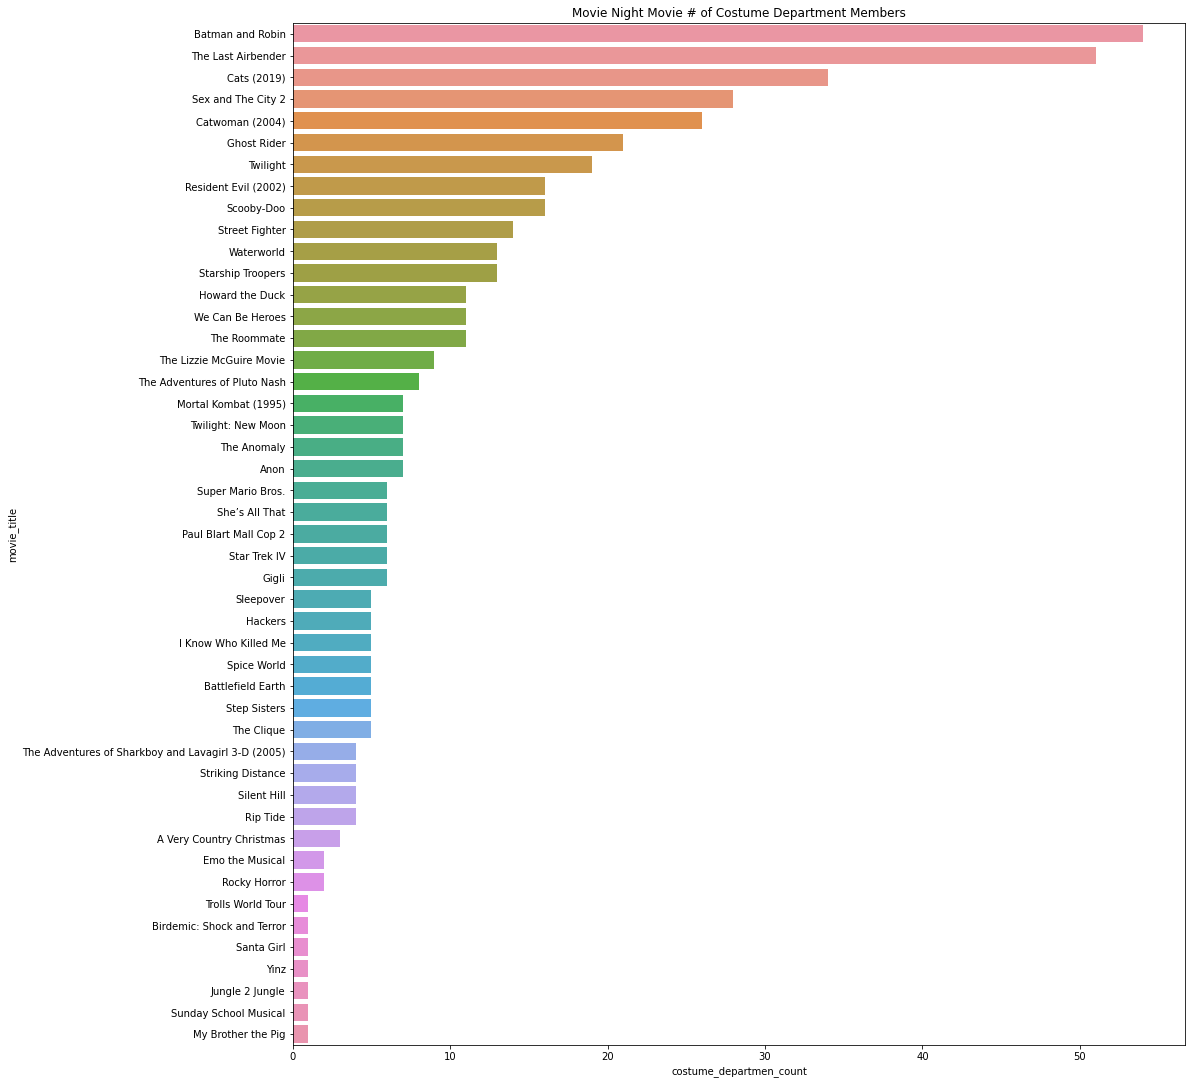

In [111]:
sorted_countplot('costume_departmen_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Costume Department Members', 
                 figure_name=False, 
                 ascending=False)

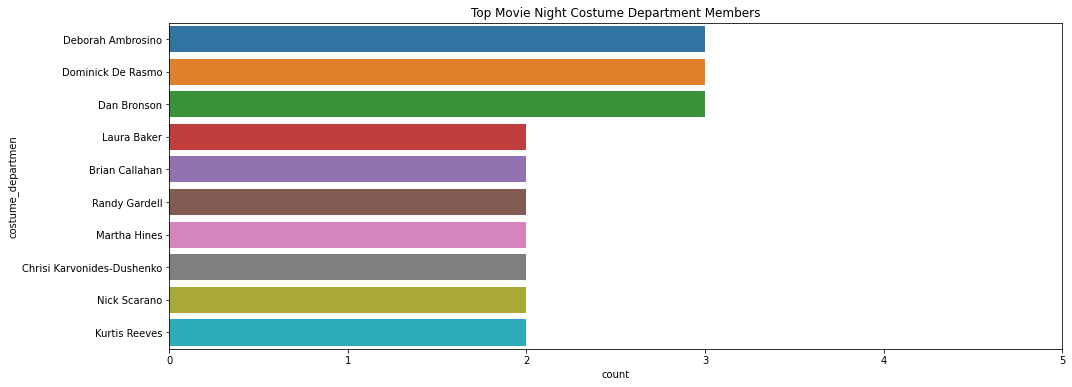

In [112]:
aggregate_countplot('costume_departmen',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Costume Department Members', 
                    figure_name=False)

### Location Management 

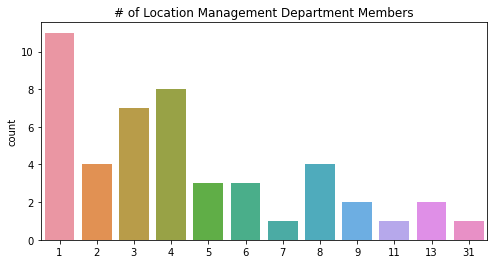

In [113]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['location_management_count'].values)
plt.title('# of Location Management Department Members')
plt.show()

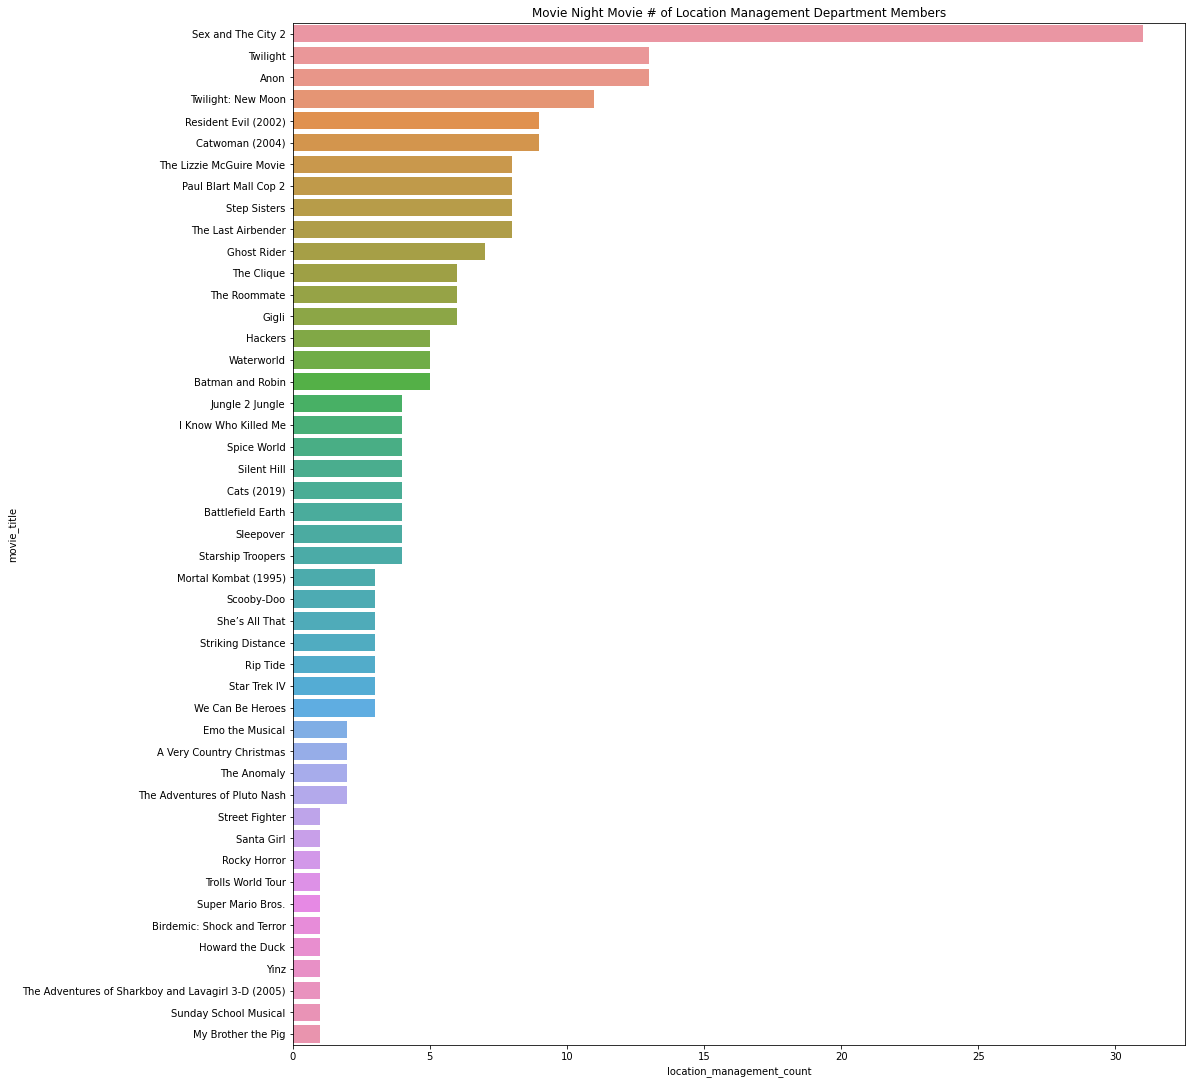

In [114]:
sorted_countplot('location_management_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Location Management Department Members', 
                 figure_name=False, 
                 ascending=False)

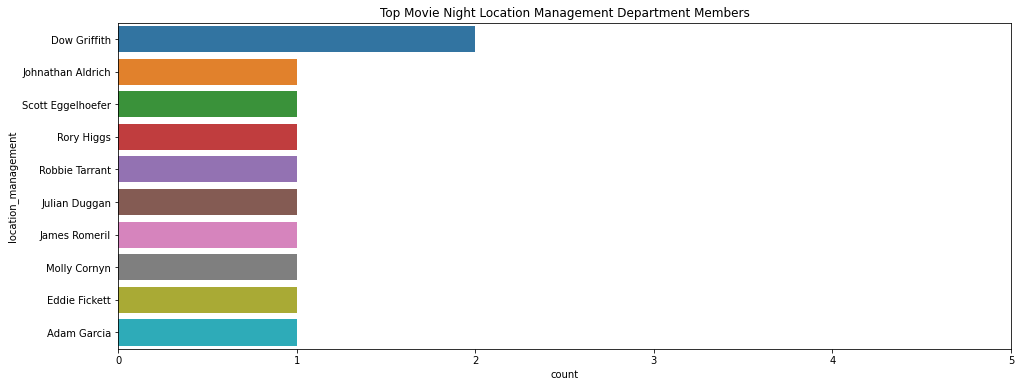

In [115]:
aggregate_countplot('location_management',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Location Management Department Members', 
                    figure_name=False)

### Music Department

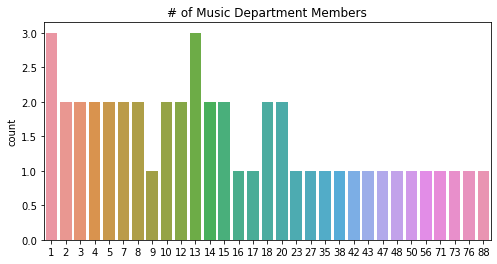

In [116]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['music_department_count'].values)
plt.title('# of Music Department Members')
plt.show()

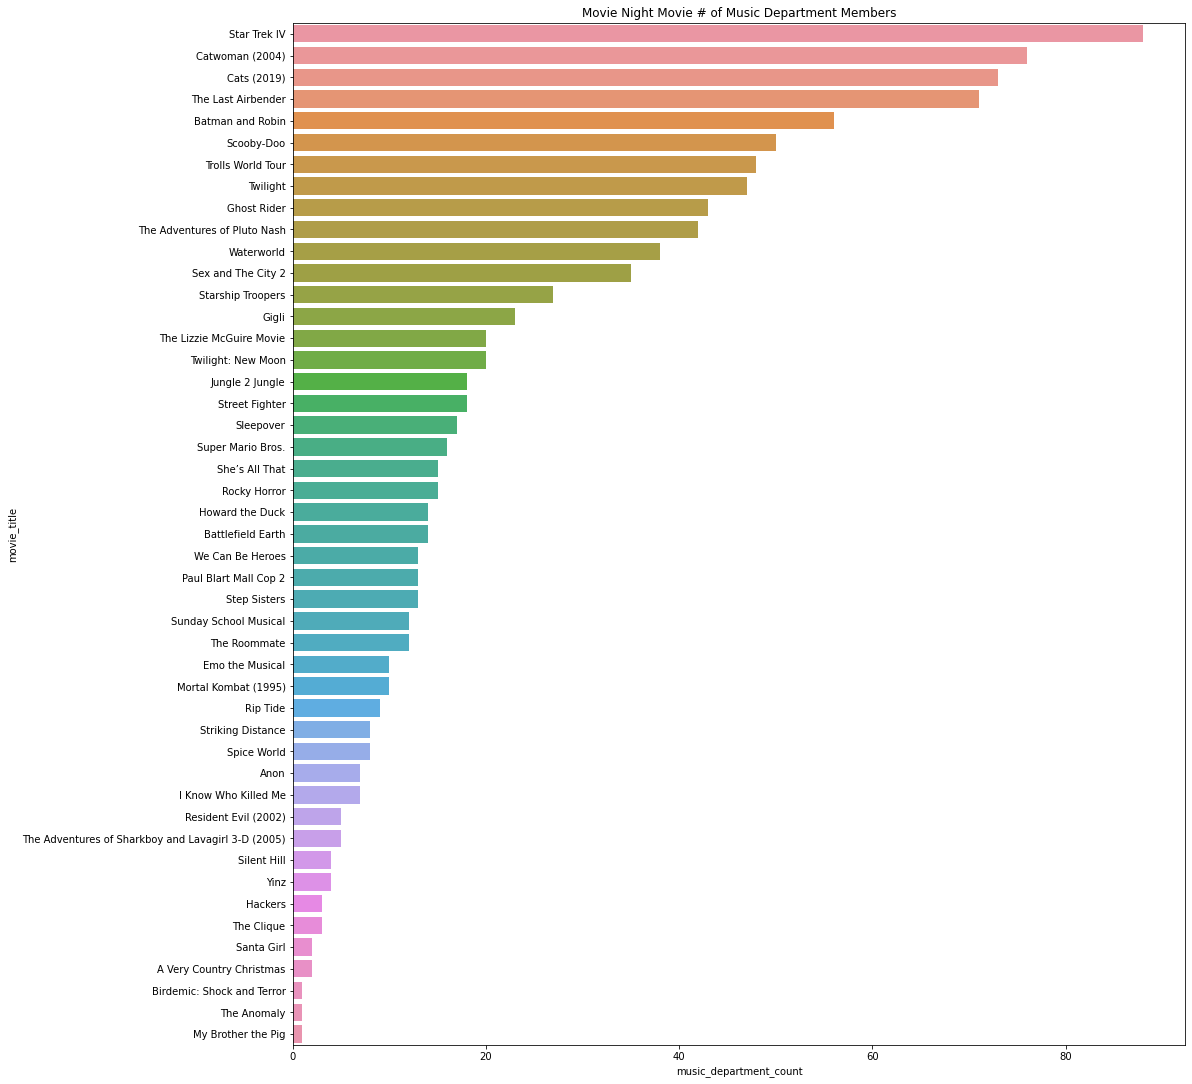

In [117]:
sorted_countplot('music_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Music Department Members', 
                 figure_name=False, 
                 ascending=False)

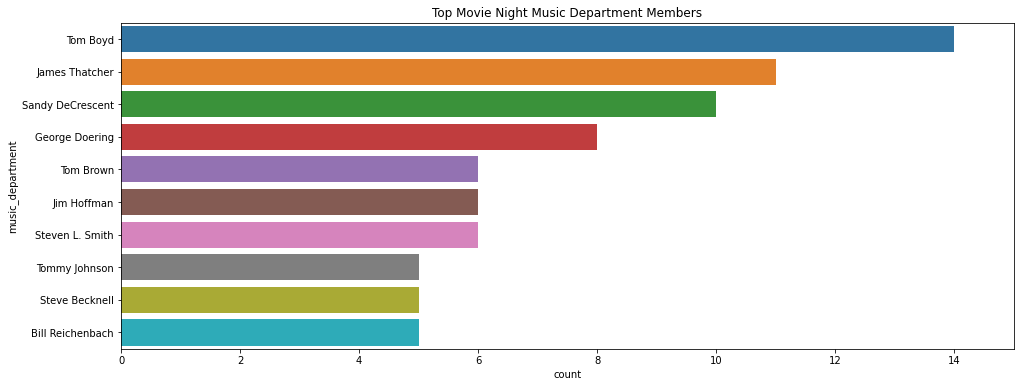

In [118]:
aggregate_countplot('music_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,15],
                    title='Top Movie Night Music Department Members', 
                    figure_name=False)

### Script Department

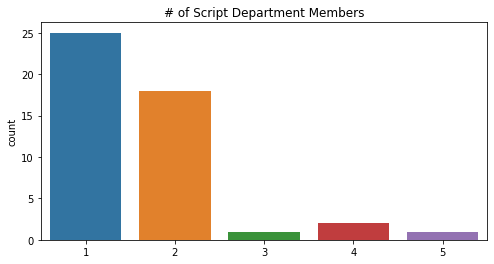

In [119]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['script_department_count'].values)
plt.title('# of Script Department Members')
plt.show()

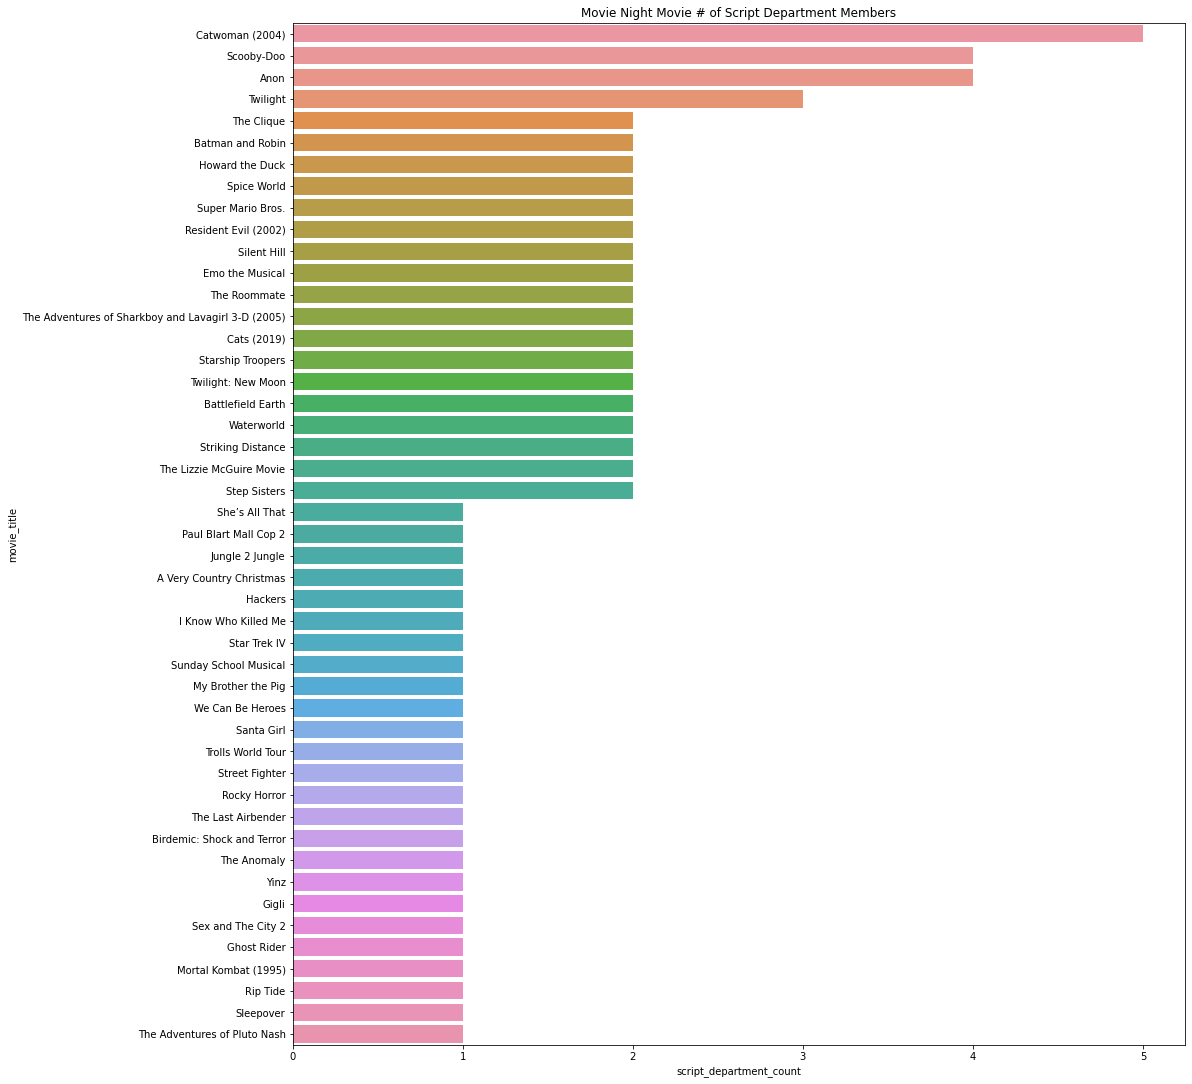

In [120]:
sorted_countplot('script_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Script Department Members', 
                 figure_name=False, 
                 ascending=False)

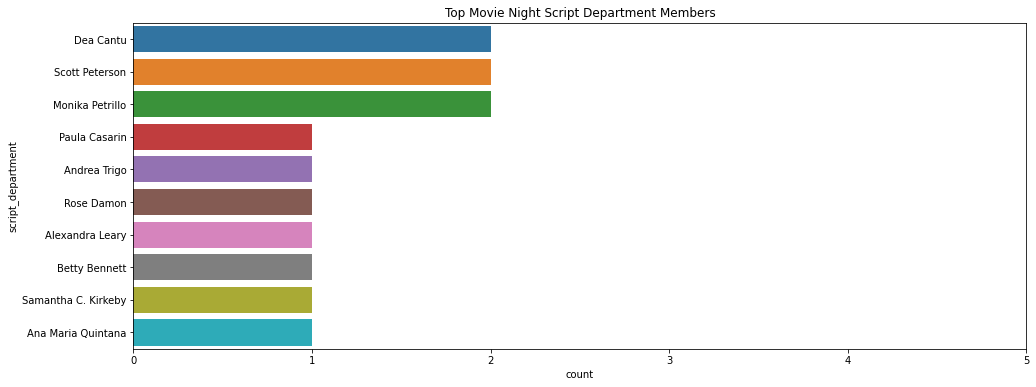

In [121]:
aggregate_countplot('script_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Script Department Members', 
                    figure_name=False)

### Transportation Department

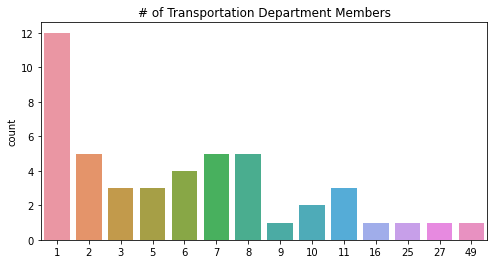

In [122]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['transportation_department_count'].values)
plt.title('# of Transportation Department Members')
plt.show()

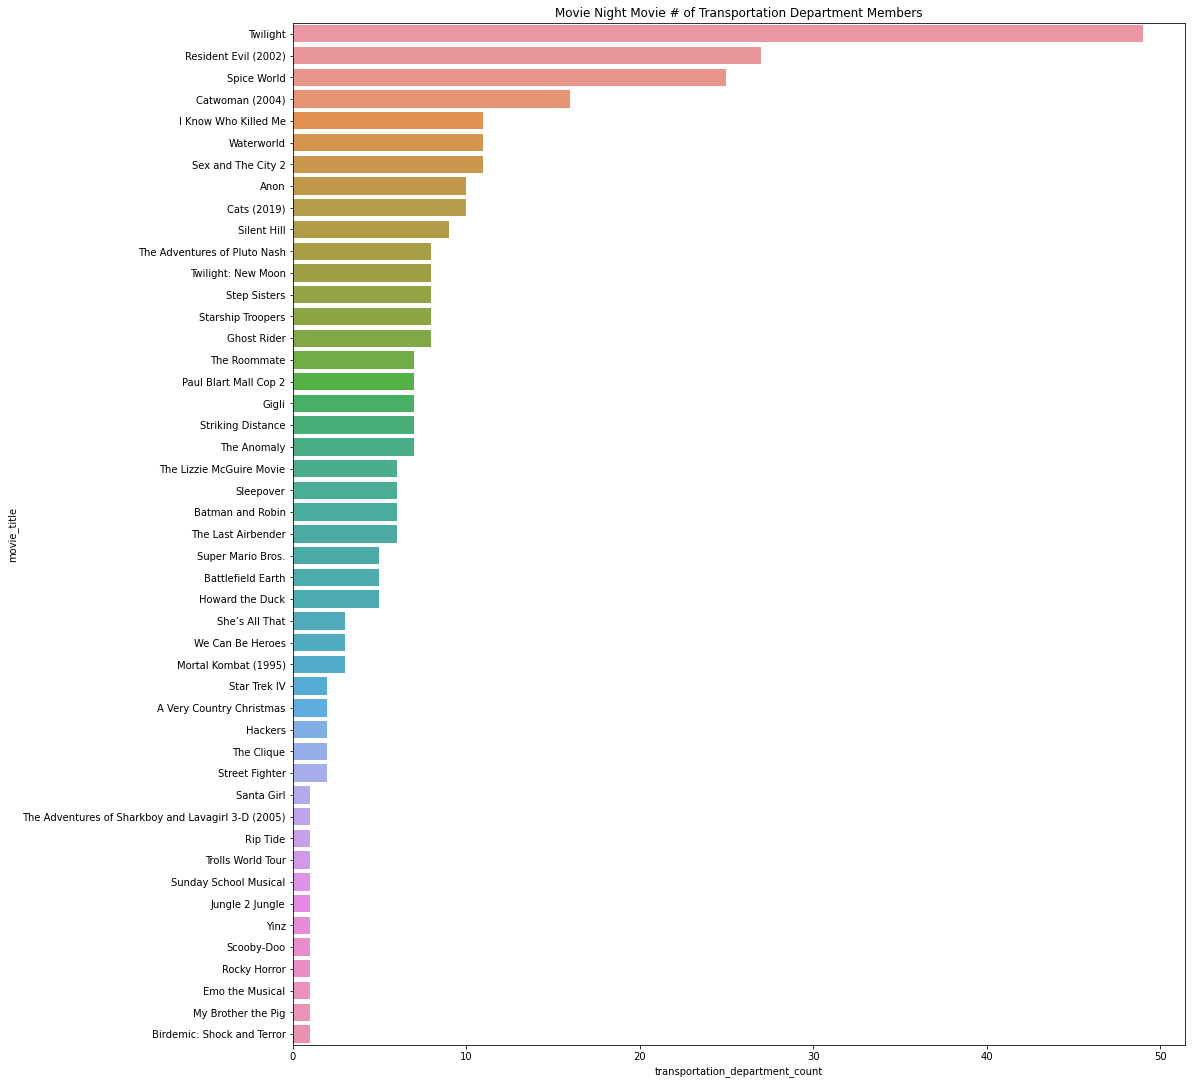

In [123]:
sorted_countplot('transportation_department_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Transportation Department Members', 
                 figure_name=False, 
                 ascending=False)

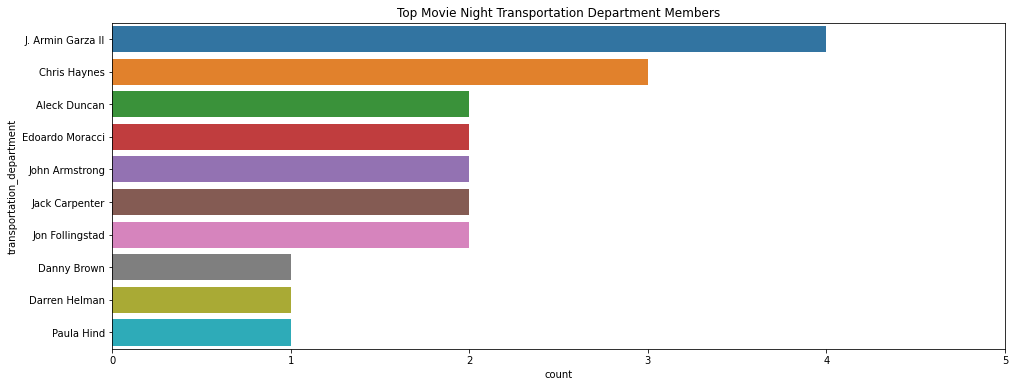

In [124]:
aggregate_countplot('transportation_department',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Transportation Department Members', 
                    figure_name=False)

### Miscellaneous

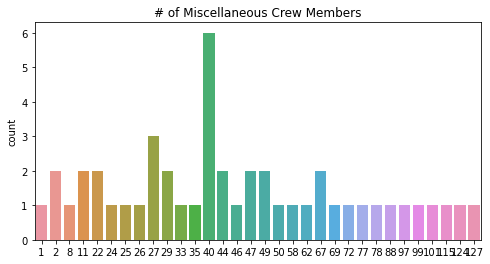

In [125]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['miscellaneous_count'].values)
plt.title('# of Miscellaneous Crew Members')
plt.show()

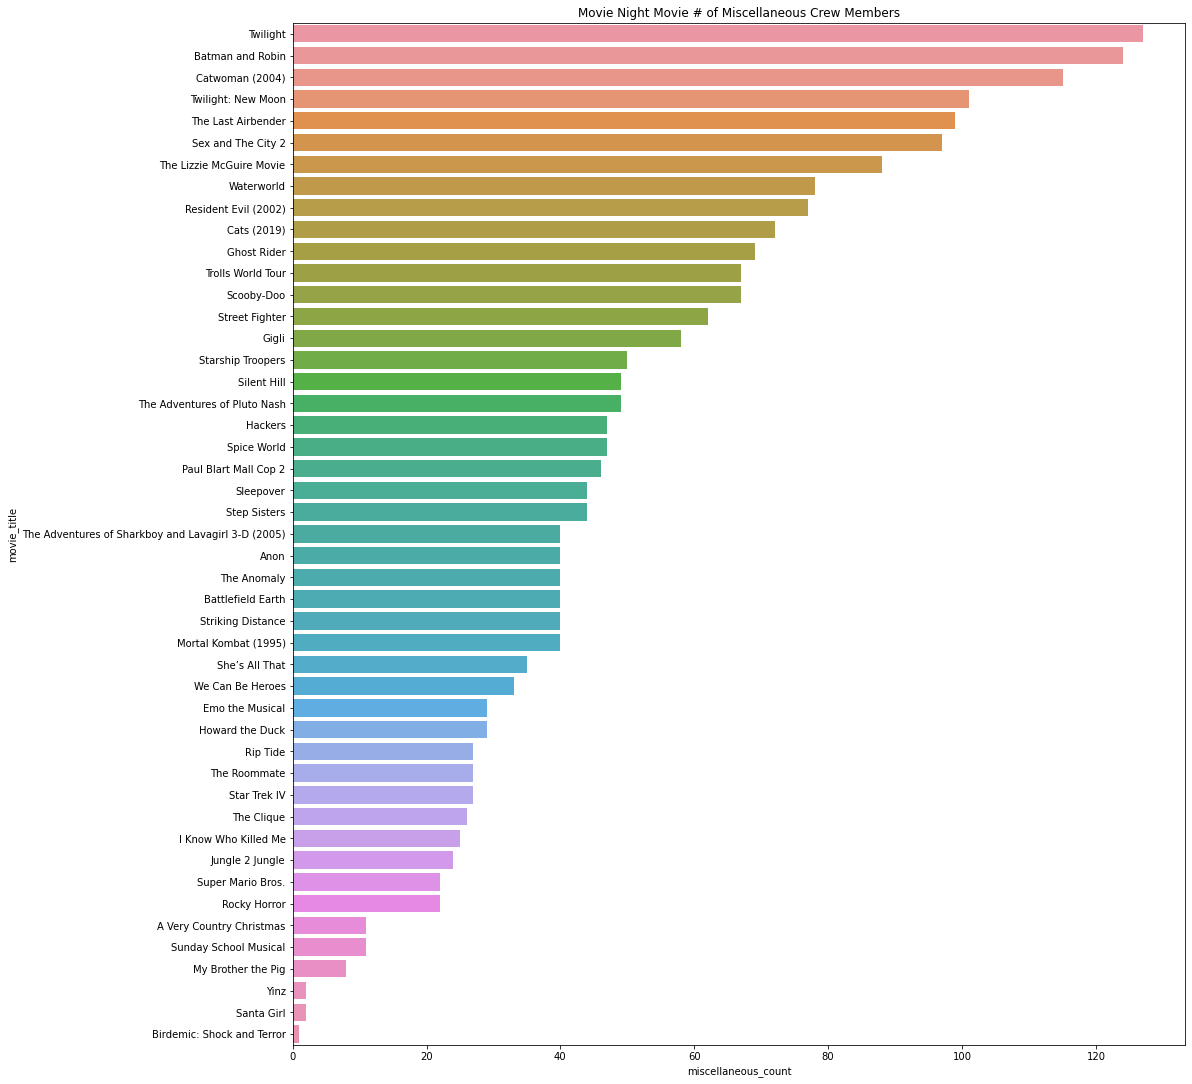

In [126]:
sorted_countplot('miscellaneous_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Miscellaneous Crew Members', 
                 figure_name=False, 
                 ascending=False)

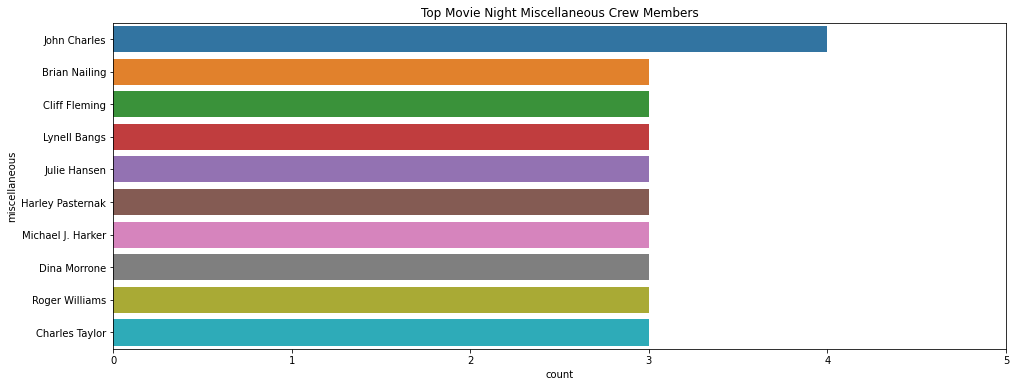

In [127]:
aggregate_countplot('miscellaneous',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,5],
                    title='Top Movie Night Miscellaneous Crew Members', 
                    figure_name=False)

### Total Movie People

In [128]:
count_name_flags = [x + '_count' for x in name_flags]
count_name_flags = [re.sub(' ', '_', x) for x in count_name_flags]

In [129]:
movie_df['total_people'] = movie_df[count_name_flags].sum(axis=1)
top100_df['total_people'] = top100_df[count_name_flags].sum(axis=1)
bottom100_df['total_people'] = bottom100_df[count_name_flags].sum(axis=1)

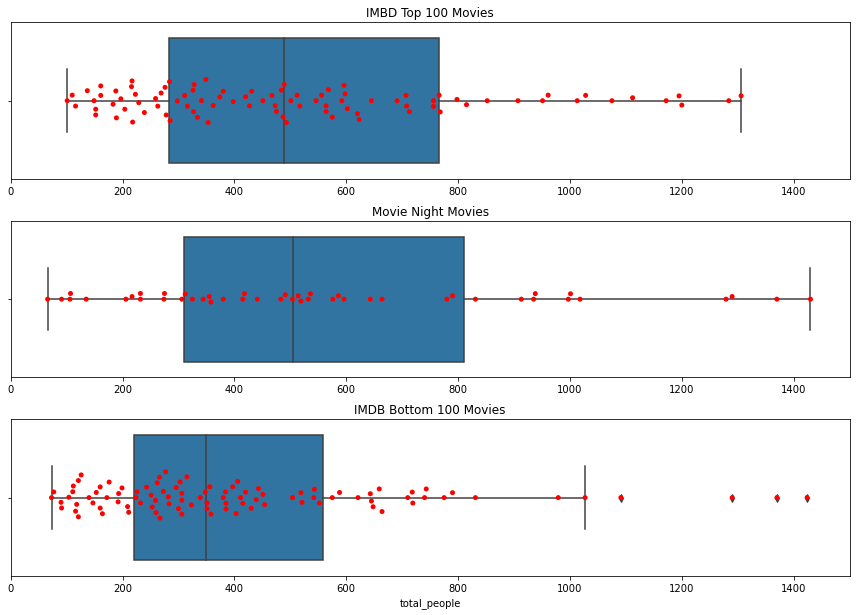

In [130]:
comparative_boxplot('total_people', top100_df, movie_df, bottom100_df, plot_range=[0,1500])

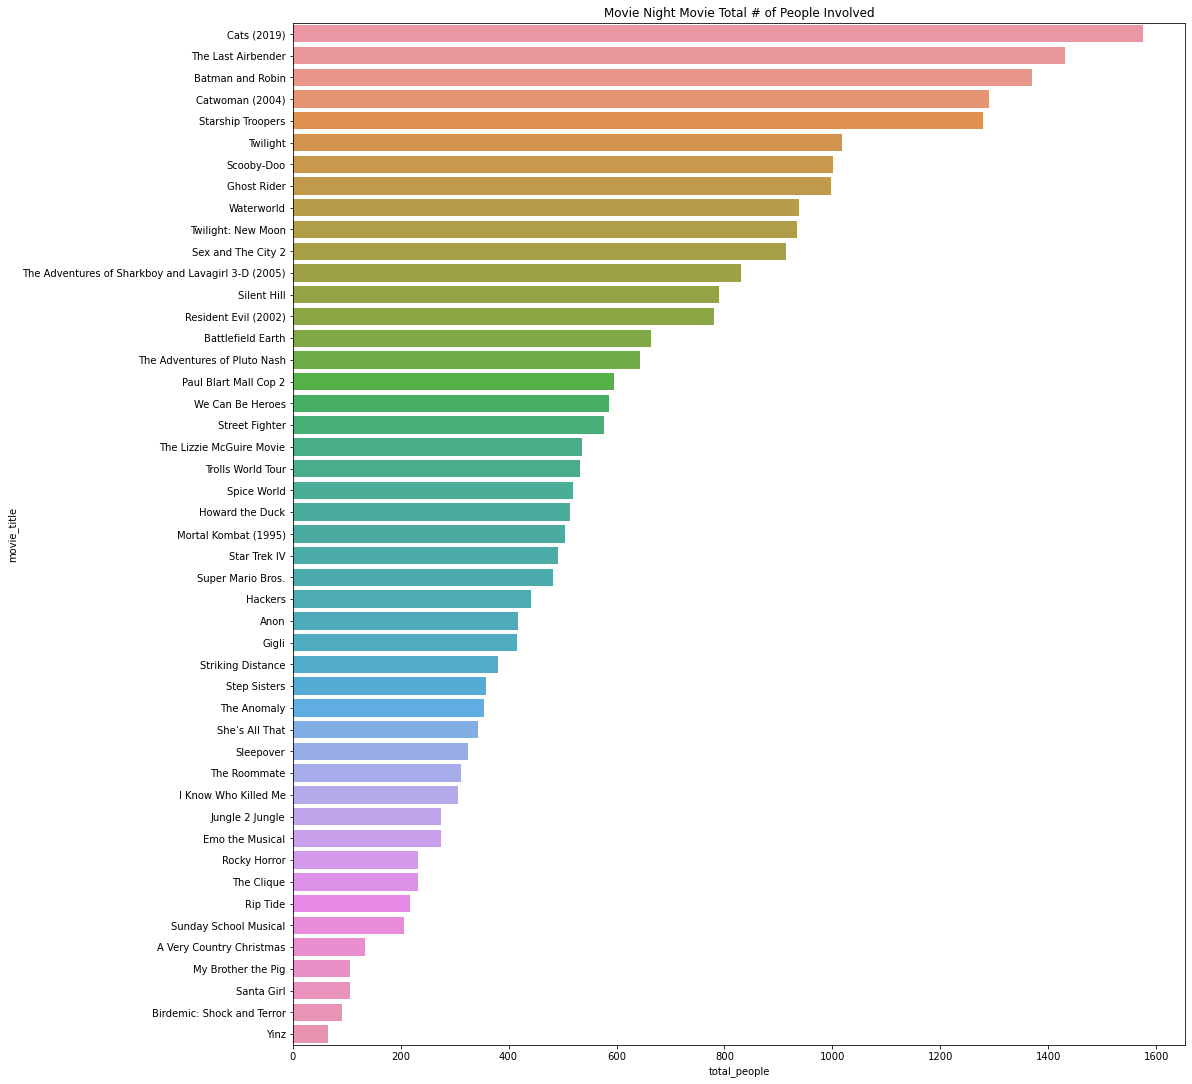

In [131]:
sorted_countplot('total_people', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie Total # of People Involved', 
                 figure_name=False, 
                 ascending=False)

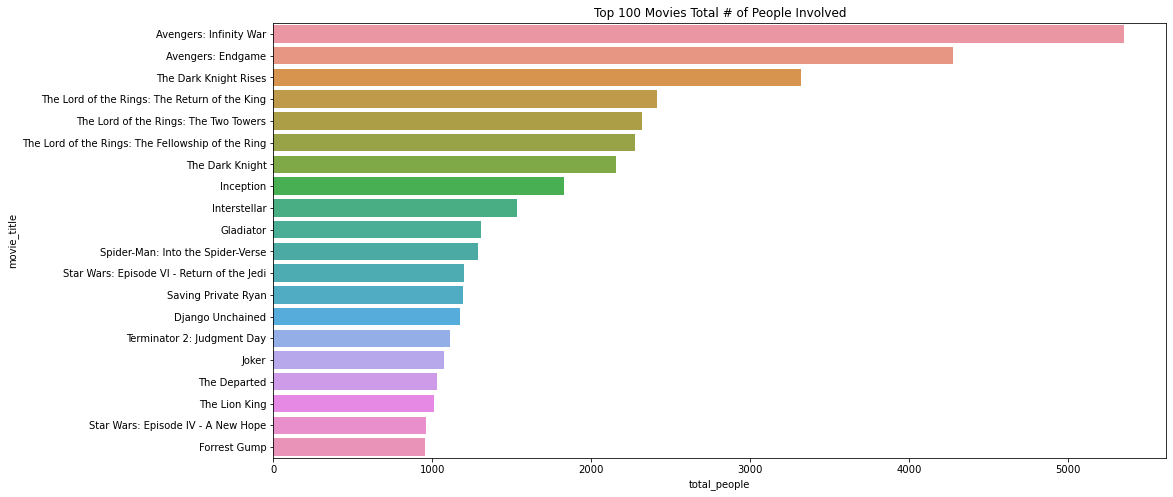

In [132]:
sorted_countplot('total_people', 
                 top100_df, 
                 num_items=20, 
                 title='Top 100 Movies Total # of People Involved', 
                 figure_name=False, 
                 ascending=False)

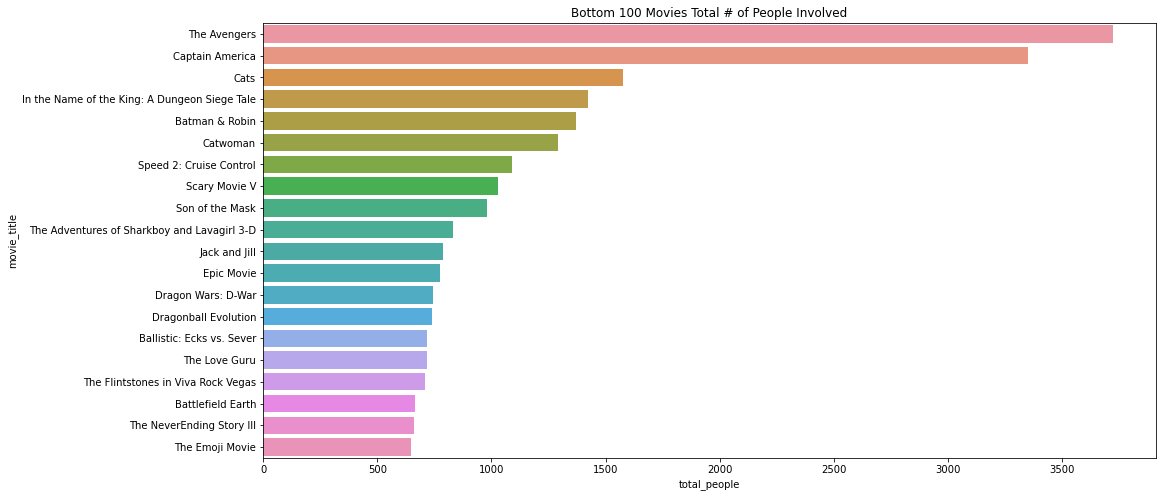

In [133]:
sorted_countplot('total_people', 
                 bottom100_df, 
                 num_items=20, 
                 title='Bottom 100 Movies Total # of People Involved', 
                 figure_name=False, 
                 ascending=False)

## Movie Companies

* Production Companies
* Distributors
* Special Effects Companies
* Other Companies

### Production Companies

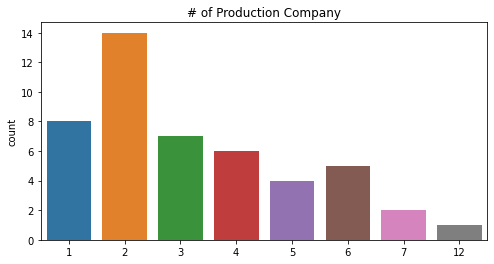

In [134]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['production_companies_count'].values)
plt.title('# of Production Company')
plt.show()

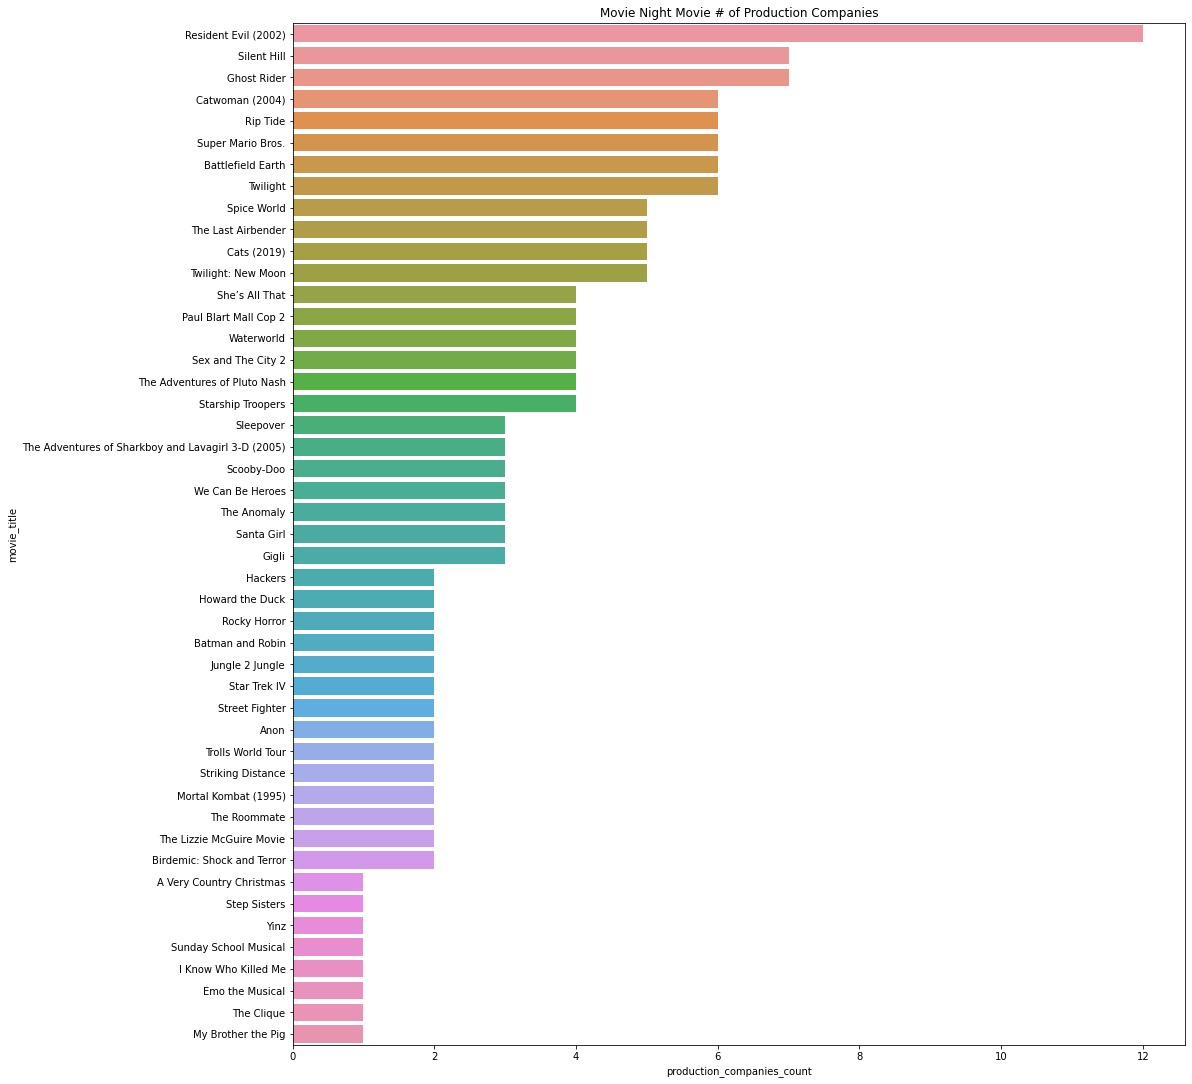

In [135]:
sorted_countplot('production_companies_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Production Companies', 
                 figure_name=False, 
                 ascending=False)

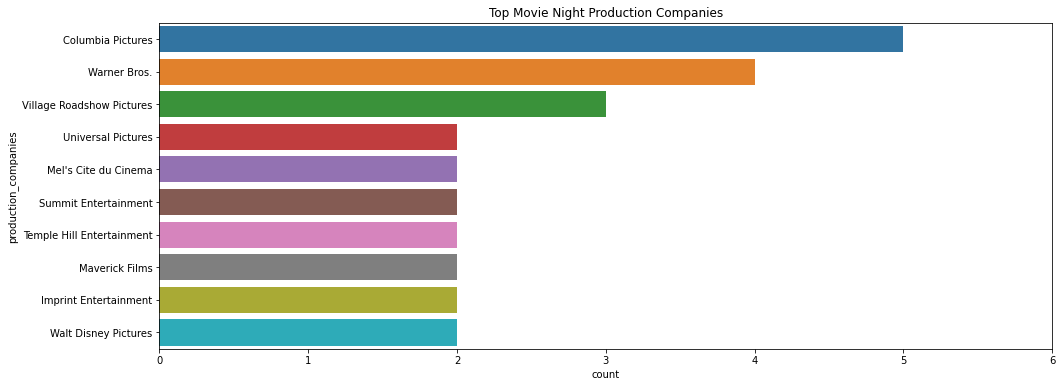

In [136]:
aggregate_countplot('production_companies',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,6],
                    title='Top Movie Night Production Companies', 
                    figure_name=False)

### Distributors

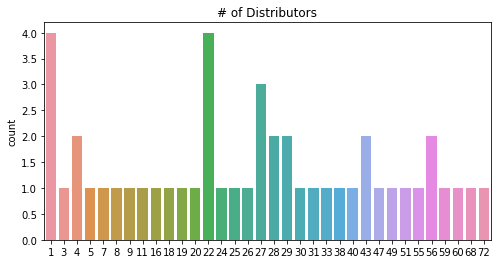

In [137]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['distributors_count'].values)
plt.title('# of Distributors')
plt.show()

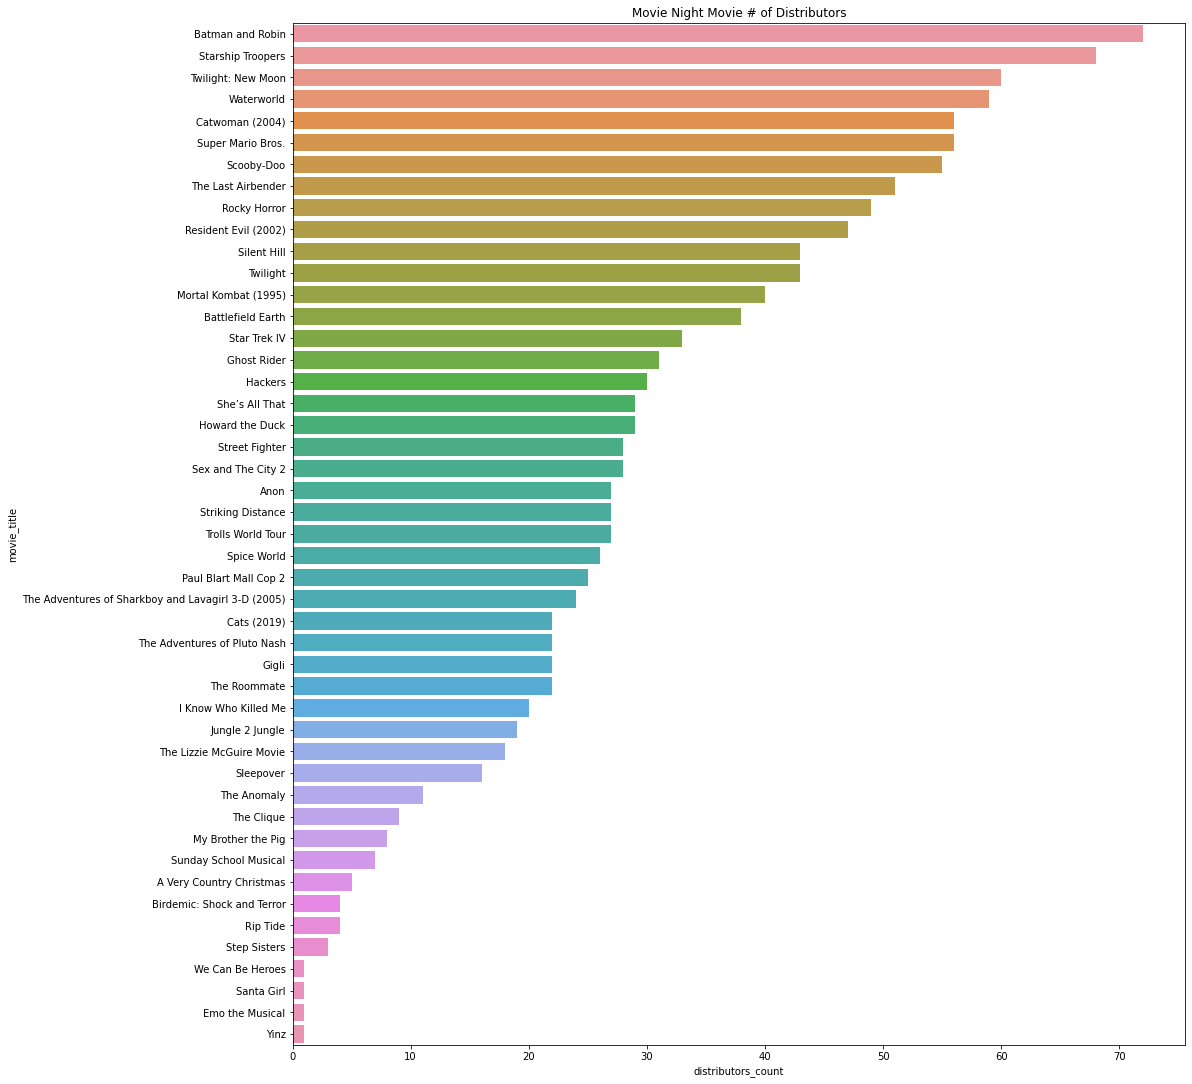

In [138]:
sorted_countplot('distributors_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Distributors', 
                 figure_name=False, 
                 ascending=False)

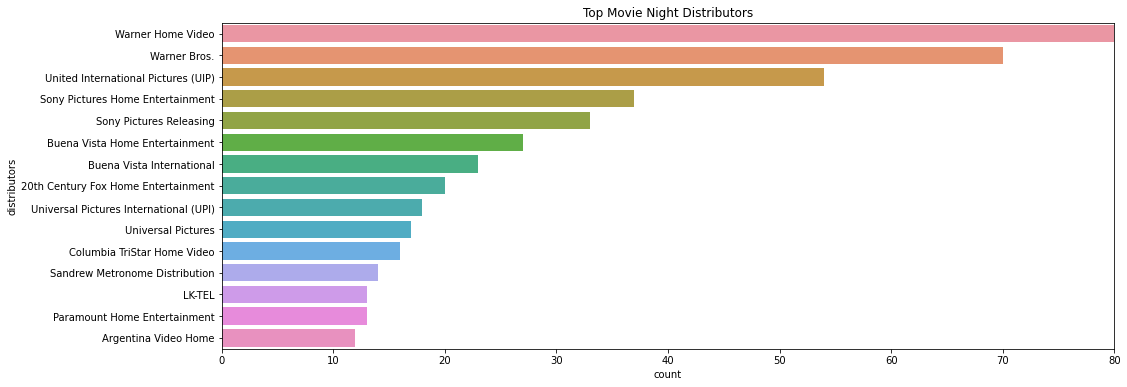

In [139]:
aggregate_countplot('distributors',
                    movie_df, 
                    num_items=15, 
                    plot_range=[0,80],
                    title='Top Movie Night Distributors', 
                    figure_name=False)

### Special Effects Companies

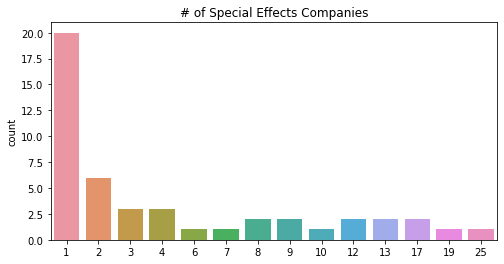

In [140]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['special_effects_companies_count'].values)
plt.title('# of Special Effects Companies')
plt.show()

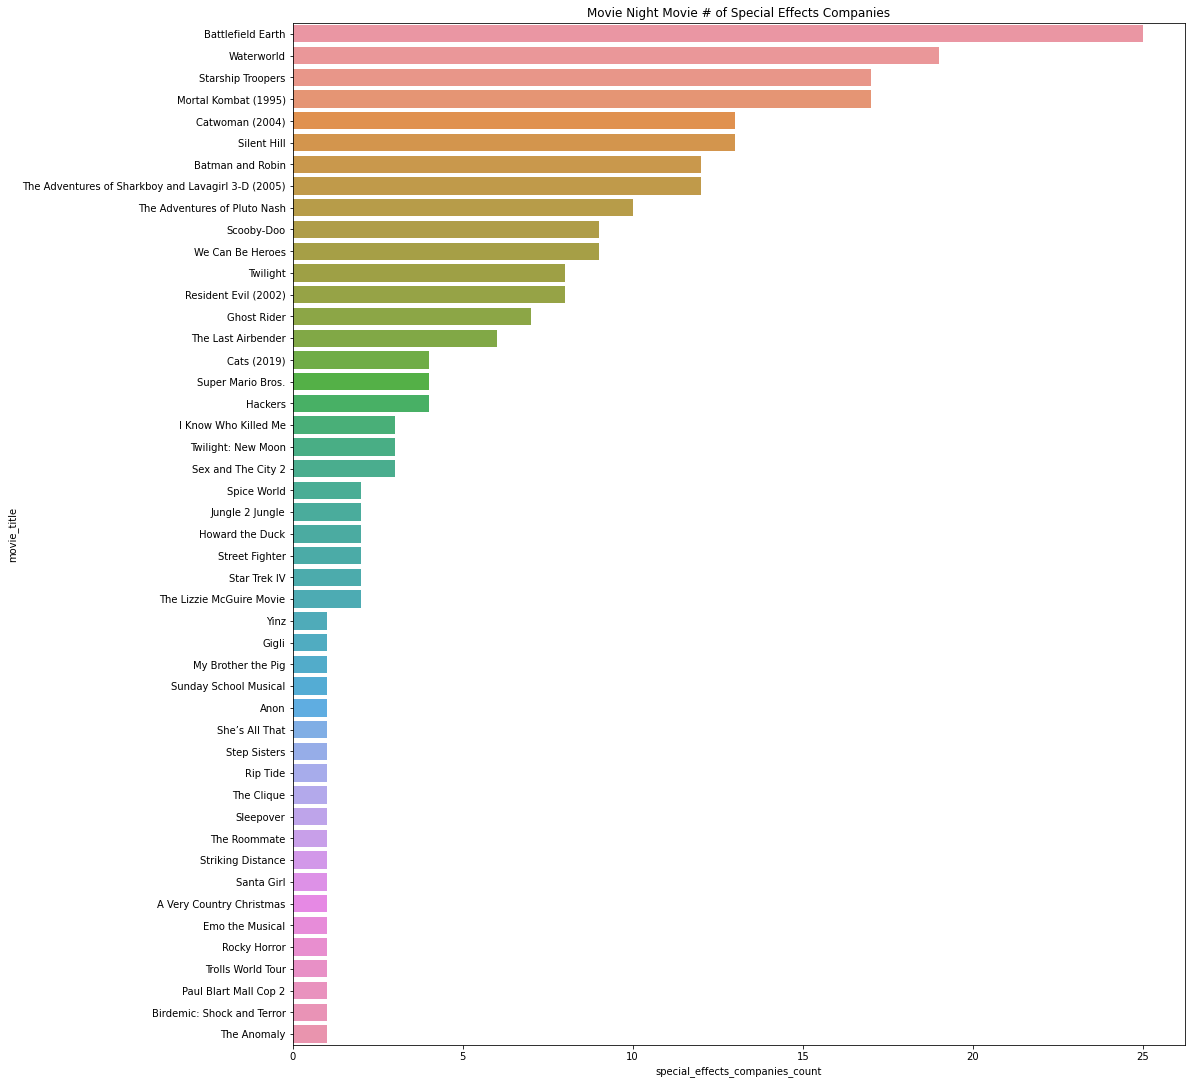

In [141]:
sorted_countplot('special_effects_companies_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Special Effects Companies', 
                 figure_name=False, 
                 ascending=False)

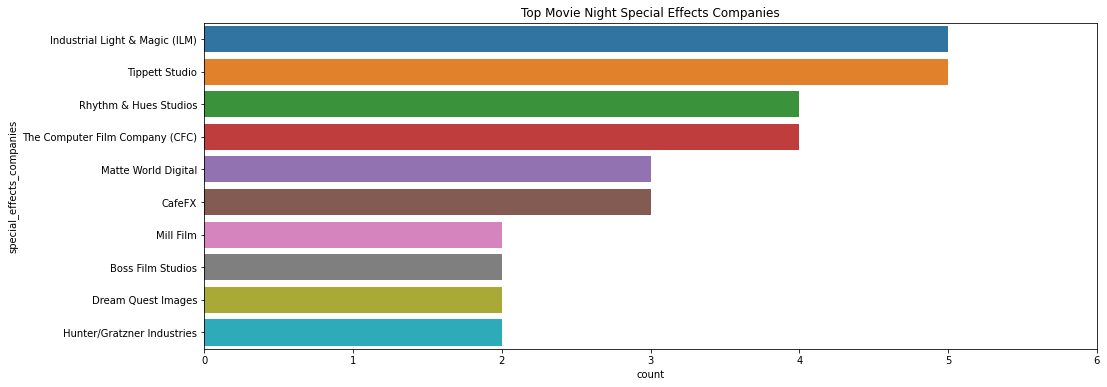

In [142]:
aggregate_countplot('special_effects_companies',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,6],
                    title='Top Movie Night Special Effects Companies', 
                    figure_name=False)

### Other Companies

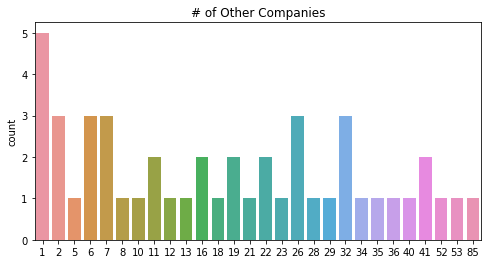

In [143]:
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x=movie_df['other_companies_count'].values)
plt.title('# of Other Companies')
plt.show()

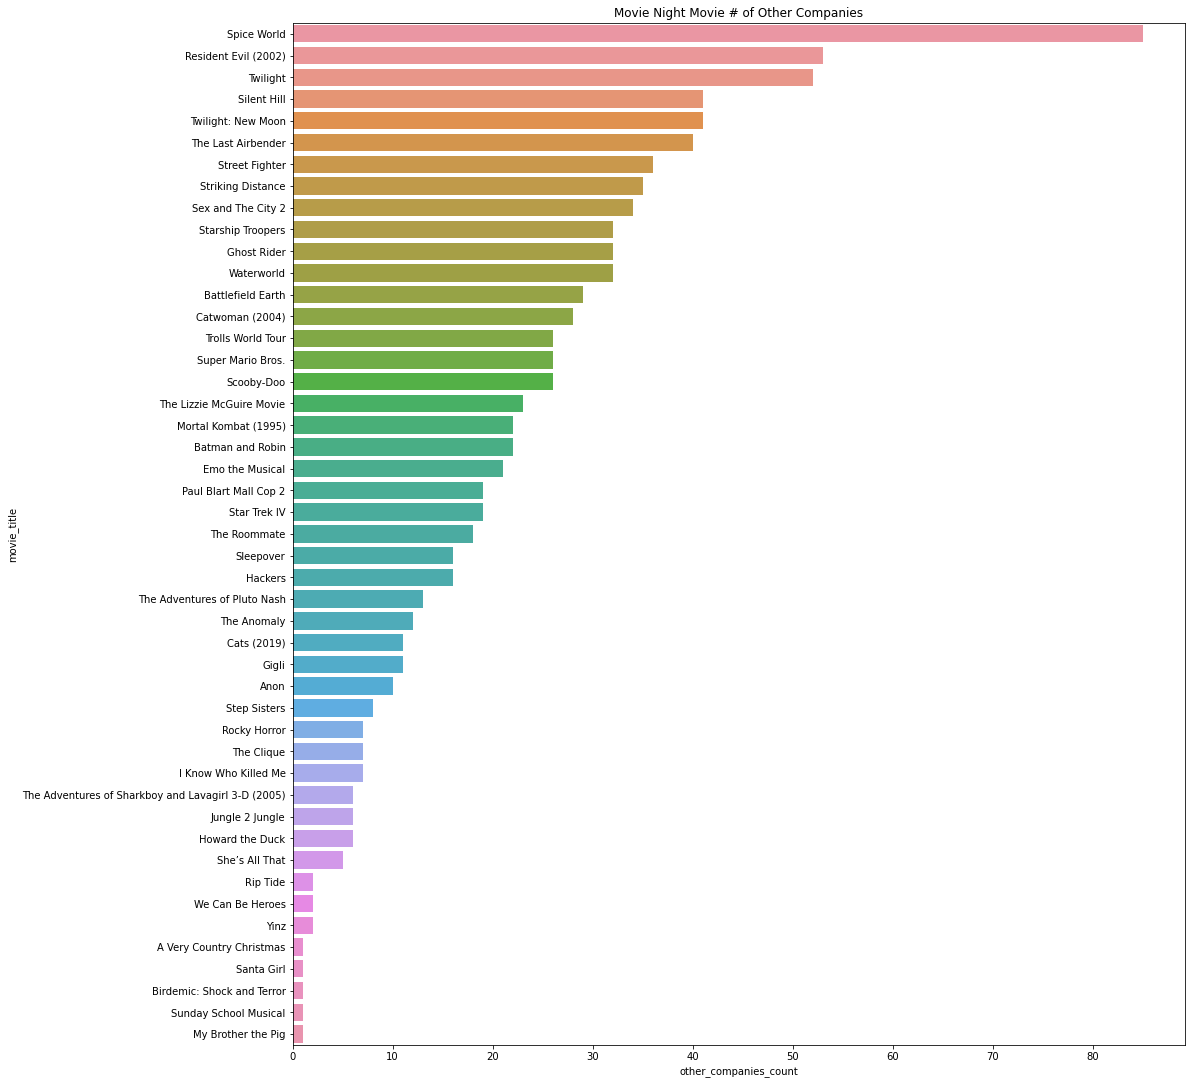

In [144]:
sorted_countplot('other_companies_count', 
                 movie_df, 
                 num_items=False, 
                 title='Movie Night Movie # of Other Companies', 
                 figure_name=False, 
                 ascending=False)

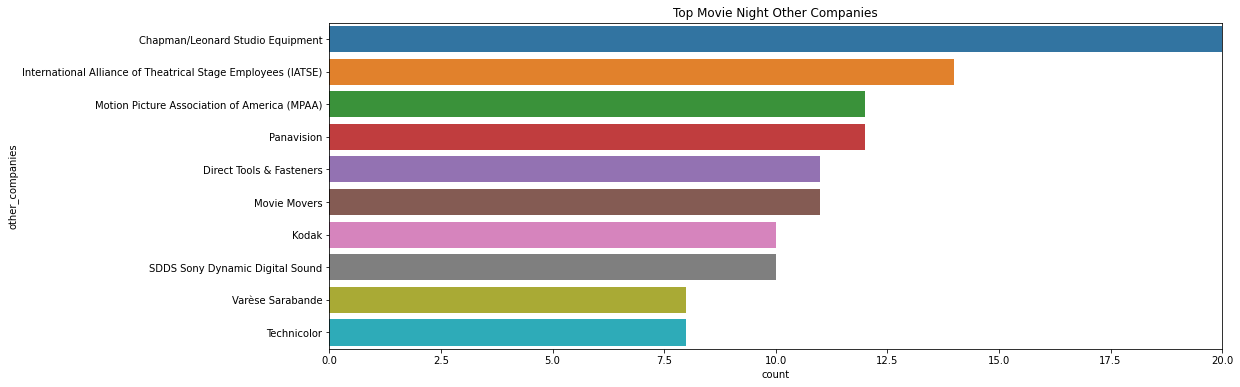

In [145]:
aggregate_countplot('other_companies',
                    movie_df, 
                    num_items=10, 
                    plot_range=[0,20],
                    title='Top Movie Night Other Companies', 
                    figure_name=False)

## Money Variables

NOTE:  Monetary values have been adjusted for inflation. 

* Budget
* Opening Weekend USA
* Gross USA
* Cumulative Worldwide Gross
* Profit 
* Profit Margin

### Budget

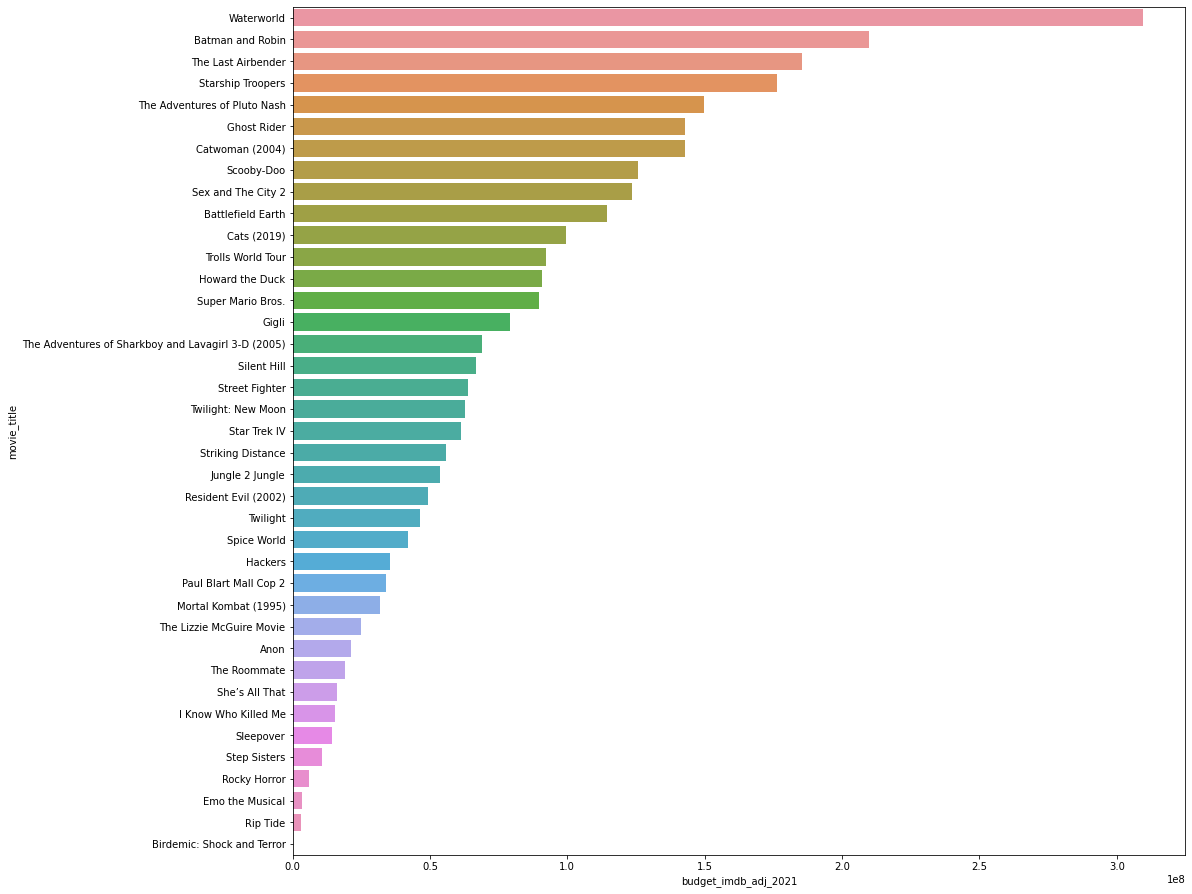

In [146]:
sorted_countplot('budget_imdb_adj_2021', 
                 movie_df, 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

### Domestic Opening Weekend Earnings

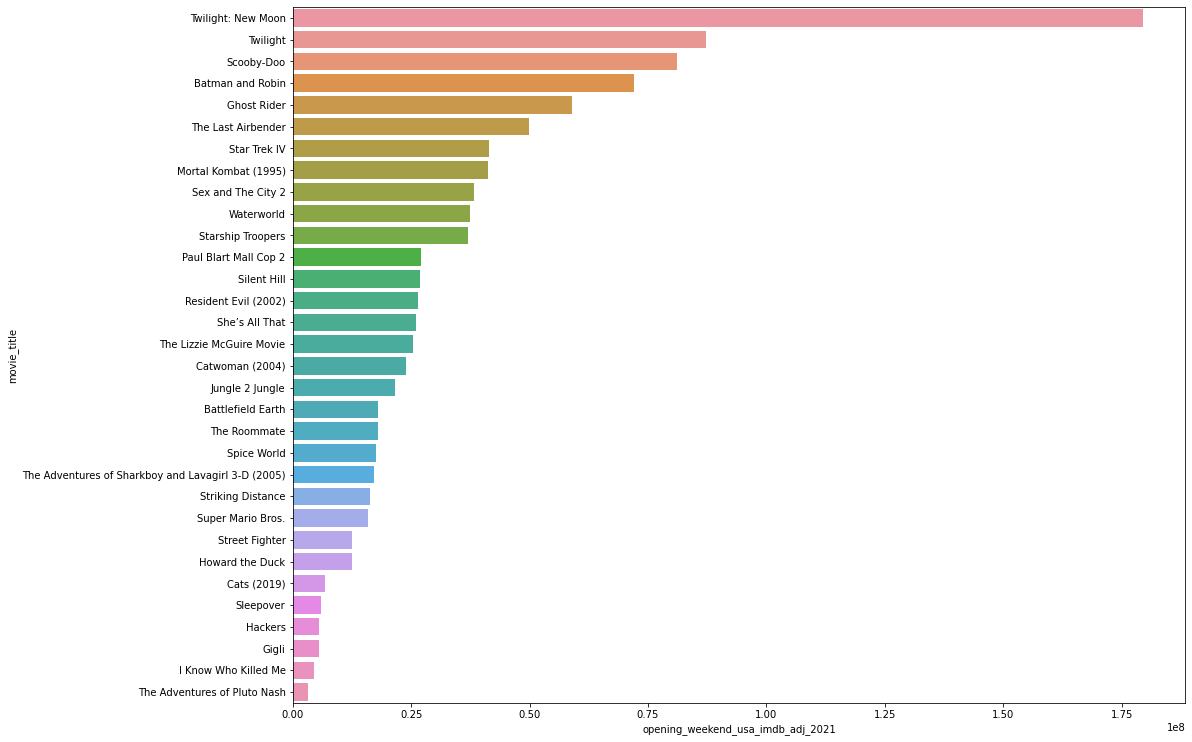

In [147]:
sorted_countplot('opening_weekend_usa_imdb_adj_2021', 
                 movie_df, 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

### Gross Domestic Earnings

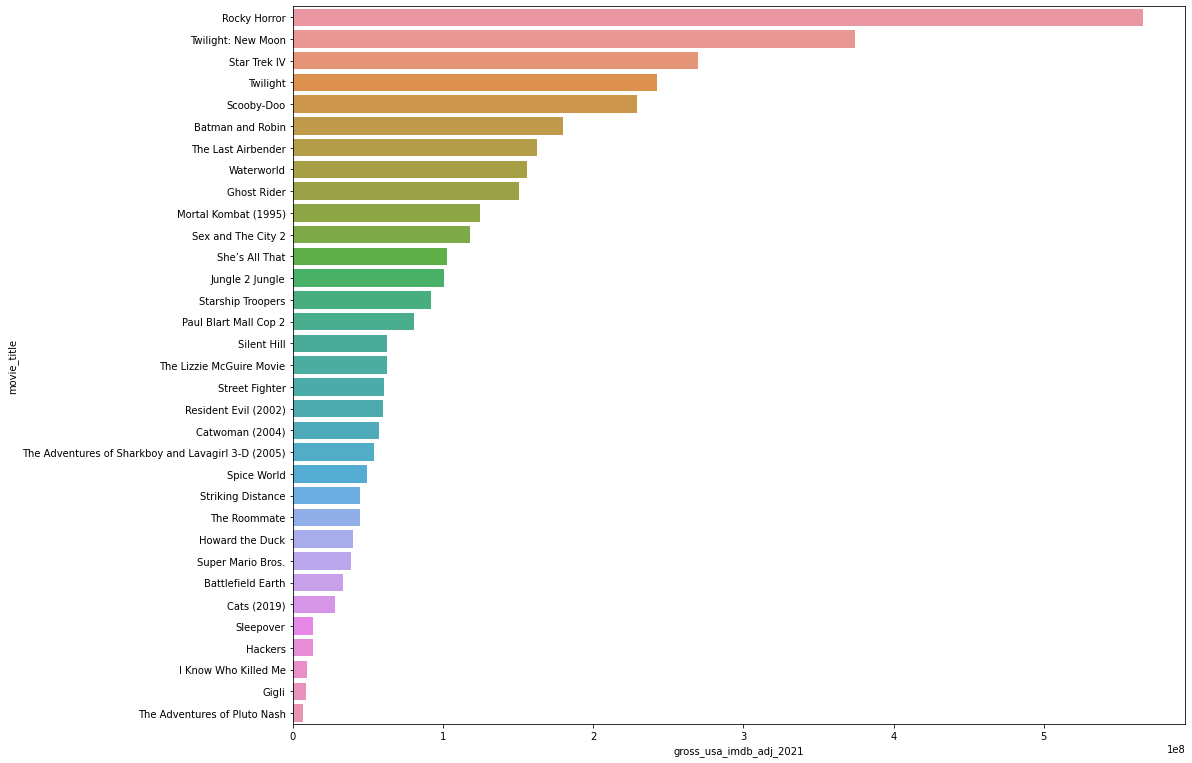

In [148]:
sorted_countplot('gross_usa_imdb_adj_2021', 
                 movie_df, 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

### Cumulative Worldwide Earnings

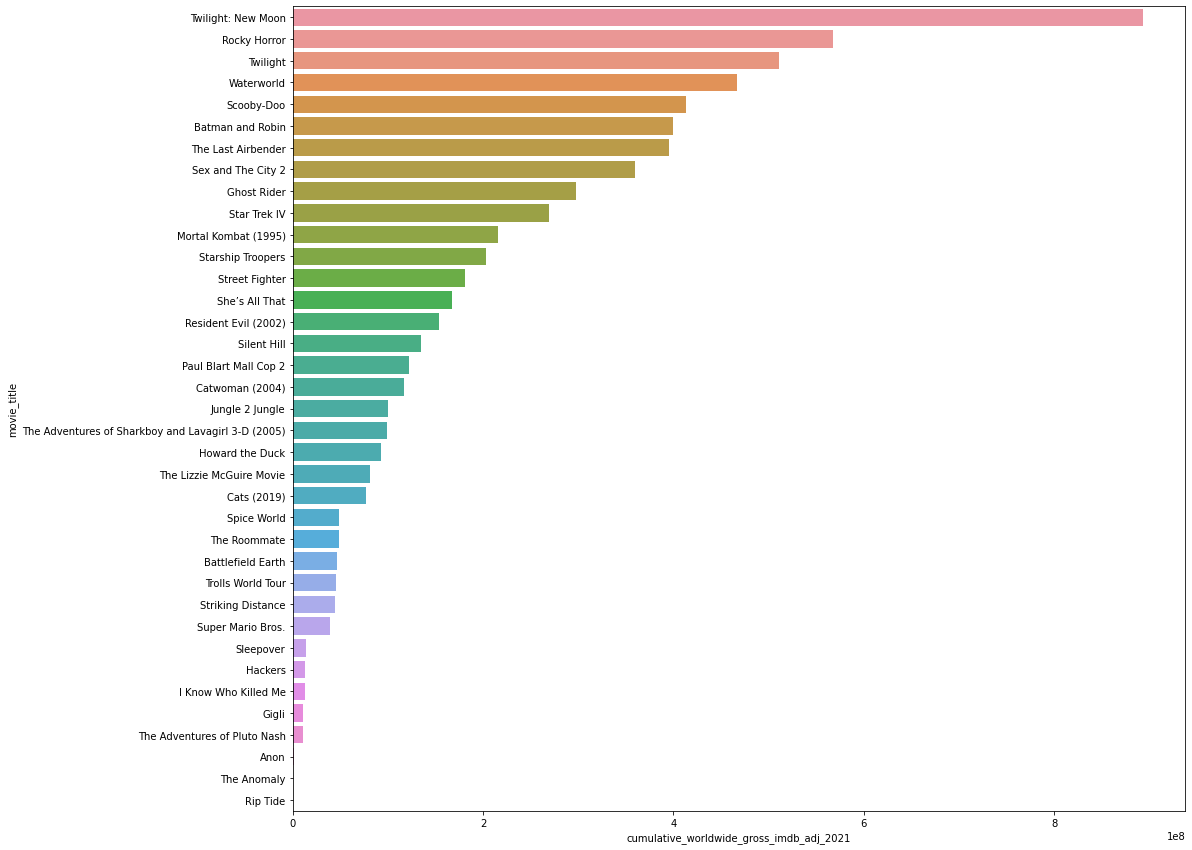

In [149]:
sorted_countplot('cumulative_worldwide_gross_imdb_adj_2021', 
                 movie_df, 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

### Gross Profit (Cumulative Worldwise Earnings - Budget)

In [150]:
filtered_movie_df = movie_df.loc[(movie_df['cumulative_worldwide_gross_imdb_adj_2021'] > 0) & (movie_df['budget_imdb_adj_2021'] > 0), :]
filtered_top100_df = top100_df.loc[(top100_df['cumulative_worldwide_gross_imdb_adj_2021'] > 0) & (top100_df['budget_imdb_adj_2021'] > 0), :]
filtered_bottom100_df = bottom100_df.loc[(bottom100_df['cumulative_worldwide_gross_imdb_adj_2021'] > 0) & (bottom100_df['budget_imdb_adj_2021'] > 0), :]

In [151]:
print('Movies with sufficient data to calculate profit and profit margin:')
print(str(round(len(filtered_movie_df) / len(movie_df),2)*100) + '%')

Movies with sufficient data to calculate profit and profit margin:
77.0%


In [152]:
filtered_movie_df['profit_adj_2021'] = filtered_movie_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_movie_df['budget_imdb_adj_2021']
filtered_top100_df['profit_adj_2021'] = filtered_top100_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_top100_df['budget_imdb_adj_2021']
filtered_bottom100_df['profit_adj_2021'] = filtered_bottom100_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_bottom100_df['budget_imdb_adj_2021']

<ipython-input-152-92403acc569c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movie_df['profit_adj_2021'] = filtered_movie_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_movie_df['budget_imdb_adj_2021']
<ipython-input-152-92403acc569c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_top100_df['profit_adj_2021'] = filtered_top100_df['cumulative_worldwide_gross_imdb_adj_2021'] - filtered_top100_df['budget_imdb_adj_2021']
<ipython-input-152-92403acc569c>:3: SettingWithCopyWarn

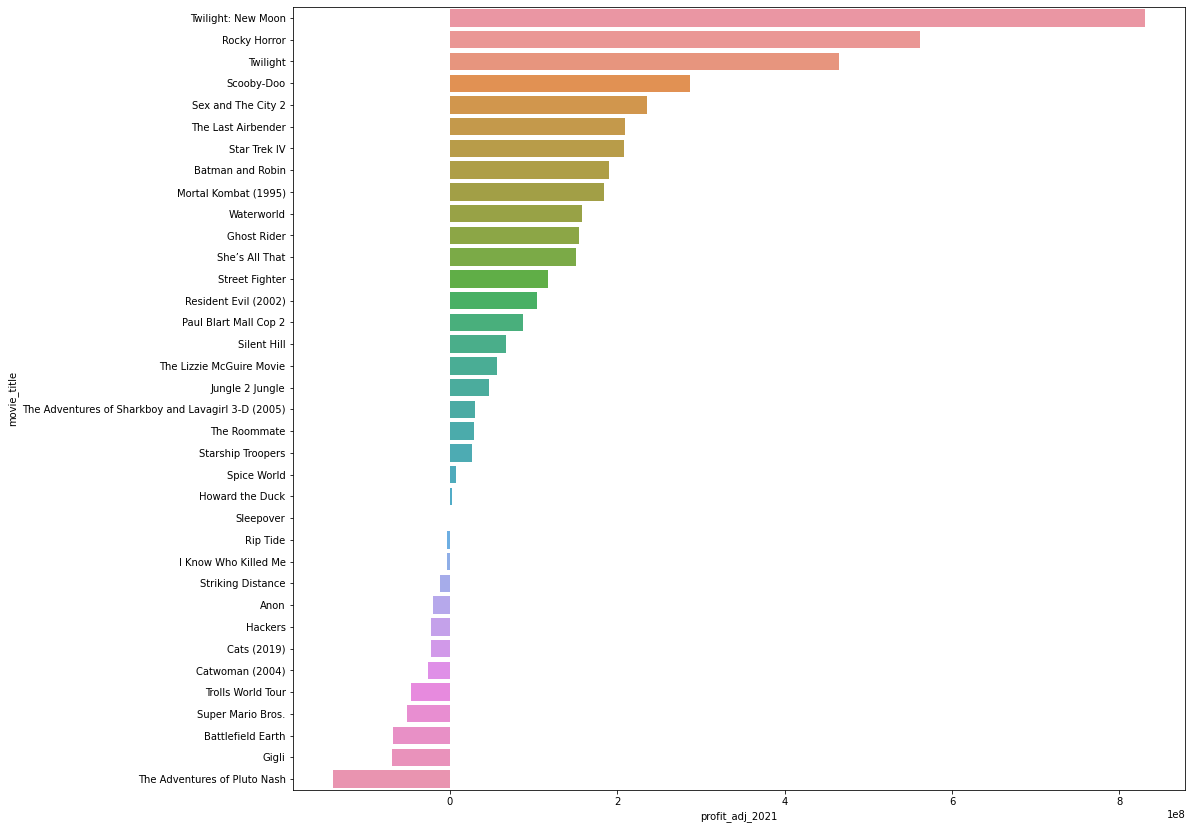

In [153]:
sorted_countplot('profit_adj_2021', 
                 filtered_movie_df, 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

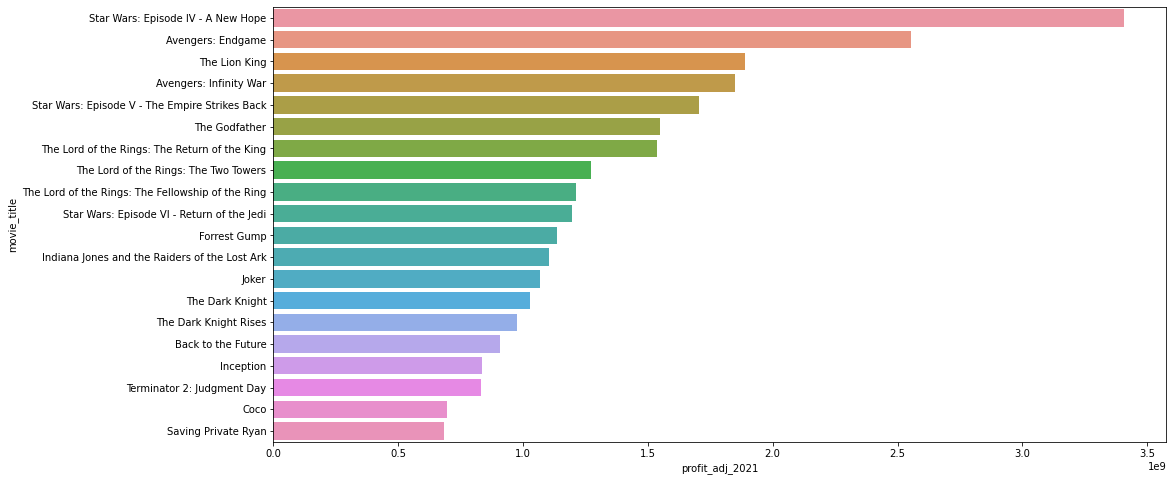

In [154]:
sorted_countplot('profit_adj_2021', 
                 filtered_top100_df, 
                 num_items=20, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

### Profit Margin (Gross Profit / Revenue)

In [155]:
filtered_movie_df['profit_margin_adj_2021'] = filtered_movie_df['profit_adj_2021'] / filtered_movie_df['cumulative_worldwide_gross_imdb_adj_2021']
filtered_top100_df['profit_margin_adj_2021'] = filtered_top100_df['profit_adj_2021'] / filtered_top100_df['cumulative_worldwide_gross_imdb_adj_2021']
filtered_bottom100_df['profit_margin_adj_2021'] = filtered_bottom100_df['profit_adj_2021'] / filtered_bottom100_df['cumulative_worldwide_gross_imdb_adj_2021']

<ipython-input-155-03337de81c05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movie_df['profit_margin_adj_2021'] = filtered_movie_df['profit_adj_2021'] / filtered_movie_df['cumulative_worldwide_gross_imdb_adj_2021']
<ipython-input-155-03337de81c05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_top100_df['profit_margin_adj_2021'] = filtered_top100_df['profit_adj_2021'] / filtered_top100_df['cumulative_worldwide_gross_imdb_adj_2021']
<ipython-input-155-03337de81c05>:3: SettingWithCopy

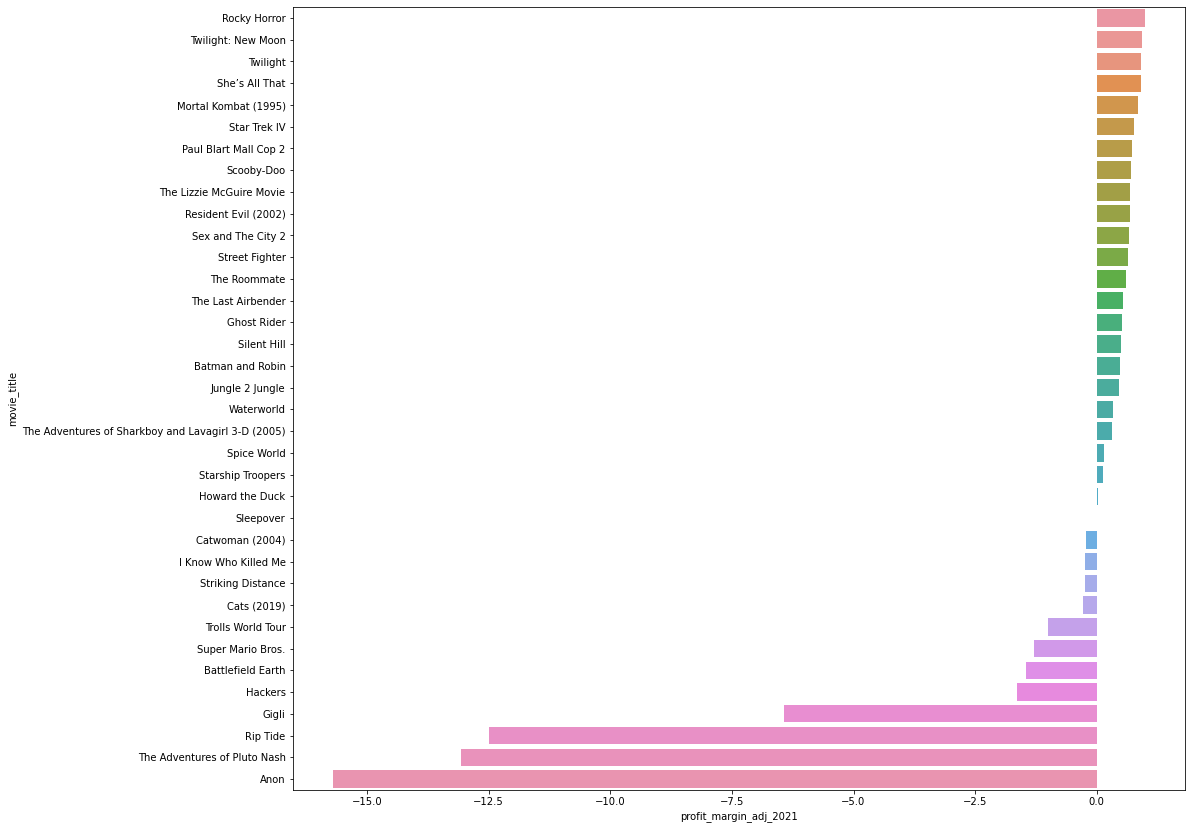

In [156]:
sorted_countplot('profit_margin_adj_2021', 
                 filtered_movie_df, 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

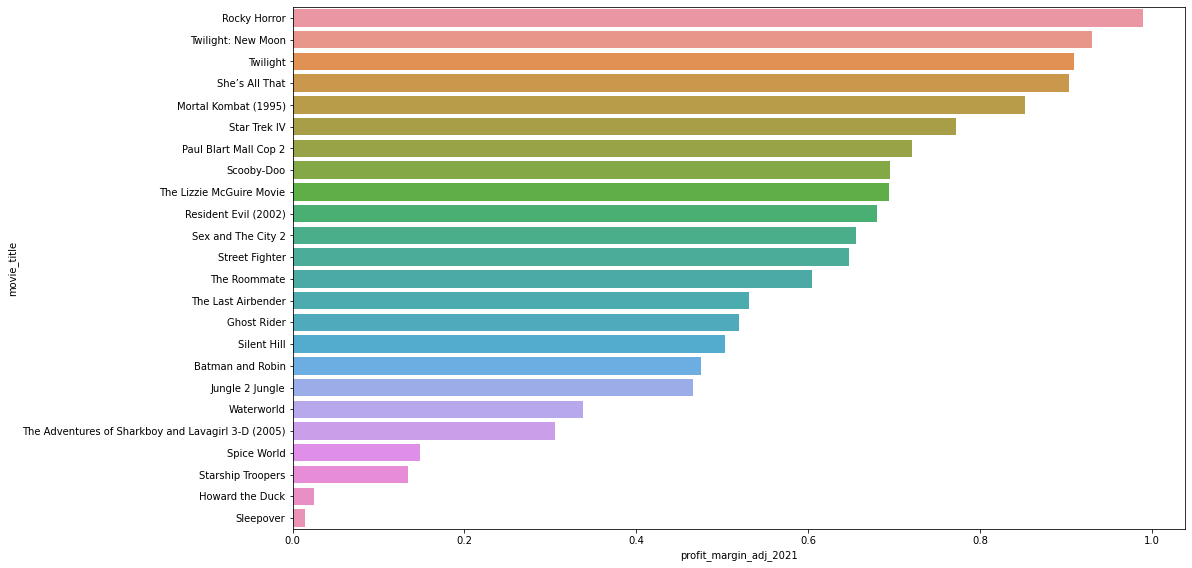

In [157]:
sorted_countplot('profit_margin_adj_2021', 
                 filtered_movie_df[filtered_movie_df['profit_margin_adj_2021'] > 0], 
                 num_items=False, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

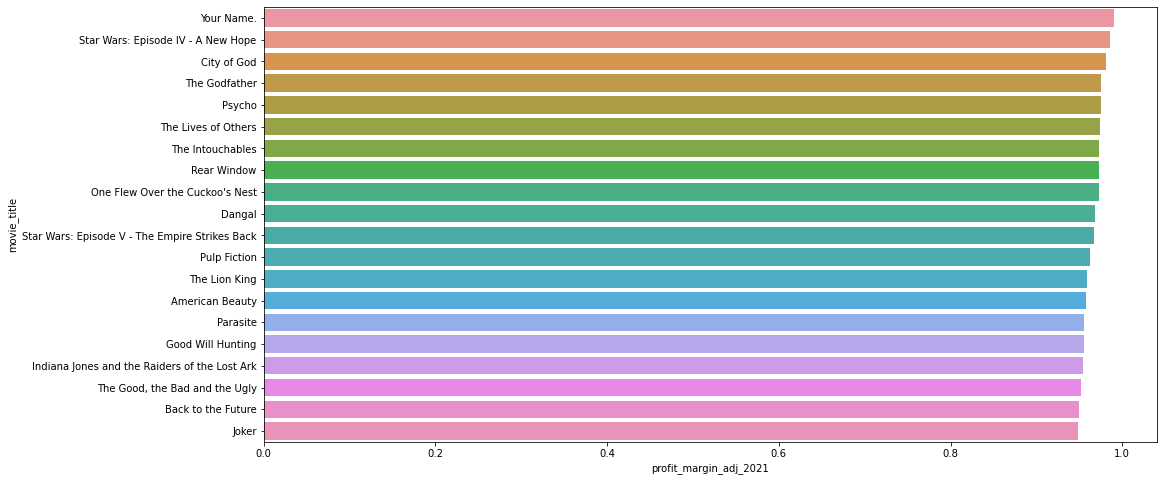

In [158]:
sorted_countplot('profit_margin_adj_2021', 
                 filtered_top100_df, 
                 num_items=20, 
                 title=False, 
                 figure_name=False, 
                 ascending=False)

# Save Dataframes 

In [159]:
movie_df.to_csv('data/movie_df.csv', index=False)
top100_df.to_csv('data/top100_df.csv', index=False)
bottom100_df.to_csv('data/bottom100_df.csv', index=False)

filtered_movie_df.to_csv('data/filtered_movie_df.csv', index=False)
filtered_top100_df.to_csv('data/filtered_top100_df.csv', index=False)
filtered_bottom100_df.to_csv('data/filtered_bottom100_df.csv', index=False)

In [160]:
# movie_df[movie_df['cast'].str.contains('Matthew Lillard')]